##### Copyright 2021 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Human Pose Classification with MoveNet and TensorFlow Lite

This notebook teaches you how to train a pose classification model using MoveNet and TensorFlow Lite. The result is a new TensorFlow Lite model that accepts the output from the MoveNet model as its input, and outputs a pose classification, such as the name of a yoga pose.

The procedure in this notebook consists of 3 parts:
* Part 1: Preprocess the pose classification training data into a CSV file that specifies the landmarks (body keypoints) detected by the MoveNet model, along with the ground truth pose labels.
* Part 2: Build and train a pose classification model that takes the landmark coordinates from the CSV file as input, and outputs the predicted labels.
* Part 3: Convert the pose classification model to TFLite.

By default, this notebook uses an image dataset with labeled yoga poses, but we've also included a section in Part 1 where you can upload your own image dataset of poses.

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/lite/tutorials/pose_classification"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/tensorflow/blob/master/tensorflow/lite/g3doc/tutorials/pose_classification.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/tensorflow/blob/master/tensorflow/lite/g3doc/tutorials/pose_classification.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/tensorflow/tensorflow/lite/g3doc/tutorials/pose_classification.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/s?q=movenet"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub model</a>
  </td>
</table>

## Preparation

In this section, you'll import the necessary libraries and define several functions to preprocess the training images into a CSV file that contains the landmark coordinates and ground truth labels.

Nothing observable happens here, but you can expand the hidden code cells to see the implementation for some of the functions we'll be calling later on.

**If you only want to create the CSV file without knowing all the details, just run this section and proceed to Part 1.**

In [1]:
!pip install -q opencv-python

In [2]:
!pip install -U scikit-learn scipy matplotlib
!pip install -q pandas
!pip install -q tqdm

   ---------------------------------------- 0.0/12.9 MB ? eta -:--:--
   - -------------------------------------- 0.5/12.9 MB 3.4 MB/s eta 0:00:04
   ---- ----------------------------------- 1.6/12.9 MB 6.0 MB/s eta 0:00:02
   --------- ------------------------------ 3.1/12.9 MB 6.1 MB/s eta 0:00:02
   ------------ --------------------------- 3.9/12.9 MB 5.2 MB/s eta 0:00:02
   ----------------- ---------------------- 5.8/12.9 MB 6.0 MB/s eta 0:00:02
   -------------------- ------------------- 6.6/12.9 MB 5.4 MB/s eta 0:00:02
   ----------------------- ---------------- 7.6/12.9 MB 5.7 MB/s eta 0:00:01
   -------------------------- ------------- 8.7/12.9 MB 5.5 MB/s eta 0:00:01
   ----------------------------- ---------- 9.4/12.9 MB 5.3 MB/s eta 0:00:01
   -------------------------------- ------- 10.5/12.9 MB 5.2 MB/s eta 0:00:01
   ----------------------------------- ---- 11.5/12.9 MB 5.2 MB/s eta 0:00:01
   -------------------------------------- - 12.6/12.9 MB 5.1 MB/s eta 0:00:01
   

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-intel 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.2.3 which is incompatible.


In [1]:
import csv
import cv2
import itertools
import numpy as np
import pandas as pd
import os
import sys
import tempfile
import tqdm

from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

### Code to run pose estimation using MoveNet

In [2]:
print(os.getcwd())
print(os.path.abspath(r'E:\Android\pose-monitor-master\main\examples\lite\examples\pose_estimation\raspberry_pi'))

d:\jupyter\CPRAPP\main
E:\Android\pose-monitor-master\main\examples\lite\examples\pose_estimation\raspberry_pi


In [5]:
#這兩個檔案需要用終端來載到 ....\pose-monitor-master\main\   裡面
#git clone https://github.com/tensorflow/examples.git
#wget -q -O movenet_thunder.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/thunder/tflite/float16/4?lite-format=tflite

In [6]:
#瑜珈資料集
#https://www.kaggle.com/datasets/niharika41298/yoga-poses-dataset?resource=download

In [3]:
#@title Functions to run pose estimation with MoveNet

#@markdown You'll download the MoveNet Thunder model from [TensorFlow Hub](https://www.google.com/url?sa=D&q=https%3A%2F%2Ftfhub.dev%2Fs%3Fq%3Dmovenet), and reuse some inference and visualization logic from the [MoveNet Raspberry Pi (Python)](https://github.com/tensorflow/examples/tree/master/lite/examples/pose_estimation/raspberry_pi) sample app to detect landmarks (ear, nose, wrist etc.) from the input images.

#@markdown *Note: You should use the most accurate pose estimation model (i.e. MoveNet Thunder) to detect the keypoints and use them to train the pose classification model to achieve the best accuracy. When running inference, you can use a pose estimation model of your choice (e.g. either MoveNet Lightning or Thunder).*

# Download model from TF Hub and check out inference code from GitHub

# 已手动下载，模型文件路径：pose-monitor\main\lite-model_movenet_singlepose_thunder_tflite_float16_4.tflite，按指令重命名为 movenet_thunder.tflite
# !wget -q -O movenet_thunder.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/thunder/tflite/float16/4?lite-format=tflite

# 这个库早就 clone 过了，在 Documents 下。
# !git clone https://github.com/tensorflow/examples.git

# Windows 路徑會報 Unicode error，加上 r（raw） 修改可以避免此問題
# 這個文件夾下是與inference相關的程式碼，後面各種import 用到了這個文件夾下的代碼
# pose_sample_rpi_path = r'E:\Android\pose-monitor-master\main\examples\lite\examples\pose_estimation\raspberry_pi'

# sys.path.append(pose_sample_rpi_path)

pose_sample_rpi_path = os.path.join(os.getcwd(), 'examples/lite/examples/pose_estimation/raspberry_pi')
sys.path.append(pose_sample_rpi_path)
# Load MoveNet Thunder model
import utils
from data import BodyPart
from ml import Movenet
movenet = Movenet('movenet_thunder')

# Define function to run pose estimation using MoveNet Thunder.
# You'll apply MoveNet's cropping algorithm and run inference multiple times on
# the input image to improve pose estimation accuracy.
def detect(input_tensor, inference_count=3):
  """Runs detection on an input image.
 
  Args:
    input_tensor: A [height, width, 3] Tensor of type tf.float32.
      Note that height and width can be anything since the image will be
      imm'draw_prediction_on_imageediately resized according to the needs of the model within this
      function.
    inference_count: Number of times the model should run repeatly on the
      same input image to improve detection accuracy.
 
  Returns:
    A Person entity detected by the MoveNet.SinglePose.
  """
  image_height, image_width, channel = input_tensor.shape
 
  # Detect pose using the full input image
  movenet.detect(input_tensor.numpy(), reset_crop_region=True)
 
  # Repeatedly using previous detection result to identify the region of
  # interest and only croping that region to improve detection accuracy
  for _ in range(inference_count - 1):
    person = movenet.detect(input_tensor.numpy(), 
                            reset_crop_region=False)

  return person

In [5]:
#@title Functions to visualize the pose estimation results.

def draw_prediction_on_image(
    image, person, crop_region=None, close_figure=True,
    keep_input_size=False):
  """Draws the keypoint predictions on image.
 
  Args:
    image: An numpy array with shape [height, width, channel] representing the
      pixel values of the input image.
    person: A person entity returned from the MoveNet.SinglePose model.
    close_figure: Whether to close the plt figure after the function returns.
    keep_input_size: Whether to keep the size of the input image.
 
  Returns:
    An numpy array with shape [out_height, out_width, channel] representing the
    image overlaid with keypoint predictions.
  """
  # Draw the detection result on top of the image.
  image_np = utils.visualize(image, [person])
  
  # Plot the image with detection results.
  height, width, channel = image.shape
  aspect_ratio = float(width) / height
  fig, ax = plt.subplots(figsize=(12 * aspect_ratio, 12))
  im = ax.imshow(image_np)
 
  if close_figure:
    plt.close(fig)
 
  if not keep_input_size:
    image_np = utils.keep_aspect_ratio_resizer(image_np, (512, 512))

  return image_np

In [9]:
# #@title Code to load the images, detect pose landmarks and save them into a CSV file

# class MoveNetPreprocessor(object):
#   """Helper class to preprocess pose sample images for classification."""
 
#   def __init__(self,
#                images_in_folder,
#                images_out_folder,
#                csvs_out_path):
#     """Creates a preprocessor to detection pose from images and save as CSV.

#     Args:
#       images_in_folder: Path to the folder with the input images. It should
#         follow this structure:
#         yoga_poses
#         |__ downdog
#             |______ 00000128.jpg
#             |______ 00000181.bmp
#             |______ ...
#         |__ goddess
#             |______ 00000243.jpg
#             |______ 00000306.jpg
#             |______ ...
#         ...
#       images_out_folder: Path to write the images overlay with detected
#         landmarks. These images are useful when you need to debug accuracy
#         issues.
#       csvs_out_path: Path to write the CSV containing the detected landmark
#         coordinates and label of each image that can be used to train a pose
#         classification model.
#     """
#     self._images_in_folder = images_in_folder
#     self._images_out_folder = images_out_folder
#     self._csvs_out_path = csvs_out_path
#     self._messages = []

#     # Create a temp dir to store the pose CSVs per class
#     self._csvs_out_folder_per_class = tempfile.mkdtemp()
 
#     # Get list of pose classes and print image statistics
#     self._pose_class_names = sorted(
#         [n for n in os.listdir(self._images_in_folder) if not n.startswith('.')]
#         )
    
#   def process(self, per_pose_class_limit=None, detection_threshold=0.1):
#     """Preprocesses images in the given folder.
#     Args:
#       per_pose_class_limit: Number of images to load. As preprocessing usually
#         takes time, this parameter can be specified to make the reduce of the
#         dataset for testing.
#       detection_threshold: Only keep images with all landmark confidence score
#         above this threshold.
#     """
#     # Loop through the classes and preprocess its images
#     for pose_class_name in self._pose_class_names:
#       print('Preprocessing', pose_class_name, file=sys.stderr)

#       # Paths for the pose class.
#       images_in_folder = os.path.join(self._images_in_folder, pose_class_name)
#       images_out_folder = os.path.join(self._images_out_folder, pose_class_name)
#       csv_out_path = os.path.join(self._csvs_out_folder_per_class,
#                                   pose_class_name + '.csv')
#       if not os.path.exists(images_out_folder):
#         os.makedirs(images_out_folder)
 
#       # Detect landmarks in each image and write it to a CSV file
#       with open(csv_out_path, 'w') as csv_out_file:
#         csv_out_writer = csv.writer(csv_out_file, 
#                                     delimiter=',', 
#                                     quoting=csv.QUOTE_MINIMAL)
#         # Get list of images
#         image_names = sorted(
#             [n for n in os.listdir(images_in_folder) if not n.startswith('.')])
#         if per_pose_class_limit is not None:
#           image_names = image_names[:per_pose_class_limit]

#         valid_image_count = 0
 
#         # Detect pose landmarks from each image
#         for image_name in tqdm.tqdm(image_names):
#           image_path = os.path.join(images_in_folder, image_name)

#           try:
#             image = tf.io.read_file(image_path)
#             image = tf.io.decode_jpeg(image)
#           except:
#             self._messages.append('Skipped ' + image_path + '. Invalid image.')
#             continue
#           else:
#             image = tf.io.read_file(image_path)
#             image = tf.io.decode_jpeg(image)
#             image_height, image_width, channel = image.shape
          
#           # Skip images that isn't RGB because Movenet requires RGB images
#           if channel != 3:
#             self._messages.append('Skipped ' + image_path +
#                                   '. Image isn\'t in RGB format.')
#             continue
#           person = detect(image)
          
#           # Save landmarks if all landmarks were detected
#           min_landmark_score = min(
#               [keypoint.score for keypoint in person.keypoints])
#           should_keep_image = min_landmark_score >= detection_threshold
#           if not should_keep_image:
#             self._messages.append('Skipped ' + image_path +
#                                   '. No pose was confidentlly detected.')
#             continue

#           valid_image_count += 1

#           # Draw the prediction result on top of the image for debugging later
#           output_overlay = draw_prediction_on_image(
#               image.numpy().astype(np.uint8), person, 
#               close_figure=True, keep_input_size=True)
        
#           # Write detection result into an image file
#           output_frame = cv2.cvtColor(output_overlay, cv2.COLOR_RGB2BGR)
#           cv2.imwrite(os.path.join(images_out_folder, image_name), output_frame)
        
#           # Get landmarks and scale it to the same size as the input image
#           pose_landmarks = np.array(
#               [[keypoint.coordinate.x, keypoint.coordinate.y, keypoint.score]
#                 for keypoint in person.keypoints],
#               dtype=np.float32)

#           # Write the landmark coordinates to its per-class CSV file
#           # coordinates = pose_landmarks.flatten().astype(np.str).tolist()
#           coordinates = pose_landmarks.flatten().astype(np.str_).tolist()
#           csv_out_writer.writerow([image_name] + coordinates)

#         if not valid_image_count:
#           raise RuntimeError(
#               'No valid images found for the "{}" class.'
#               .format(pose_class_name))
      
#     # Print the error message collected during preprocessing.
#     print('\n'.join(self._messages))

#     # Combine all per-class CSVs into a single output file
#     all_landmarks_df = self._all_landmarks_as_dataframe()
#     all_landmarks_df.to_csv(self._csvs_out_path, index=False)

#   def class_names(self):
#     """List of classes found in the training dataset."""
#     return self._pose_class_names
  
#   def _all_landmarks_as_dataframe(self):
#     """Merge all per-class CSVs into a single dataframe."""
#     total_df = None
#     for class_index, class_name in enumerate(self._pose_class_names):
#       csv_out_path = os.path.join(self._csvs_out_folder_per_class,
#                                   class_name + '.csv')
#       per_class_df = pd.read_csv(csv_out_path, header=None)
      
#       # Add the labels
#       per_class_df['class_no'] = [class_index]*len(per_class_df)
#       per_class_df['class_name'] = [class_name]*len(per_class_df)

#       # Append the folder name to the filename column (first column)
#       per_class_df[per_class_df.columns[0]] = (os.path.join(class_name, '') 
#         + per_class_df[per_class_df.columns[0]].astype(str))

#       if total_df is None:
#         # For the first class, assign its data to the total dataframe
#         total_df = per_class_df
#       else:
#         # Concatenate each class's data into the total dataframe
#         total_df = pd.concat([total_df, per_class_df], axis=0)
 
#     list_name = [[bodypart.name + '_x', bodypart.name + '_y', 
#                   bodypart.name + '_score'] for bodypart in BodyPart] 
#     header_name = []
#     for columns_name in list_name:
#       header_name += columns_name
#     header_name = ['file_name'] + header_name
#     header_map = {total_df.columns[i]: header_name[i] 
#                   for i in range(len(header_name))}
 
#     total_df.rename(header_map, axis=1, inplace=True)

#     return total_df

In [6]:
#@title Code to load the images, detect pose landmarks and save them into a CSV file

class MoveNetPreprocessor(object):
  """Helper class to preprocess pose sample images for classification."""
 
  def __init__(self,
               images_in_folder,
               images_out_folder,
               csvs_out_path):
    """Creates a preprocessor to detection pose from images and save as CSV.

    Args:
      images_in_folder: Path to the folder with the input images. It should
        follow this structure:
        yoga_poses
        |__ downdog
            |______ 00000128.jpg
            |______ 00000181.bmp
            |______ ...
        |__ goddess
            |______ 00000243.jpg
            |______ 00000306.jpg
            |______ ...
        ...
      images_out_folder: Path to write the images overlay with detected
        landmarks. These images are useful when you need to debug accuracy
        issues.
      csvs_out_path: Path to write the CSV containing the detected landmark
        coordinates and label of each image that can be used to train a pose
        classification model.
    """
    self._images_in_folder = images_in_folder
    self._images_out_folder = images_out_folder
    self._csvs_out_path = csvs_out_path
    self._messages = []

    # Create a temp dir to store the pose CSVs per class
    # self._csvs_out_folder_per_class = tempfile.mkdtemp()
    self._csvs_out_folder_per_class = os.path.join("output_csvs")  # 你想儲存的資料夾
    os.makedirs(self._csvs_out_folder_per_class, exist_ok=True)
 
    # Get list of pose classes and print image statistics
    self._pose_class_names = sorted(
        [n for n in os.listdir(self._images_in_folder) if not n.startswith('.')]
        )
 
  

  def process(self, per_pose_class_limit=None, detection_threshold=0.1):
    # Loop through the classes (e.g. class1, class2...)
        for pose_class_name in self._pose_class_names:
            print('Preprocessing', pose_class_name, file=sys.stderr)
    
            # 該 pose_class 對應的資料夾路徑 (原本只含 .jpg)
            class_folder_path = os.path.join(self._images_in_folder, pose_class_name)
            # 輸出 debug 圖片的資料夾（仍以 class_name 命名）
            images_out_folder = os.path.join(self._images_out_folder, pose_class_name)
            if not os.path.exists(images_out_folder):
                os.makedirs(images_out_folder)
    
            # === 新增：找出此 class_folder 裡所有「子資料夾」 ===
            subfolders = sorted([
                d for d in os.listdir(class_folder_path)
                if not d.startswith('.') and
                   os.path.isdir(os.path.join(class_folder_path, d))
            ])
    
            # 如果有需要，也可處理「class_folder_path 直下的 *.jpg」
            # 不過你明確要 folder1/*.jpg、folder2/*.jpg 就可忽略直下的影像。
    
            # === 針對每個子資料夾產生自己的 CSV ===
            for subfolder in subfolders:
                print(f'  └─ Subfolder: {subfolder}', file=sys.stderr)
    
                subfolder_path = os.path.join(class_folder_path, subfolder)
                # 決定輸出的 CSV 檔名 (例如 folder1.csv)
                # 若怕不同 class 也有同名 folder，可加上 pose_class_name 前綴
                # csv_filename = f"{pose_class_name}_{subfolder}.csv"
                csv_filename = f"{subfolder}.csv"
    
                csv_out_path = os.path.join(self._csvs_out_folder_per_class, csv_filename)

                #   all_landmarks_df = self._all_landmarks_as_dataframe()
                #   all_landmarks_df.to_csv(self._csvs_out_path, index=False)
                # 建立 CSV
                with open(csv_out_path, 'w', newline='') as csv_out_file:
                    csv_out_writer = csv.writer(csv_out_file, delimiter=',', quoting=csv.QUOTE_MINIMAL)

                        # === 先手動寫一次表頭 (header) ===
                    # 1) 第一個欄位是 file_name
                    header = ["file_name"]
                    # 2) 接著每個 keypoint 各 3 個欄位 (x, y, score)
                    for bodypart in BodyPart:
                        header.append(f"{bodypart.name}_x")
                        header.append(f"{bodypart.name}_y")
                        header.append(f"{bodypart.name}_score")
                
                    # 寫入表頭
                    csv_out_writer.writerow(header)


                    # 取得子資料夾內所有圖片名稱
                    image_names = sorted([
                        n for n in os.listdir(subfolder_path)
                        if not n.startswith('.')  # 過濾隱藏檔
                    ])
                    # 如果要限制每個 pose class 的筆數
                    if per_pose_class_limit is not None:
                        image_names = image_names[:per_pose_class_limit]
    
                    valid_image_count = 0
    
                    # === 偵測每張圖的姿勢 ===
                    for image_name in tqdm.tqdm(image_names):
                        image_path = os.path.join(subfolder_path, image_name)
                        # 嘗試讀取圖片
                        try:
                            image = tf.io.read_file(image_path)
                            image = tf.io.decode_jpeg(image)
                        except:
                            self._messages.append(f'Skipped {image_path}. Invalid image.')
                            continue
                        else:
                            # 取得 shape
                            image_height, image_width, channel = image.shape
    
                        # 若非 RGB，略過
                        if channel != 3:
                            self._messages.append(f'Skipped {image_path}. Not RGB.')
                            continue
    
                        # 呼叫你的偵測函式
                        person = detect(image)
                        
                        # 檢查最小 keypoint 信心分數
                        min_landmark_score = min([k.score for k in person.keypoints])
                        if min_landmark_score < detection_threshold:
                            self._messages.append(f'Skipped {image_path}. Low confidence.')
                            continue
    
                        valid_image_count += 1
    
                        # Debug 圖片輸出 (在 images_out_folder 下，再加上 subfolder)
                        # 例如: images_out_train_folder/class1/folder1/image.jpg
                        out_subfolder_path = os.path.join(images_out_folder, subfolder)
                        if not os.path.exists(out_subfolder_path):
                            os.makedirs(out_subfolder_path)
    
                        output_overlay = draw_prediction_on_image(
                            image.numpy().astype(np.uint8),
                            person,
                            close_figure=True,
                            keep_input_size=True
                        )
                        output_frame = cv2.cvtColor(output_overlay, cv2.COLOR_RGB2BGR)
                        cv2.imwrite(os.path.join(out_subfolder_path, image_name), output_frame)
    
                        # 取出 keypoint 座標與分數
                        pose_landmarks = np.array(
                            [[kp.coordinate.x, kp.coordinate.y, kp.score] for kp in person.keypoints],
                            dtype=np.float32
                        )
    
                        # 攤平成一維並轉成字串
                        coordinates = pose_landmarks.flatten().astype(np.str_).tolist()
                        csv_out_writer.writerow([image_name] + coordinates)
    
                    # 如果這個子資料夾沒有效圖片，就報錯
                    if not valid_image_count:
                        raise RuntimeError(
                            f'No valid images found in subfolder "{subfolder}" (class: {pose_class_name}).'
                        )
    
        # 列印處理過程中的所有警告或錯誤訊息
        print('\n'.join(self._messages))
    
        # 既然現在是一個 subfolder 對應一個 CSV，你或許「不再」需要把所有 CSV 合併成一個。
        # 如果仍想做統一合併，可改寫 _all_landmarks_as_dataframe() 讓它抓各 subfolder CSV。
    
    

  def class_names(self):
    """List of classes found in the training dataset."""
    return self._pose_class_names
  
  def _all_landmarks_as_dataframe(self):
    """Merge all per-class CSVs into a single dataframe."""
    total_df = None
    for class_index, class_name in enumerate(self._pose_class_names):
      csv_out_path = os.path.join(self._csvs_out_folder_per_class,
                                  class_name + '.csv')
      per_class_df = pd.read_csv(csv_out_path, header=None)
      
      # Add the labels
      per_class_df['class_no'] = [class_index]*len(per_class_df)
      per_class_df['class_name'] = [class_name]*len(per_class_df)

      # Append the folder name to the filename column (first column)
      per_class_df[per_class_df.columns[0]] = (os.path.join(class_name, '') 
        + per_class_df[per_class_df.columns[0]].astype(str))

      if total_df is None:
        # For the first class, assign its data to the total dataframe
        total_df = per_class_df
      else:
        # Concatenate each class's data into the total dataframe
        total_df = pd.concat([total_df, per_class_df], axis=0)
 
    list_name = [[bodypart.name + '_x', bodypart.name + '_y', 
                  bodypart.name + '_score'] for bodypart in BodyPart] 
    header_name = []
    for columns_name in list_name:
      header_name += columns_name
    header_name = ['file_name'] + header_name
    header_map = {total_df.columns[i]: header_name[i] 
                  for i in range(len(header_name))}
 
    total_df.rename(header_map, axis=1, inplace=True)

    return total_df

In [11]:
# # 畫一個正確坐姿的圖片，和錯誤坐姿進行對比顯示
# image_good = tf.io.read_file(r'E:\Android\pose-monitor-master\main\pose_data\train\standard\standard_012.jpg')
# #image_good = tf.io.read_file(r'E:\Android\pose-monitor-master\main\pose_data\train\train_002.jpg\standard_012.jpg')
# image_good = tf.io.decode_jpeg(image_good)
# person = detect(image_good)
# _ = draw_prediction_on_image(image_good.numpy(), person, crop_region=None, 
#                            close_figure=False, keep_input_size=True)

In [7]:
#@title (Optional) Code snippet to try out the Movenet pose estimation logic

#@markdown You can download an image from the internet, run the pose estimation logic on it and plot the detected landmarks on top of the input image. 

#@markdown *Note: This code snippet is also useful for debugging when you encounter an image with bad pose classification accuracy. You can run pose estimation on the image and see if the detected landmarks look correct or not before investigating the pose classification logic.*

# test_image_url = "https://cdn.pixabay.com/photo/2017/03/03/17/30/yoga-2114512_960_720.jpg" #@param {type:"string"}
# !wget -O /tmp/image.jpeg {test_image_url}

#if len(test_image_url):
#image_bad = tf.io.read_file(r'E:\Android\pose-monitor-master\main\pose_data\train\train_001.jpg\forwardhead_010.jpg')
# image_bad = tf.io.read_file(r'"D:\jupyter\CPRAPP\main\pose_data\train\standjump\CAO,RUEI-LIAN(1)\CAO,RUEI-LIAN(1)_000061.jpg"')
image_bad = tf.io.read_file("D:\\jupyter\\CPRAPP\\main\\pose_data\\train\\standjump\\CAO,RUEI-LIAN(1)\\CAO,RUEI-LIAN(1)_000061.jpg")
image_bad = tf.io.decode_jpeg(image_bad)
person = detect(image_bad)
_ = draw_prediction_on_image(image_bad.numpy(), person, crop_region=None, 
                           close_figure=False, keep_input_size=True)

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xa8 in position 229: invalid start byte

## Part 1: Preprocess the input images

Because the input for our pose classifier is the *output* landmarks from the MoveNet model, we need to generate our training dataset by running labeled images through MoveNet and then capturing all the landmark data and ground truth labels into a CSV file.

The dataset we've provided for this tutorial is a CG-generated yoga pose dataset. It contains images of multiple CG-generated models doing 5 different yoga poses. The directory is already split into a `train` dataset and a `test` dataset.

So in this section, we'll download the yoga dataset and run it through MoveNet so we can capture all the landmarks into a CSV file... **However, it takes about 15 minutes to feed our yoga dataset to MoveNet and generate this CSV file**. So as an alternative, you can download a pre-existing CSV file for the yoga dataset by setting `is_skip_step_1` parameter below to **True**. That way, you'll skip this step and instead download the same CSV file that will be created in this preprocessing step.

On the other hand, if you want to train the pose classifier with your own image dataset, you need to upload your images and run this preprocessing step (leave `is_skip_step_1` **False**)—follow the instructions below to upload your own pose dataset.

In [8]:
is_skip_step_1 = False #@param ["False", "True"] {type:"raw"}

### (Optional) Upload your own pose dataset

In [9]:
use_custom_dataset = True #@param ["False", "True"] {type:"raw"}

dataset_is_split = True #@param ["False", "True"] {type:"raw"}

If you want to train the pose classifier with your own labeled poses (they can be any poses, not just yoga poses), follow these steps:

1. Set the above `use_custom_dataset` option to **True**.

2. Prepare an archive file (ZIP, TAR, or other) that includes a folder with your images dataset. The folder must include sorted images of your poses as follows.

  If you've already split your dataset into train and test sets, then set `dataset_is_split` to **True**. That is, your images folder must include "train" and "test" directories like this:

    ```
    yoga_poses/
    |__ train/
        |__ downdog/
            |______ 00000128.jpg
            |______ ...
    |__ test/
        |__ downdog/
            |______ 00000181.jpg
            |______ ...
    ```

    Or, if your dataset is NOT split yet, then set
    `dataset_is_split` to **False** and we'll split it up based
    on a specified split fraction. That is, your uploaded images
    folder should look like this:

    ```
    yoga_poses/
    |__ downdog/
        |______ 00000128.jpg
        |______ 00000181.jpg
        |______ ...
    |__ goddess/
        |______ 00000243.jpg
        |______ 00000306.jpg
        |______ ...
    ```
3. Click the **Files** tab on the left (folder icon) and then click **Upload to session storage** (file icon).
4. Select your archive file and wait until it finishes uploading before you proceed.
5. Edit the following code block to specify the name of your archive file and images directory. (By default, we expect a ZIP file, so you'll need to also modify that part if your archive is another format.)
6. Now run the rest of the notebook.

In [10]:
#@markdown Be sure you run this cell. It's hiding the `split_into_train_test()` function that's called in the next code block.

import os
import random
import shutil

def split_into_train_test(images_origin, images_dest, test_split):
  """Splits a directory of sorted images into training and test sets.

  Args:
    images_origin: Path to the directory with your images. This directory
      must include subdirectories for each of your labeled classes. For example:
      yoga_poses/
      |__ downdog/
          |______ 00000128.jpg
          |______ 00000181.jpg
          |______ ...
      |__ goddess/
          |______ 00000243.jpg
          |______ 00000306.jpg
          |______ ...
      ...
    images_dest: Path to a directory where you want the split dataset to be
      saved. The results looks like this:
      split_yoga_poses/
      |__ train/
          |__ downdog/
              |______ 00000128.jpg
              |______ ...
      |__ test/
          |__ downdog/
              |______ 00000181.jpg
              |______ ...
    test_split: Fraction of data to reserve for test (float between 0 and 1).
  """
  _, dirs, _ = next(os.walk(images_origin))

  TRAIN_DIR = os.path.join(images_dest, 'train')
  TEST_DIR = os.path.join(images_dest, 'test')
  os.makedirs(TRAIN_DIR, exist_ok=True)
  os.makedirs(TEST_DIR, exist_ok=True)

  for dir in dirs:
    # Get all filenames for this dir, filtered by filetype
    filenames = os.listdir(os.path.join(images_origin, dir))
    filenames = [os.path.join(images_origin, dir, f) for f in filenames if (
        f.endswith('.png') or f.endswith('.jpg') or f.endswith('.jpeg') or f.endswith('.bmp'))]
    # Shuffle the files, deterministically
    filenames.sort()
    random.seed(42)
    random.shuffle(filenames)
    # Divide them into train/test dirs
    os.makedirs(os.path.join(TEST_DIR, dir), exist_ok=True)
    os.makedirs(os.path.join(TRAIN_DIR, dir), exist_ok=True)
    test_count = int(len(filenames) * test_split)
    for i, file in enumerate(filenames):
      if i < test_count:
        destination = os.path.join(TEST_DIR, dir, os.path.split(file)[1])
      else:
        destination = os.path.join(TRAIN_DIR, dir, os.path.split(file)[1])
      shutil.copyfile(file, destination)
    print(f'Moved {test_count} of {len(filenames)} from class "{dir}" into test.')
  print(f'Your split dataset is in "{images_dest}"')

In [11]:
if use_custom_dataset:
  # ATTENTION:
  # You must edit these two lines to match your archive and images folder name:
  # !tar -xf YOUR_DATASET_ARCHIVE_NAME.tar
  # !unzip -q YOUR_DATASET_ARCHIVE_NAME.zip
  dataset_in = 'pose_data'

  # You can leave the rest alone:
  if not os.path.isdir(dataset_in):
    raise Exception("dataset_in is not a valid directory")
  if dataset_is_split:
    IMAGES_ROOT = dataset_in
  else:
    dataset_out = 'split_' + dataset_in
    split_into_train_test(dataset_in, dataset_out, test_split=0.2)
    IMAGES_ROOT = dataset_out

**Note:** If you're using `split_into_train_test()` to split the dataset, it expects all images to be PNG, JPEG, or BMP—it ignores other file types.

### Download the yoga dataset

In [12]:
if not is_skip_step_1 and not use_custom_dataset:
  !wget -O yoga_poses.zip http://download.tensorflow.org/data/pose_classification/yoga_poses.zip
  !unzip -q yoga_poses.zip -d yoga_cg
  IMAGES_ROOT = "yoga_cg"

### Preprocess the `TRAIN` dataset

In [ ]:
#tf.io.read_file(r'E:\Android\pose-monitor-master\main\pose_data\train\train_001.jpg')

if not is_skip_step_1:
 images_in_train_folder = os.path.join(IMAGES_ROOT, 'train')
 images_out_train_folder = 'poses_images_out_train'
 csvs_out_train_path = 'train_data.csv'

 preprocessor = MoveNetPreprocessor(
      images_in_folder=images_in_train_folder,
       images_out_folder=images_out_train_folder,
       csvs_out_path=csvs_out_train_path,
  )

# preprocessor.process(per_pose_class_limit=None)  #如果不要重新標記就不用這一行

Preprocessing pull_up
  └─ Subfolder: CAO,RUEI-LIAN(1)
100%|██████████| 31/31 [00:02<00:00, 12.66it/s]
  └─ Subfolder: CAO,RUEI-LIAN(2)
 39%|███▉      | 13/33 [00:00<00:01, 15.12it/s]


KeyboardInterrupt: 

In [14]:
import os
import cv2
import csv
import sys
import numpy as np
import tensorflow as tf
import tqdm

class MoveNetPreprocessor(object):
    """Simplified MoveNet Preprocessor without subfolders."""

    def __init__(self, images_in_folder, images_out_folder, csvs_out_path):
        """
        Args:
            images_in_folder: 存放輸入圖片的資料夾。
            images_out_folder: 存放偵測後圖片的資料夾。
            csvs_out_path: 存放關節點資料的 CSV 檔案路徑。
        """
        if not os.path.exists(images_in_folder):
            os.makedirs(images_in_folder)

        self._images_in_folder = images_in_folder
        self._images_out_folder = images_out_folder
        self._csvs_out_path = csvs_out_path
        self._messages = []

        os.makedirs(self._images_out_folder, exist_ok=True)
        os.makedirs(os.path.dirname(self._csvs_out_path), exist_ok=True)

        # 取得所有圖片檔案名稱 (.jpg, .png)


    def process(self, detection_threshold=0.1):
        """處理所有圖片，進行姿勢偵測並輸出結果到圖片和 CSV。"""
        print("🚀 開始處理圖片...")

        self._image_names = sorted([
            f for f in os.listdir(self._images_in_folder)
            if f.lower().endswith(('.jpg', '.jpeg', '.png')) and not f.startswith('.')
        ])
        # 建立 CSV 檔案，寫入表頭
        with open(self._csvs_out_path, 'w', newline='') as csv_out_file:
            csv_out_writer = csv.writer(csv_out_file, delimiter=',', quoting=csv.QUOTE_MINIMAL)

            # 表頭：file_name + 每個 keypoint 的 (x, y, score)
            header = ["file_name"]
            for bodypart in BodyPart:
                header += [f"{bodypart.name}_x", f"{bodypart.name}_y", f"{bodypart.name}_score"]
            csv_out_writer.writerow(header)

            valid_image_count = 0

            # 逐張圖片進行姿勢偵測
            for image_name in tqdm.tqdm(self._image_names):
                image_path = os.path.join(self._images_in_folder, image_name)

                # 嘗試讀取圖片
                try:
                    image = tf.io.read_file(image_path)
                    image = tf.io.decode_jpeg(image)
                except Exception as e:
                    self._messages.append(f"❌ Skipped {image_path}. Error: {e}")
                    continue

                # 檢查是否為 RGB 圖片
                if image.shape[-1] != 3:
                    self._messages.append(f"⚠️ Skipped {image_path}. Not RGB.")
                    continue

                # 呼叫偵測函數
                person = detect(image)

                # 檢查信心分數
                min_landmark_score = min([k.score for k in person.keypoints])
                if min_landmark_score < detection_threshold:
                    self._messages.append(f"⚠️ Skipped {image_path}. Low confidence.")
                    continue

                valid_image_count += 1

                # 繪製關節點
                output_overlay = draw_prediction_on_image(
                    image.numpy().astype(np.uint8),
                    person,
                    close_figure=True,
                    keep_input_size=True
                )
                output_frame = cv2.cvtColor(output_overlay, cv2.COLOR_RGB2BGR)

                # 儲存繪製後的圖片
                output_image_path = os.path.join(self._images_out_folder, image_name)
                cv2.imwrite(output_image_path, output_frame)

                # 取出 keypoint 座標與分數，並寫入 CSV
                pose_landmarks = np.array(
                    [[kp.coordinate.x, kp.coordinate.y, kp.score] for kp in person.keypoints],
                    dtype=np.float32
                )
                coordinates = pose_landmarks.flatten().astype(str).tolist()
                csv_out_writer.writerow([image_name] + coordinates)
            # 4️⃣ 自動刪除 temp_frames
        if os.path.exists(self._images_in_folder):
            shutil.rmtree(self._images_in_folder)
            print(f"✅ 已自動刪除暫存資料夾: {self._images_in_folder}")

        # 結束訊息
        if valid_image_count == 0:
            raise RuntimeError("❌ 沒有找到有效的圖片進行姿勢偵測。")
        else:
            print(f"✅ 處理完成，共處理 {valid_image_count} 張有效圖片。")

        if self._messages:
            print("\n".join(self._messages))



import os
import cv2
import math
import shutil
import tensorflow as tf
import numpy as np

def process_video(video_path,
                  preprocessor: MoveNetPreprocessor,
                  temp_folder='temp_frames',
                  output_video='output_detected.mp4',
                  fps_extract=2):
    """
    讀取影片 -> 擷取影格 -> 偵測姿勢 -> 合成影片
    """

    # 1️⃣ 清理暫存資料夾 (每次執行前確保是乾淨的)
    if os.path.exists(temp_folder):
        shutil.rmtree(temp_folder)  # 刪除整個資料夾
    os.makedirs(temp_folder)

    # 2️⃣ 開啟影片檔案
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"❌ 無法開啟影片: {video_path}")
        return

    # 3️⃣ 擷取影格
    video_fps = cap.get(cv2.CAP_PROP_FPS) or 30  # 如果讀不到 FPS，預設為 30
    frame_interval = int(math.floor(video_fps / fps_extract))

    frame_count = 0
    extracted_count = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break  # 影片讀完

        if frame_count % frame_interval == 0:
            frame_name = f"{extracted_count:06d}.jpg"
            frame_path = os.path.join(temp_folder, frame_name)
            cv2.imwrite(frame_path, frame)
            extracted_count += 1

        frame_count += 1

    cap.release()
    print(f"✅ 擷取完成, 總共取 {extracted_count} 張影格")

    # 4️⃣ 呼叫 MoveNetPreprocessor 處理
    preprocessor._images_in_folder = temp_folder  # 直接讀取 temp_frames 裡的圖片
    preprocessor._images_out_folder = 'poses_images_out'
    preprocessor._csvs_out_path = 'output_data.csv'

    # 確保輸出資料夾存在
    os.makedirs(preprocessor._images_out_folder, exist_ok=True)

    print("🚀 開始執行 MoveNetPreprocessor.process() ...")
    preprocessor.process()

    # 5️⃣ 合成影片
    drawn_frames = sorted([
        os.path.join(preprocessor._images_out_folder, f)
        for f in os.listdir(preprocessor._images_out_folder)
        if f.lower().endswith('.jpg')
    ])

    if len(drawn_frames) == 0:
        print("❌ 沒有繪製後影像可合成影片! 請檢查 preprocessor.process() 是否正常執行")
        return

    # 6️⃣ 確認圖片能正確讀取
    sample_frame = cv2.imread(drawn_frames[0])
    if sample_frame is None:
        print(f"⚠️ 無法讀取圖片: {drawn_frames[0]}")
        return

    height, width, _ = sample_frame.shape

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out_video = cv2.VideoWriter(output_video, fourcc, fps_extract, (width, height))

    for frame_path in drawn_frames:
        frame_img = cv2.imread(frame_path)
        if frame_img is None:
            print(f"⚠️ 跳過損毀的圖片: {frame_path}")
            continue
        out_video.write(frame_img)

    out_video.release()
    print(f"🎉 合成影片完成: {output_video}")



preprocessor = MoveNetPreprocessor(
    images_in_folder='temp_frames',        # 輸入圖片資料夾
    images_out_folder='poses_images_out',   # 偵測後圖片輸出
    csvs_out_path='output_csvs/output_data.csv'  # CSV 輸出
)
video_path = "CAO,RUEI-LIAN(1).MOV"

process_video(
    video_path=video_path,
    preprocessor=preprocessor,
    temp_folder='temp_frames',             # 每次會自動清空再使用
    output_video='output_detected.mp4',
    fps_extract=2                          # 每秒擷取 2 張影格
)


✅ 擷取完成, 總共取 21 張影格
🚀 開始執行 MoveNetPreprocessor.process() ...
🚀 開始處理圖片...


100%|██████████| 21/21 [00:01<00:00, 13.68it/s]


✅ 已自動刪除暫存資料夾: temp_frames
✅ 處理完成，共處理 21 張有效圖片。
🎉 合成影片完成: output_detected.mp4


In [15]:
import os
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# ========== 參數設定 ==========
csv_folder = "flat_pull_output_csvs"  # 放多個 row?.csv 的資料夾
excel_path = "flat_pull.xlsx"         # 裝有 length 欄位
sheet_name = 0                        # Excel 工作表索引或名稱
length_col = "length"                 # Excel 裏面表示 y 的欄名
# =============================

# 1) 讀取 Excel (或 CSV)，取得 y
df_y = pd.read_excel(excel_path, sheet_name=sheet_name)  # 如果是 CSV，改用 read_csv
# 假設每一列對應一筆 y
# y_series: 只要 length 欄
y_series = df_y[length_col]

# 檢查 row 數跟 CSV 個數是否相符
csv_files = sorted(os.listdir(csv_folder))  
# 建議用 sorted() 保證順序對應: 第1個檔案 → row1.csv → y_series 第1列

if len(csv_files) != len(y_series):
    print(f"警告: CSV 數量 ({len(csv_files)}) 與 length 筆數 ({len(y_series)}) 不相同！")

# 2) 收集所有 CSV 裏出現的欄位
all_columns = set()
for filename in csv_files:
    if not filename.lower().endswith(".csv"):
        continue
    # 讀取該 CSV
    file_path = os.path.join(csv_folder, filename)
    df_temp = pd.read_csv(file_path)
    # 收集該 CSV 的所有欄名
    for col in df_temp.columns:
        all_columns.add(col)
    

all_columns = sorted(list(all_columns))  # 排序(可有可無)

# 3) 逐一讀取 CSV，組合成大的 DataFrame X
X_list = []
for i, filename in enumerate(csv_files):
    if not filename.lower().endswith(".csv"):
        continue
    file_path = os.path.join(csv_folder, filename)
    df_temp = pd.read_csv(file_path)

    # 將該筆 CSV 攤平成只有一列: (1, M)
    # 有些 CSV 可能只有一列(通常是 landmarks flatten 結果)
    # 也可能多列(若實際情況不同需再調整)
    # 這邊假設 rowX.csv 只有一列 => 直接拿 df_temp.iloc[0]
    row_series = df_temp.iloc[0] if len(df_temp) > 0 else pd.Series()

    # 建立一個空的 dict，將 union 後的欄位全部補0
    row_dict = {col: 0 for col in all_columns}

    # 把實際有的欄位覆蓋進去
    for col in df_temp.columns:
        row_dict[col] = row_series[col]

    # 把 row_dict 變回 DataFrame (只有1列)
    X_list.append(row_dict)

# X_list 會是一個list，裡面每個元素是一個 dict
# 轉成 DataFrame => (N, M)
df_X = pd.DataFrame(X_list)

# 確認 df_X 與 y_series 對應 (index 都是 0~N-1)
print("df_X shape:", df_X.shape)
print("y_series length:", len(y_series))

# 4) 準備做回歸 => 先分 train/test
X_train, X_test, y_train, y_test = train_test_split(df_X, y_series, test_size=0.2, random_state=42)

# 5) 建立模型 & 訓練
model = LinearRegression()
model.fit(X_train, y_train)

# 6) 評估
score = model.score(X_test, y_test)
print("R^2 on test:", score)

# 7) 預測
y_pred = model.predict(X_test)
print("Predict sample:", y_pred[:5])
print("Ground truth:", y_test[:5].values)


df_X shape: (56, 52)
y_series length: 56


ValueError: could not convert string to float: 'TSAI,YUN-HSIANG(1)_000048.jpg'

In [16]:

import os
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

csv_folder = "flat_pull_output_csvs"  # 放多個X的csv檔之資料夾
excel_path = "flat_pull.xlsx"         # 內含 NAME 與 length 欄位



# ========== 參數設定 ==========
csv_folder = "flat_pull_output_csvs"  # 放多個 row?.csv 的資料夾
excel_path = "flat_pull.xlsx"         # 裝有 length 欄位
sheet_name = 0                        # Excel 工作表索引或名稱
length_col = "length"                 # Excel 裏面表示 y 的欄名
# =============================

# 讀取 Excel 取得 NAME 與 length 欄位 (假設在同一個 Sheet)
df = pd.read_excel(excel_path, sheet_name=0)

# 假設 DataFrame 裏的兩個欄位分別叫 "NAME" 與 "length"
y_name = df["NAME"]
y_length = df["length"]  # 或你實際的欄名

# 列出 csv_folder 中所有 CSV 檔，並排序
csv_files = sorted(f for f in os.listdir(csv_folder) if f.lower().endswith(".csv"))

# 檢查數量是否一致
if len(csv_files) != len(df):
    print(f"警告: CSV 數量 ({len(csv_files)}) 與 Excel 筆數 ({len(df)}) 不相同！")

# 逐筆列印對應
for i, filename in enumerate(csv_files):
    # 第 i 筆 CSV → Excel 第 i 列
    excel_name = y_name[i]
    excel_length = y_length[i]
    
    print(f"[{i}] CSV 檔: {filename} | Excel NAME: {excel_name}, length: {excel_length}")

# 2) 收集所有 CSV 裏出現的欄位
all_columns = set()
for filename in csv_files:
    if not filename.lower().endswith(".csv"):
        continue
    # 讀取該 CSV
    file_path = os.path.join(csv_folder, filename)
    df_temp = pd.read_csv(file_path)
    # 收集該 CSV 的所有欄名
    for col in df_temp.columns:
        all_columns.add(col)
    

all_columns = sorted(list(all_columns))  # 排序(可有可無)

# 3) 逐一讀取 CSV，組合成大的 DataFrame X
X_list = []
for i, filename in enumerate(csv_files):
    if not filename.lower().endswith(".csv"):
        continue
    file_path = os.path.join(csv_folder, filename)
    df_temp = pd.read_csv(file_path)

    # 將該筆 CSV 攤平成只有一列: (1, M)
    # 有些 CSV 可能只有一列(通常是 landmarks flatten 結果)
    # 也可能多列(若實際情況不同需再調整)
    # 這邊假設 rowX.csv 只有一列 => 直接拿 df_temp.iloc[0]
    row_series = df_temp.iloc[0] if len(df_temp) > 0 else pd.Series()

    # 建立一個空的 dict，將 union 後的欄位全部補0
    row_dict = {col: 0 for col in all_columns}

    # 把實際有的欄位覆蓋進去
    for col in df_temp.columns:
        row_dict[col] = row_series[col]

    # 把 row_dict 變回 DataFrame (只有1列)
    X_list.append(row_dict)

# X_list 會是一個list，裡面每個元素是一個 dict
# 轉成 DataFrame => (N, M)
df_X = pd.DataFrame(X_list)

if "file_name" in df_X.columns:
    df_X.drop("file_name", axis=1, inplace=True)
# 確認 df_X 與 y_series 對應 (index 都是 0~N-1)
print("df_X shape:", df_X.shape)
print("y_series length:", len(y_series))

# 4) 準備做回歸 => 先分 train/test
X_train, X_test, y_train, y_test = train_test_split(df_X, y_series, test_size=0.2, random_state=42)

# 5) 建立模型 & 訓練
model = LinearRegression()
model.fit(X_train, y_train)

# 6) 評估
score = model.score(X_test, y_test)
print("R^2 on test:", score)

# 7) 預測
y_pred = model.predict(X_test)
print("Predict sample:", y_pred[:5])
print("Ground truth:", y_test[:5].values)


[0] CSV 檔: CAO,RUEI-LIAN(1).csv | Excel NAME: CAO,RUEI-LIAN(1), length: 192
[1] CSV 檔: CAO,RUEI-LIAN(2).csv | Excel NAME: CAO,RUEI-LIAN(2), length: 179
[2] CSV 檔: CHANG,AN-YA(1).csv | Excel NAME: CHANG,AN-YA(1), length: 138
[3] CSV 檔: CHANG,AN-YA(2).csv | Excel NAME: CHANG,AN-YA(2), length: 170
[4] CSV 檔: CHANG,YU-CHIEN(1).csv | Excel NAME: CHANG,YU-CHIEN(1), length: 171
[5] CSV 檔: CHANG,YU-CHIEN(2).csv | Excel NAME: CHANG,YU-CHIEN(2), length: 183
[6] CSV 檔: CHEN,MING-MIN(1).csv | Excel NAME: CHEN,MING-MIN(1), length: 162
[7] CSV 檔: CHEN,MING-MIN(2).csv | Excel NAME: CHEN,MING-MIN(2), length: 161
[8] CSV 檔: CHEN,XUAN-BO(1).csv | Excel NAME: CHEN,XUAN-BO(1), length: 135
[9] CSV 檔: CHEN,XUAN-BO(2).csv | Excel NAME: CHEN,XUAN-BO(2), length: 154
[10] CSV 檔: CHEN,YI-ROU(1).csv | Excel NAME: CHEN,YI-ROU(1), length: 160
[11] CSV 檔: CHEN,YI-ROU(2).csv | Excel NAME: CHEN,YI-ROU(2), length: 156
[12] CSV 檔: CHEN,YU-CING(1).csv | Excel NAME: CHEN,YU-CING(1), length: 154
[13] CSV 檔: CHEN,YU-CING(2)

In [17]:
import os
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

csv_folder = "flat_pull_output_csvs"  # 放多個X的csv檔之資料夾
excel_path = "flat_pull.xlsx"         # 內含 NAME 與 length 欄位

# ========== 參數設定 ==========
sheet_name = 0                        # Excel 工作表索引或名稱
length_col = "length"                 # Excel 裏面表示 y 的欄名
# =============================

# 讀取 Excel 取得 NAME 與 length 欄位
df = pd.read_excel(excel_path, sheet_name=sheet_name)

# 假設 DataFrame 裏的兩個欄位分別叫 "NAME" 與 "length"
y_name = df["NAME"]           # 純粹為了預測結束後參考
y_length = df[length_col]     # 真正回歸的目標 (y)

# 列出 csv_folder 中所有 CSV 檔，並排序
csv_files = sorted(f for f in os.listdir(csv_folder) if f.lower().endswith(".csv"))

# 檢查數量是否一致
if len(csv_files) != len(df):
    print(f"警告: CSV 數量 ({len(csv_files)}) 與 Excel 筆數 ({len(df)}) 不相同！")

# (可選) 列印對應關係檢查
for i, filename in enumerate(csv_files):
    print(f"[{i}] CSV: {filename} -> Excel NAME: {y_name[i]}, length: {y_length[i]}")

# --- 收集所有 CSV 的 union 欄位 ---
all_columns = set()
for filename in csv_files:
    file_path = os.path.join(csv_folder, filename)
    df_temp = pd.read_csv(file_path)
    for col in df_temp.columns:
        all_columns.add(col)

all_columns = sorted(list(all_columns))

# --- 建立 df_X (N, M) ---
X_list = []
for i, filename in enumerate(csv_files):
    file_path = os.path.join(csv_folder, filename)
    df_temp = pd.read_csv(file_path)
    row_series = df_temp.iloc[0] if len(df_temp) > 0 else pd.Series()

    row_dict = {col: 0 for col in all_columns}  # 先全部補0
    for col in df_temp.columns:
        row_dict[col] = row_series[col]

    X_list.append(row_dict)

df_X = pd.DataFrame(X_list)

# 移除 file_name 欄 (如你不需要)
if "file_name" in df_X.columns:
    df_X.drop("file_name", axis=1, inplace=True)

print("df_X shape:", df_X.shape)
print("y_length length:", len(y_length))
print("y_name length:", len(y_name))

# --- 分train/test：同時切分 X、y_length、y_name 三個 ---
X_train, X_test, y_length_train, y_length_test, y_name_train, y_name_test = train_test_split(
    df_X, y_length, y_name,
    test_size=0.2,
    random_state=42
)

# --- 建立回歸模型 ---
model = LinearRegression()
model.fit(X_train, y_length_train)

# --- 評估 ---
score = model.score(X_test, y_length_test)
print("R^2 on test:", score)

# --- 預測 ---
y_pred = model.predict(X_test)

# --- 印出部分測試結果 + NAME ---
for i in range(len(y_test)):
    # y_name_test[i] 代表該測試筆資料對應的 NAME
    # y_length_test[i] 代表 ground_truth
    # y_pred[i] 代表 預測結果
    print(f"Name: {y_name_test.iloc[i]} | Ground truth: {y_length_test.iloc[i]} | Predict: {y_pred[i]}")


[0] CSV: CAO,RUEI-LIAN(1).csv -> Excel NAME: CAO,RUEI-LIAN(1), length: 192
[1] CSV: CAO,RUEI-LIAN(2).csv -> Excel NAME: CAO,RUEI-LIAN(2), length: 179
[2] CSV: CHANG,AN-YA(1).csv -> Excel NAME: CHANG,AN-YA(1), length: 138
[3] CSV: CHANG,AN-YA(2).csv -> Excel NAME: CHANG,AN-YA(2), length: 170
[4] CSV: CHANG,YU-CHIEN(1).csv -> Excel NAME: CHANG,YU-CHIEN(1), length: 171
[5] CSV: CHANG,YU-CHIEN(2).csv -> Excel NAME: CHANG,YU-CHIEN(2), length: 183
[6] CSV: CHEN,MING-MIN(1).csv -> Excel NAME: CHEN,MING-MIN(1), length: 162
[7] CSV: CHEN,MING-MIN(2).csv -> Excel NAME: CHEN,MING-MIN(2), length: 161
[8] CSV: CHEN,XUAN-BO(1).csv -> Excel NAME: CHEN,XUAN-BO(1), length: 135
[9] CSV: CHEN,XUAN-BO(2).csv -> Excel NAME: CHEN,XUAN-BO(2), length: 154
[10] CSV: CHEN,YI-ROU(1).csv -> Excel NAME: CHEN,YI-ROU(1), length: 160
[11] CSV: CHEN,YI-ROU(2).csv -> Excel NAME: CHEN,YI-ROU(2), length: 156
[12] CSV: CHEN,YU-CING(1).csv -> Excel NAME: CHEN,YU-CING(1), length: 154
[13] CSV: CHEN,YU-CING(2).csv -> Excel N

In [19]:
def read_csv_and_excel(csv_folder, excel_path,
                       name_col="NAME", length_col="length",
                       source_name="flat_pull"):
    """
    讀取某個資料夾 csv_folder 下所有 CSV + 對應的 Excel (excel_path) 中的 NAME 和 length。
    另外為所有資料加上一個 s_source (來源標記)。
    回傳 (df_X, s_name, s_length, s_source)。
    """
    import os
    import pandas as pd

    # 讀取 Excel
    df_excel = pd.read_excel(excel_path)
    s_name = df_excel[name_col]      # Series of NAME
    s_length = df_excel[length_col]  # Series of length

    # 取出 csv 檔案
    csv_files = sorted([
        f for f in os.listdir(csv_folder) 
        if f.lower().endswith(".csv")
    ])

    if len(csv_files) != len(df_excel):
        print(f"[警告] CSV 檔數 ({len(csv_files)}) 與 {excel_path} 筆數 ({len(df_excel)}) 不相符！")

    # 收集所有欄位
    all_columns = set()
    for filename in csv_files:
        df_temp = pd.read_csv(os.path.join(csv_folder, filename))
        for col in df_temp.columns:
            all_columns.add(col)
    all_columns = sorted(all_columns)

    # 建立 df_X
    rows_list = []
    for i, filename in enumerate(csv_files):
        file_path = os.path.join(csv_folder, filename)
        df_temp = pd.read_csv(file_path)

        # 假設每個 CSV 只有一行
        row_series = df_temp.iloc[0] if len(df_temp) > 0 else pd.Series()

        # 先建立一個 dict，所有欄位補 0
        row_dict = {col: 0 for col in all_columns}
        # 將實際讀到的欄位覆蓋
        for col in df_temp.columns:
            row_dict[col] = row_series[col]

        rows_list.append(row_dict)
    
    df_X = pd.DataFrame(rows_list)

    # 如果有 file_name 欄，可以去除
    if "file_name" in df_X.columns:
        df_X.drop("file_name", axis=1, inplace=True)

    # 建立一個 s_source，長度=CSV 檔數量；值都 = source_name
    s_source = pd.Series([source_name]*len(df_X), index=df_X.index)

    print(f"=== 已讀取: {csv_folder}, Excel: {excel_path}, source={source_name} ===")
    print(f"df_X.shape = {df_X.shape}; s_name.shape={s_name.shape}, s_length.shape={s_length.shape}")

    return df_X, s_name, s_length, s_source

# 假設三組資料:
# 1) flat_pull
dfX_flat, name_flat, length_flat, source_flat = read_csv_and_excel(
    csv_folder="flat_pull_output_csvs",
    excel_path="flat_pull.xlsx",
    name_col="NAME",
    length_col="length",
    source_name="flat_pull"
)

# 2) pull_back
dfX_back, name_back, length_back, source_back = read_csv_and_excel(
    csv_folder="pull_back_output_csvs",
    excel_path="pull_back.xlsx",
    name_col="NAME",
    length_col="length",
    source_name="pull_back"
)

# 3) pull_up
dfX_up, name_up, length_up, source_up = read_csv_and_excel(
    csv_folder="pull_up_output_csvs",
    excel_path="pull_up.xlsx",
    name_col="NAME",
    length_col="length",
    source_name="pull_up"
)


import numpy as np
import pandas as pd

all_cols_3 = set(dfX_flat.columns).union(dfX_back.columns).union(dfX_up.columns)
all_cols_3 = sorted(all_cols_3)

def align_columns(df, all_cols):
    rows = []
    for i in range(len(df)):
        row_dict = {c: 0 for c in all_cols}
        for c in df.columns:
            row_dict[c] = df.iloc[i][c]
        rows.append(row_dict)
    return pd.DataFrame(rows, columns=all_cols)

dfX_flat_aligned = align_columns(dfX_flat, all_cols_3)
dfX_back_aligned = align_columns(dfX_back, all_cols_3)
dfX_up_aligned   = align_columns(dfX_up, all_cols_3)

dfX_all = pd.concat([dfX_flat_aligned, dfX_back_aligned, dfX_up_aligned],
                    axis=0, ignore_index=True)

s_name_all   = pd.concat([name_flat, name_back, name_up], axis=0, ignore_index=True)
s_length_all = pd.concat([length_flat, length_back, length_up], axis=0, ignore_index=True)
s_source_all = pd.concat([source_flat, source_back, source_up], axis=0, ignore_index=True)

print("dfX_all shape:", dfX_all.shape)
print("s_name_all len:", len(s_name_all))
print("s_length_all len:", len(s_length_all))
print("s_source_all len:", len(s_source_all))


from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

X_train, X_test, length_train, length_test, name_train, name_test, source_train, source_test = train_test_split(
    dfX_all, s_length_all, s_name_all, s_source_all,
    test_size=0.2,
    random_state=42
)

print("Train size:", len(X_train), len(length_train), len(name_train), len(source_train))
print("Test  size:", len(X_test), len(length_test), len(name_test), len(source_test))

model = LinearRegression()
model.fit(X_train, length_train)
score = model.score(X_test, length_test)
print("R^2 on test:", score)

y_pred = model.predict(X_test)


for i in range(len(X_test)):
    print(f"Source={source_test.iloc[i]}, "
          f"Name={name_test.iloc[i]}, "
          f"Ground truth={length_test.iloc[i]}, "
          f"Predict={y_pred[i]}")




=== 已讀取: flat_pull_output_csvs, Excel: flat_pull.xlsx, source=flat_pull ===
df_X.shape = (56, 51); s_name.shape=(56,), s_length.shape=(56,)
=== 已讀取: pull_back_output_csvs, Excel: pull_back.xlsx, source=pull_back ===
df_X.shape = (56, 51); s_name.shape=(56,), s_length.shape=(56,)
=== 已讀取: pull_up_output_csvs, Excel: pull_up.xlsx, source=pull_up ===
df_X.shape = (56, 51); s_name.shape=(56,), s_length.shape=(56,)
dfX_all shape: (168, 51)
s_name_all len: 168
s_length_all len: 168
s_source_all len: 168
Train size: 134 134 134 134
Test  size: 34 34 34 34
R^2 on test: -0.13314371769782118
Source=pull_up, Name=LIN,YU-JIE(2), Ground truth=148, Predict=159.56770983196304
Source=flat_pull, Name=PAN,YAO-JUN(1), Ground truth=194, Predict=143.7433653426744
Source=pull_up, Name=CHEN,MING-MIN(2), Ground truth=152, Predict=134.9532505996661
Source=flat_pull, Name=LIU,YI-SHENG(2), Ground truth=169, Predict=144.82058859774344
Source=pull_up, Name=PAN,YAO-JUN(1), Ground truth=207, Predict=151.561402914359

# 線性回歸模型訓練

=== 已讀取(多行->聚合): flat_pull_output_csvs, Excel: flat_pull.xlsx, source=flat_pull ===
df_X.shape = (56, 51); s_name.shape=(56,), s_length.shape=(56,)
=== 已讀取(多行->聚合): pull_back_output_csvs, Excel: pull_back.xlsx, source=pull_back ===
df_X.shape = (56, 51); s_name.shape=(56,), s_length.shape=(56,)
=== 已讀取(多行->聚合): pull_up_output_csvs, Excel: pull_up.xlsx, source=pull_up ===
df_X.shape = (56, 51); s_name.shape=(56,), s_length.shape=(56,)
dfX_all shape: (168, 51)
s_name_all len: 168
s_length_all len: 168
s_source_all len: 168
Train size: 134 134 134 134
Test  size: 34 34 34 34
R^2 on test: 0.050204946510842174
RMSE 21.491234829713772
Source=pull_up, Name=LIN,YU-JIE(2), Ground truth=148, Predict=141.8708559909585
Source=flat_pull, Name=PAN,YAO-JUN(1), Ground truth=194, Predict=169.870291524777
Source=pull_up, Name=CHEN,MING-MIN(2), Ground truth=152, Predict=150.4171529123279
Source=flat_pull, Name=LIU,YI-SHENG(2), Ground truth=169, Predict=173.05315461272698
Source=pull_up, Name=PAN,YAO-JUN(

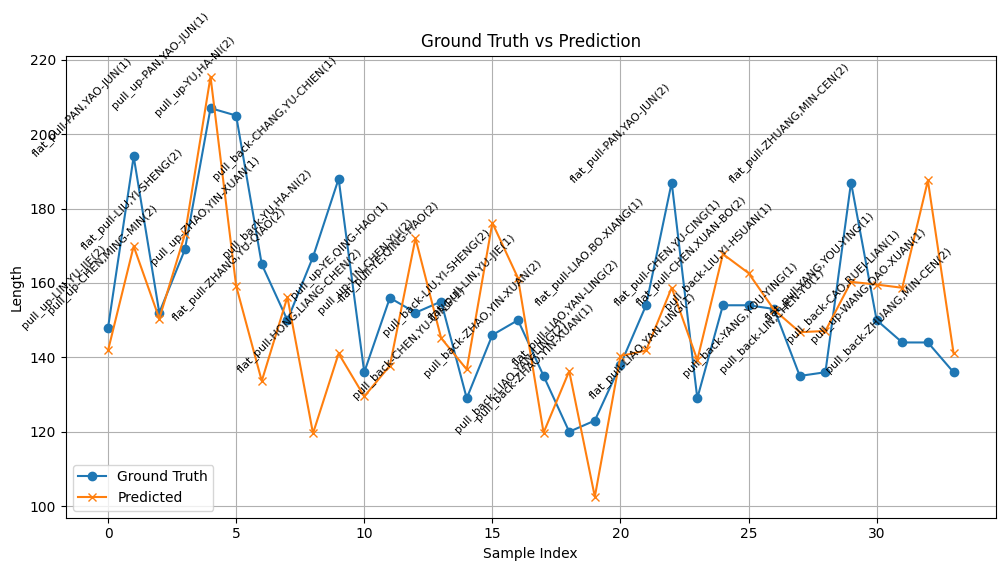

In [29]:
def read_time_series_csv_as_one_row(csv_path, agg_mode="mean"):
    """
    讀取多行的時序 CSV，並將其壓成一列特徵。
    agg_mode 可選 "mean", "median", "max", "min", "last" 等聚合方式。
    回傳一個 pandas.Series，每個欄位對應聚合後的值。
    """
    import pandas as pd
    df_temp = pd.read_csv(csv_path)

    if len(df_temp) == 0:
        # 若檔案是空的，回傳一個空 Series 或全 0 也行
        return pd.Series(dtype=float)

    if agg_mode == "mean":
        if "file_name" in df_temp.columns:
            df_temp.drop("file_name", axis=1, inplace=True)
        row_series = df_temp.mean(axis=0)
    elif agg_mode == "median":
        if "file_name" in df_temp.columns:
            df_temp.drop("file_name", axis=1, inplace=True)
        row_series = df_temp.median(axis=0)
    elif agg_mode == "max":
        if "file_name" in df_temp.columns:
            df_temp.drop("file_name", axis=1, inplace=True)
        row_series = df_temp.max(axis=0)
    elif agg_mode == "min":
        if "file_name" in df_temp.columns:
            df_temp.drop("file_name", axis=1, inplace=True)
        row_series = df_temp.min(axis=0)
    elif agg_mode == "last":
        # 取最後一行
        if "file_name" in df_temp.columns:
            df_temp.drop("file_name", axis=1, inplace=True)
        row_series = df_temp.iloc[-1]
    else:
        row_series = df_temp.mean(axis=0)
    
    return row_series

def read_csv_and_excel(csv_folder, excel_path,
                       name_col="NAME", length_col="length",
                       source_name="flat_pull",
                       agg_mode="mean"):  # 新增參數 agg_mode
    """
    讀取某個資料夾 csv_folder 下所有 CSV + 對應的 Excel (excel_path) 中的 NAME 和 length。
    針對每個 CSV, 讀取多行時序後做聚合 (預設取 mean)，壓成 1 列。
    回傳 (df_X, s_name, s_length, s_source)。
    """
    import os
    import pandas as pd

    # 讀取 Excel
    df_excel = pd.read_excel(excel_path)
    s_name = df_excel[name_col]      # Series of NAME
    s_length = df_excel[length_col]  # Series of length

    # 列出並排序 csv
    csv_files = sorted([
        f for f in os.listdir(csv_folder) 
        if f.lower().endswith(".csv")
    ])

    if len(csv_files) != len(df_excel):
        print(f"[警告] CSV 檔數 ({len(csv_files)}) 與 {excel_path} 筆數 ({len(df_excel)}) 不相符！")

    # =========== 主要修改 ===========
    # 先不收集所有欄位。改成每次聚合後再收集 union。
    # ==============================
    from pathlib import Path
    from collections import OrderedDict
    rows_list = []
    all_columns = set()

    for i, filename in enumerate(csv_files):
        file_path = os.path.join(csv_folder, filename)

        # 讀取多行 CSV -> 聚合成 1 行
        row_series = read_time_series_csv_as_one_row(file_path, agg_mode=agg_mode)

        # 收集欄位
        for c in row_series.index:
            all_columns.add(c)

        rows_list.append(row_series)

    # 將所有欄位排序
    all_columns = sorted(all_columns)

    # 建立 df_X, 每一列對應一個 CSV
    # 先全部補 0
    final_rows = []
    for row_series in rows_list:
        row_dict = {col: 0 for col in all_columns}
        for c in row_series.index:
            row_dict[c] = row_series[c]
        final_rows.append(row_dict)

    df_X = pd.DataFrame(final_rows, columns=all_columns)

    # 如果有 file_name 欄，可以去除 (視實際情況)
    if "file_name" in df_X.columns:
        df_X.drop("file_name", axis=1, inplace=True)

    # 建立一個 s_source
    s_source = pd.Series([source_name]*len(df_X), index=df_X.index)

    print(f"=== 已讀取(多行->聚合): {csv_folder}, Excel: {excel_path}, source={source_name} ===")
    print(f"df_X.shape = {df_X.shape}; s_name.shape={s_name.shape}, s_length.shape={s_length.shape}")

    return df_X, s_name, s_length, s_source
# 假設三組資料:
dfX_flat, name_flat, length_flat, source_flat = read_csv_and_excel(
    csv_folder="flat_pull_output_csvs",
    excel_path="flat_pull.xlsx",
    name_col="NAME",
    length_col="length",
    source_name="flat_pull",
    agg_mode="max"  # or "last", "max", "min", ...
)

dfX_back, name_back, length_back, source_back = read_csv_and_excel(
    csv_folder="pull_back_output_csvs",
    excel_path="pull_back.xlsx",
    name_col="NAME",
    length_col="length",
    source_name="pull_back",
    agg_mode="max"
)

dfX_up, name_up, length_up, source_up = read_csv_and_excel(
    csv_folder="pull_up_output_csvs",
    excel_path="pull_up.xlsx",
    name_col="NAME",
    length_col="length",
    source_name="pull_up",
    agg_mode="min"
)

# ...以下同你的程式...
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error

all_cols_3 = set(dfX_flat.columns).union(dfX_back.columns).union(dfX_up.columns)
all_cols_3 = sorted(all_cols_3)

def align_columns(df, all_cols):
    rows = []
    for i in range(len(df)):
        row_dict = {c: 0 for c in all_cols}
        for c in df.columns:
            row_dict[c] = df.iloc[i][c]
        rows.append(row_dict)
    return pd.DataFrame(rows, columns=all_cols)

dfX_flat_aligned = align_columns(dfX_flat, all_cols_3)
dfX_back_aligned = align_columns(dfX_back, all_cols_3)
dfX_up_aligned   = align_columns(dfX_up, all_cols_3)

dfX_all = pd.concat([dfX_flat_aligned, dfX_back_aligned, dfX_up_aligned],
                    axis=0, ignore_index=True)

s_name_all   = pd.concat([name_flat, name_back, name_up], axis=0, ignore_index=True)
s_length_all = pd.concat([length_flat, length_back, length_up], axis=0, ignore_index=True)
s_source_all = pd.concat([source_flat, source_back, source_up], axis=0, ignore_index=True)

print("dfX_all shape:", dfX_all.shape)
print("s_name_all len:", len(s_name_all))
print("s_length_all len:", len(s_length_all))
print("s_source_all len:", len(s_source_all))


# train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

X_train, X_test, length_train, length_test, name_train, name_test, source_train, source_test = train_test_split(
    dfX_all, s_length_all, s_name_all, s_source_all,
    test_size=0.2,
    random_state=42
)

print("Train size:", len(X_train), len(length_train), len(name_train), len(source_train))
print("Test  size:", len(X_test), len(length_test), len(name_test), len(source_test))

model = LinearRegression()
model.fit(X_train, length_train)
score = model.score(X_test, length_test)
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(length_test, y_pred))
print("R^2 on test:", score)
print("RMSE", rmse)

y_pred = model.predict(X_test)

for i in range(len(X_test)):
    print(f"Source={source_test.iloc[i]}, "
          f"Name={name_test.iloc[i]}, "
          f"Ground truth={length_test.iloc[i]}, "
          f"Predict={y_pred[i]}")


import matplotlib.pyplot as plt

# 可視化 Ground Truth 與 預測值
def visualize_predictions(y_true, y_pred, source_test, name_test):
    plt.figure(figsize=(12, 6))
    plt.plot(y_true, label='Ground Truth', marker='o')
    plt.plot(y_pred, label='Predicted', marker='x')
    
    for i, (source, name) in enumerate(zip(source_test, name_test)):
        plt.text(i, y_true[i], f'{source}-{name}', fontsize=8, rotation=45, ha='right')

    plt.title('Ground Truth vs Prediction')
    plt.xlabel('Sample Index')
    plt.ylabel('Length')
    plt.legend()
    plt.grid(True)
    plt.show()
visualize_predictions(length_test.values, y_pred, source_test.values, name_test.values)


In [30]:
class MoveNetPreprocessor(object):
    """Simplified MoveNet Preprocessor without subfolders."""

    def __init__(self, images_in_folder, images_out_folder, csvs_out_path):
        """
        Args:
            images_in_folder: 存放輸入圖片的資料夾。
            images_out_folder: 存放偵測後圖片的資料夾。
            csvs_out_path: 存放關節點資料的 CSV 檔案路徑。
        """
        if not os.path.exists(images_in_folder):
            os.makedirs(images_in_folder)

        self._images_in_folder = images_in_folder
        self._images_out_folder = images_out_folder
        self._csvs_out_path = csvs_out_path
        self._messages = []

        os.makedirs(self._images_out_folder, exist_ok=True)
        os.makedirs(os.path.dirname(self._csvs_out_path), exist_ok=True)

        # 取得所有圖片檔案名稱 (.jpg, .png)


    def process(self, detection_threshold=0.1):
        """處理所有圖片，進行姿勢偵測並輸出結果到圖片和 CSV。"""
        print("🚀 開始處理圖片...")

        self._image_names = sorted([
            f for f in os.listdir(self._images_in_folder)
            if f.lower().endswith(('.jpg', '.jpeg', '.png')) and not f.startswith('.')
        ])
        # 建立 CSV 檔案，寫入表頭
        with open(self._csvs_out_path, 'w', newline='') as csv_out_file:
            csv_out_writer = csv.writer(csv_out_file, delimiter=',', quoting=csv.QUOTE_MINIMAL)

            # 表頭：file_name + 每個 keypoint 的 (x, y, score)
            header = ["file_name"]
            for bodypart in BodyPart:
                header += [f"{bodypart.name}_x", f"{bodypart.name}_y", f"{bodypart.name}_score"]
            csv_out_writer.writerow(header)

            valid_image_count = 0

            # 逐張圖片進行姿勢偵測
            for image_name in tqdm.tqdm(self._image_names):
                image_path = os.path.join(self._images_in_folder, image_name)

                # 嘗試讀取圖片
                try:
                    image = tf.io.read_file(image_path)
                    image = tf.io.decode_jpeg(image)
                except Exception as e:
                    self._messages.append(f"❌ Skipped {image_path}. Error: {e}")
                    continue

                # 檢查是否為 RGB 圖片
                if image.shape[-1] != 3:
                    self._messages.append(f"⚠️ Skipped {image_path}. Not RGB.")
                    continue

                # 呼叫偵測函數
                person = detect(image)

                # 檢查信心分數
                min_landmark_score = min([k.score for k in person.keypoints])
                if min_landmark_score < detection_threshold:
                    self._messages.append(f"⚠️ Skipped {image_path}. Low confidence.")
                    continue

                valid_image_count += 1

                # 繪製關節點
                output_overlay = draw_prediction_on_image(
                    image.numpy().astype(np.uint8),
                    person,
                    close_figure=True,
                    keep_input_size=True
                )
                output_frame = cv2.cvtColor(output_overlay, cv2.COLOR_RGB2BGR)

                # 儲存繪製後的圖片
                output_image_path = os.path.join(self._images_out_folder, image_name)
                cv2.imwrite(output_image_path, output_frame)

                # 取出 keypoint 座標與分數，並寫入 CSV
                pose_landmarks = np.array(
                    [[kp.coordinate.x, kp.coordinate.y, kp.score] for kp in person.keypoints],
                    dtype=np.float32
                )
                coordinates = pose_landmarks.flatten().astype(str).tolist()
                csv_out_writer.writerow([image_name] + coordinates)
            # 4️⃣ 自動刪除 temp_frames
        if os.path.exists(self._images_in_folder):
            shutil.rmtree(self._images_in_folder)
            print(f"✅ 已自動刪除暫存資料夾: {self._images_in_folder}")

        # 結束訊息
        if valid_image_count == 0:
            raise RuntimeError("❌ 沒有找到有效的圖片進行姿勢偵測。")
        else:
            print(f"✅ 處理完成，共處理 {valid_image_count} 張有效圖片。")

        if self._messages:
            print("\n".join(self._messages))


preprocessor = MoveNetPreprocessor(
    images_in_folder='temp_frames',        # 輸入圖片資料夾
    images_out_folder='poses_images_out',   # 偵測後圖片輸出
    csvs_out_path='output_csvs/output_data.csv'  # CSV 輸出
)

In [31]:
import joblib

# 假設已訓練好的 model
model = LinearRegression()
model.fit(X_train, length_train)

# 儲存模型
model_save_path = "trained_model.joblib"
joblib.dump(model, model_save_path)
print(f"模型已儲存至 {model_save_path}")


模型已儲存至 trained_model.joblib


In [32]:
# 載入儲存的模型
loaded_model = joblib.load(model_save_path)
print("模型已成功載入")

# 假設有影片的 csv 檔案 (經過 MoveNet 處理後)
def predict_from_csv(csv_path, model):
    import pandas as pd

    # 讀取 CSV 並處理資料
    df = pd.read_csv(csv_path)
    
    if "file_name" in df.columns:
        df.drop("file_name", axis=1, inplace=True)

    # 聚合多行數據 (取平均)
    feature_vector = df.min(axis=0).values.reshape(1, -1)
    # row_series = df_temp.max(axis=0)

    # 預測
    prediction = model.predict(feature_vector)
    return prediction[0]

# 範例使用
csv_input_path = "output_data.csv"  # 假設這是影片轉換後的 CSV
predicted_value = predict_from_csv(csv_input_path, loaded_model)
print(f"預測結果: {predicted_value}")


模型已成功載入
預測結果: -3809.9492601436787


d:\anaconda3\envs\movenet\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


# 加上身高與體重的立定跳遠

=== 已讀取: flat_pull_output_csvs, Excel: flat_pull.xlsx, source=flat_pull ===
df_X.shape = (56, 53); s_name.shape=(56,), s_length.shape=(56,)
=== 已讀取: pull_back_output_csvs, Excel: pull_back.xlsx, source=pull_back ===
df_X.shape = (56, 53); s_name.shape=(56,), s_length.shape=(56,)
=== 已讀取: pull_up_output_csvs, Excel: pull_up.xlsx, source=pull_up ===
df_X.shape = (56, 53); s_name.shape=(56,), s_length.shape=(56,)
Train size: 134
Test size: 34
R^2 on test: 0.4423202023021561
RMSE: 16.46792475618287
Source=pull_up, Name=LIN,YU-JIE(2), Ground truth=148, Predict=145.4467309964091
Source=flat_pull, Name=PAN,YAO-JUN(1), Ground truth=194, Predict=171.84526354693685
Source=pull_up, Name=CHEN,MING-MIN(2), Ground truth=152, Predict=135.62445226407692
Source=flat_pull, Name=LIU,YI-SHENG(2), Ground truth=169, Predict=175.74609005525687
Source=pull_up, Name=PAN,YAO-JUN(1), Ground truth=207, Predict=186.14102756152795
Source=pull_up, Name=YU,HA-NI(2), Ground truth=205, Predict=187.89610618767745
Source

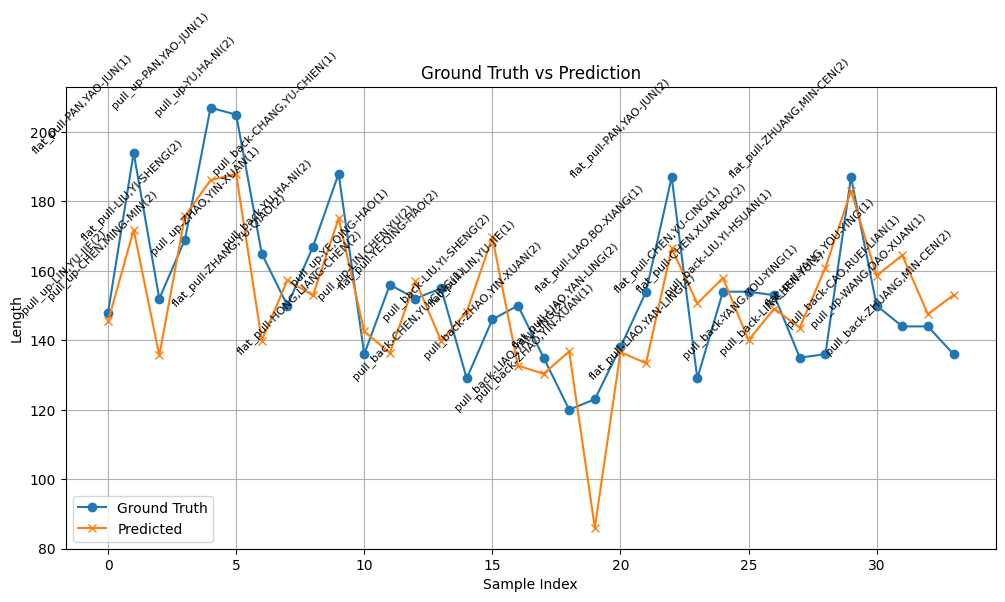

In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# 讀取時序 CSV 並聚合為一列
def read_time_series_csv_as_one_row(csv_path, agg_mode="mean"):
    df_temp = pd.read_csv(csv_path)

    if len(df_temp) == 0:
        return pd.Series(dtype=float)

    if "file_name" in df_temp.columns:
        df_temp.drop("file_name", axis=1, inplace=True)

    if agg_mode == "mean":
        row_series = df_temp.mean(axis=0)
    elif agg_mode == "median":
        row_series = df_temp.median(axis=0)
    elif agg_mode == "max":
        row_series = df_temp.max(axis=0)
    elif agg_mode == "min":
        row_series = df_temp.min(axis=0)
    elif agg_mode == "last":
        row_series = df_temp.iloc[-1]
    else:
        row_series = df_temp.mean(axis=0)

    return row_series

# 讀取 CSV + Excel 數據
def read_csv_and_excel(csv_folder, excel_path,
                       name_col="NAME", length_col="length",
                       height_col="height", weight_col="weight",  
                       source_name="flat_pull",
                       agg_mode="mean"):

    df_excel = pd.read_excel(excel_path)
    s_name = df_excel[name_col]      
    s_length = df_excel[length_col]  
    s_height = df_excel[height_col]  
    s_weight = df_excel[weight_col]  

    csv_files = sorted([
        f for f in os.listdir(csv_folder) 
        if f.lower().endswith(".csv")
    ])

    if len(csv_files) != len(df_excel):
        print(f"[警告] CSV 檔數 ({len(csv_files)}) 與 {excel_path} 筆數 ({len(df_excel)}) 不相符！")

    rows_list = []
    all_columns = set()

    for i, filename in enumerate(csv_files):
        file_path = os.path.join(csv_folder, filename)
        row_series = read_time_series_csv_as_one_row(file_path, agg_mode=agg_mode)

        for c in row_series.index:
            all_columns.add(c)

        row_series["height"] = s_height.iloc[i]
        row_series["weight"] = s_weight.iloc[i]

        rows_list.append(row_series)

    all_columns = sorted(all_columns) + ["height", "weight"]  

    final_rows = []
    for row_series in rows_list:
        row_dict = {col: 0 for col in all_columns}
        for c in row_series.index:
            row_dict[c] = row_series[c]
        final_rows.append(row_dict)

    df_X = pd.DataFrame(final_rows, columns=all_columns)

    if "file_name" in df_X.columns:
        df_X.drop("file_name", axis=1, inplace=True)

    s_source = pd.Series([source_name] * len(df_X), index=df_X.index)

    print(f"=== 已讀取: {csv_folder}, Excel: {excel_path}, source={source_name} ===")
    print(f"df_X.shape = {df_X.shape}; s_name.shape={s_name.shape}, s_length.shape={s_length.shape}")

    return df_X, s_name, s_length, s_source

# 讀取三組資料
dfX_flat, name_flat, length_flat, source_flat = read_csv_and_excel(
    csv_folder="flat_pull_output_csvs",
    excel_path="flat_pull.xlsx",
    name_col="NAME",
    length_col="length",
    height_col="height",
    weight_col="weight",
    source_name="flat_pull",
    agg_mode="max"
)

dfX_back, name_back, length_back, source_back = read_csv_and_excel(
    csv_folder="pull_back_output_csvs",
    excel_path="pull_back.xlsx",
    name_col="NAME",
    length_col="length",
    height_col="height",
    weight_col="weight",
    source_name="pull_back",
    agg_mode="max"
)

dfX_up, name_up, length_up, source_up = read_csv_and_excel(
    csv_folder="pull_up_output_csvs",
    excel_path="pull_up.xlsx",
    name_col="NAME",
    length_col="length",
    height_col="height",
    weight_col="weight",
    source_name="pull_up",
    agg_mode="max"
)

# 統一欄位
all_cols_3 = set(dfX_flat.columns).union(dfX_back.columns).union(dfX_up.columns)
all_cols_3 = sorted(all_cols_3)

def align_columns(df, all_cols):
    rows = []
    for i in range(len(df)):
        row_dict = {c: 0 for c in all_cols}
        for c in df.columns:
            row_dict[c] = df.iloc[i][c]
        rows.append(row_dict)
    return pd.DataFrame(rows, columns=all_cols)

dfX_flat_aligned = align_columns(dfX_flat, all_cols_3)
dfX_back_aligned = align_columns(dfX_back, all_cols_3)
dfX_up_aligned   = align_columns(dfX_up, all_cols_3)

dfX_all = pd.concat([dfX_flat_aligned, dfX_back_aligned, dfX_up_aligned], axis=0, ignore_index=True)

s_name_all   = pd.concat([name_flat, name_back, name_up], axis=0, ignore_index=True)
s_length_all = pd.concat([length_flat, length_back, length_up], axis=0, ignore_index=True)
s_source_all = pd.concat([source_flat, source_back, source_up], axis=0, ignore_index=True)

# train_test_split
X_train, X_test, length_train, length_test, name_train, name_test, source_train, source_test = train_test_split(
    dfX_all, s_length_all, s_name_all, s_source_all,
    test_size=0.2,
    random_state=42
)

print("Train size:", len(X_train))
print("Test size:", len(X_test))

# 訓練模型
model = LinearRegression()
model.fit(X_train, length_train)


# 儲存模型
model_save_path = "trained_model.joblib"
joblib.dump(model, model_save_path)

# 評估模型
score = model.score(X_test, length_test)
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(length_test, y_pred))
print("R^2 on test:", score)
print("RMSE:", rmse)

# 預測結果
for i in range(len(X_test)):
    print(f"Source={source_test.iloc[i]}, "
          f"Name={name_test.iloc[i]}, "
          f"Ground truth={length_test.iloc[i]}, "
          f"Predict={y_pred[i]}")

# 可視化
def visualize_predictions(y_true, y_pred, source_test, name_test):
    plt.figure(figsize=(12, 6))
    plt.plot(y_true, label='Ground Truth', marker='o')
    plt.plot(y_pred, label='Predicted', marker='x')
    
    for i, (source, name) in enumerate(zip(source_test, name_test)):
        plt.text(i, y_true[i], f'{source}-{name}', fontsize=8, rotation=45, ha='right')

    plt.title('Ground Truth vs Prediction')
    plt.xlabel('Sample Index')
    plt.ylabel('Length')
    plt.legend()
    plt.grid(True)
    plt.show()

visualize_predictions(length_test.values, y_pred, source_test.values, name_test.values)


=== 已讀取: flat_pull_output_csvs, Excel: flat_pull.xlsx, source=flat_pull ===
df_X.shape = (56, 53); s_name.shape=(56,), s_length.shape=(56,)
=== 已讀取: pull_back_output_csvs, Excel: pull_back.xlsx, source=pull_back ===
df_X.shape = (56, 53); s_name.shape=(56,), s_length.shape=(56,)
=== 已讀取: pull_up_output_csvs, Excel: pull_up.xlsx, source=pull_up ===
df_X.shape = (56, 53); s_name.shape=(56,), s_length.shape=(56,)
     LEFT_ANKLE_score  LEFT_ANKLE_x  LEFT_ANKLE_y  LEFT_EAR_score  LEFT_EAR_x  \
0           -0.812565     -1.390723     -0.331688        0.676633   -0.847335   
1           -0.174086     -1.390723     -1.083490        0.341525   -0.660459   
2           -0.146541      0.536539      0.390042        0.196690    0.262237   
3           -0.331608      0.367252      1.893646       -0.102077    0.098721   
4            0.794709      0.354230      0.540402        0.316482    0.133760   
..                ...           ...           ...             ...         ...   
163          1.4312

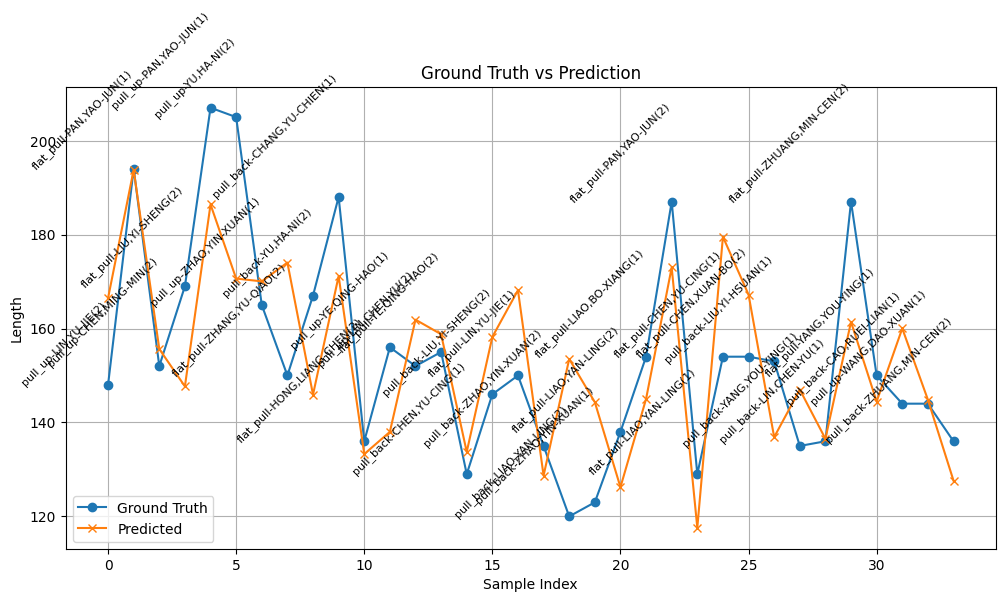

In [47]:
import os
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 讀取時序 CSV 並聚合為一列
def read_time_series_csv_as_one_row(csv_path, agg_mode="mean"):
    df_temp = pd.read_csv(csv_path)

    if len(df_temp) == 0:
        return pd.Series(dtype=float)

    if "file_name" in df_temp.columns:
        df_temp.drop("file_name", axis=1, inplace=True)

    if agg_mode == "mean":
        row_series = df_temp.mean(axis=0)
    elif agg_mode == "median":
        row_series = df_temp.median(axis=0)
    elif agg_mode == "max":
        row_series = df_temp.max(axis=0)
    elif agg_mode == "min":
        row_series = df_temp.min(axis=0)
    elif agg_mode == "last":
        row_series = df_temp.iloc[-1]
    else:
        row_series = df_temp.mean(axis=0)

    return row_series

# 讀取 CSV + Excel 數據
def read_csv_and_excel(csv_folder, excel_path,
                       name_col="NAME", length_col="length",
                       height_col="height", weight_col="weight",  
                       source_name="flat_pull",
                       agg_mode="mean"):

    df_excel = pd.read_excel(excel_path)
    s_name = df_excel[name_col]      
    s_length = df_excel[length_col]  
    s_height = df_excel[height_col]  
    s_weight = df_excel[weight_col]  

    csv_files = sorted([
        f for f in os.listdir(csv_folder) 
        if f.lower().endswith(".csv")
    ])

    if len(csv_files) != len(df_excel):
        print(f"[警告] CSV 檔數 ({len(csv_files)}) 與 {excel_path} 筆數 ({len(df_excel)}) 不相符！")

    rows_list = []
    all_columns = set()

    for i, filename in enumerate(csv_files):
        file_path = os.path.join(csv_folder, filename)
        row_series = read_time_series_csv_as_one_row(file_path, agg_mode=agg_mode)

        for c in row_series.index:
            all_columns.add(c)

        row_series["height"] = s_height.iloc[i]
        row_series["weight"] = s_weight.iloc[i]

        rows_list.append(row_series)

    all_columns = sorted(all_columns) + ["height", "weight"]  

    final_rows = []
    for row_series in rows_list:
        row_dict = {col: 0 for col in all_columns}
        for c in row_series.index:
            row_dict[c] = row_series[c]
        final_rows.append(row_dict)

    df_X = pd.DataFrame(final_rows, columns=all_columns)

    if "file_name" in df_X.columns:
        df_X.drop("file_name", axis=1, inplace=True)

    s_source = pd.Series([source_name] * len(df_X), index=df_X.index)

    print(f"=== 已讀取: {csv_folder}, Excel: {excel_path}, source={source_name} ===")
    print(f"df_X.shape = {df_X.shape}; s_name.shape={s_name.shape}, s_length.shape={s_length.shape}")

    return df_X, s_name, s_length, s_source

# 讀取三組資料
dfX_flat, name_flat, length_flat, source_flat = read_csv_and_excel(
    csv_folder="flat_pull_output_csvs",
    excel_path="flat_pull.xlsx",
    name_col="NAME",
    length_col="length",
    height_col="height",
    weight_col="weight",
    source_name="flat_pull",
    agg_mode="max"
)

dfX_back, name_back, length_back, source_back = read_csv_and_excel(
    csv_folder="pull_back_output_csvs",
    excel_path="pull_back.xlsx",
    name_col="NAME",
    length_col="length",
    height_col="height",
    weight_col="weight",
    source_name="pull_back",
    agg_mode="max"
)

dfX_up, name_up, length_up, source_up = read_csv_and_excel(
    csv_folder="pull_up_output_csvs",
    excel_path="pull_up.xlsx",
    name_col="NAME",
    length_col="length",
    height_col="height",
    weight_col="weight",
    source_name="pull_up",
    agg_mode="max"
)

# 統一欄位
all_cols_3 = set(dfX_flat.columns).union(dfX_back.columns).union(dfX_up.columns)
all_cols_3 = sorted(all_cols_3)

def align_columns(df, all_cols):
    rows = []
    for i in range(len(df)):
        row_dict = {c: 0 for c in all_cols}
        for c in df.columns:
            row_dict[c] = df.iloc[i][c]
        rows.append(row_dict)
    return pd.DataFrame(rows, columns=all_cols)

dfX_flat_aligned = align_columns(dfX_flat, all_cols_3)
dfX_back_aligned = align_columns(dfX_back, all_cols_3)
dfX_up_aligned   = align_columns(dfX_up, all_cols_3)

dfX_all = pd.concat([dfX_flat_aligned, dfX_back_aligned, dfX_up_aligned], axis=0, ignore_index=True)

s_name_all   = pd.concat([name_flat, name_back, name_up], axis=0, ignore_index=True)
s_length_all = pd.concat([length_flat, length_back, length_up], axis=0, ignore_index=True)
s_source_all = pd.concat([source_flat, source_back, source_up], axis=0, ignore_index=True)

# 標準化
scaler = StandardScaler()
dfX_all_scaled = pd.DataFrame(scaler.fit_transform(dfX_all), columns=dfX_all.columns)
print(dfX_all_scaled)

# train_test_split
X_train, X_test, length_train, length_test, name_train, name_test, source_train, source_test = train_test_split(
    dfX_all_scaled, s_length_all, s_name_all, s_source_all,
    test_size=0.2,
    random_state=42
)

print("Train size:", len(X_train))
print("Test size:", len(X_test))

# 訓練模型
model = LinearRegression()
model.fit(X_train, length_train)

# 儲存模型
joblib.dump((model, scaler), "trained_model_with_scaler.joblib")

# 評估模型
score = model.score(X_test, length_test)
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(length_test, y_pred))
print("R^2 on test:", score)
print("RMSE:", rmse)

# 預測結果
for i in range(len(X_test)):
    print(f"Source={source_test.iloc[i]}, "
          f"Name={name_test.iloc[i]}, "
          f"Ground truth={length_test.iloc[i]}, "
          f"Predict={y_pred[i]}")

# 可視化
def visualize_predictions(y_true, y_pred, source_test, name_test):
    plt.figure(figsize=(12, 6))
    plt.plot(y_true, label='Ground Truth', marker='o')
    plt.plot(y_pred, label='Predicted', marker='x')
    
    for i, (source, name) in enumerate(zip(source_test, name_test)):
        plt.text(i, y_true[i], f'{source}-{name}', fontsize=8, rotation=45, ha='right')

    plt.title('Ground Truth vs Prediction')
    plt.xlabel('Sample Index')
    plt.ylabel('Length')
    plt.legend()
    plt.grid(True)
    plt.show()

visualize_predictions(length_test.values, y_pred, source_test.values, name_test.values)


# 目前回歸多模型

=== 已讀取: flat_pull_output_csvs, Excel: flat_pull.xlsx, source=flat_pull ===
df_X.shape = (56, 53); s_length.shape=(56,)
=== 已讀取: pull_back_output_csvs, Excel: pull_back.xlsx, source=pull_back ===
df_X.shape = (56, 53); s_length.shape=(56,)
=== 已讀取: pull_up_output_csvs, Excel: pull_up.xlsx, source=pull_up ===
df_X.shape = (56, 53); s_length.shape=(56,)
Train size: 134
Test size: 34
LinearRegression - R^2: 0.4003, RMSE: 17.0776
Ridge - R^2: 0.4220, RMSE: 16.7658
Lasso - R^2: 0.4458, RMSE: 16.4166


d:\anaconda3\envs\movenet\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.461e+03, tolerance: 7.175e+00
  model = cd_fast.enet_coordinate_descent(


RandomForest - R^2: 0.3472, RMSE: 17.8177
GradientBoosting - R^2: 0.3958, RMSE: 17.1412
SVR - R^2: 0.1705, RMSE: 20.0840
XGBoost - R^2: 0.2213, RMSE: 19.4591
✅ 儲存最佳模型: Lasso


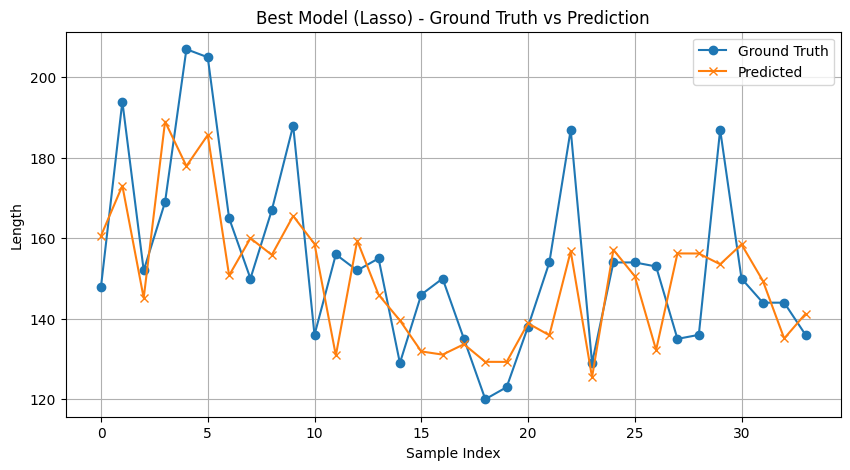

In [73]:
import os
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
import xgboost as xgb

# 讀取時序 CSV 並聚合為一列
def read_time_series_csv_as_one_row(csv_path, agg_mode="mean"):
    df_temp = pd.read_csv(csv_path)
    if len(df_temp) == 0:
        return pd.Series(dtype=float)

    if "file_name" in df_temp.columns:
        df_temp.drop("file_name", axis=1, inplace=True)

    agg_func = {
        "mean": df_temp.mean(axis=0),
        "median": df_temp.median(axis=0),
        "max": df_temp.max(axis=0),
        "min": df_temp.min(axis=0),
        "last": df_temp.iloc[-1]
    }
    return agg_func.get(agg_mode, df_temp.mean(axis=0))

# 讀取 CSV + Excel 數據
def read_csv_and_excel(csv_folder, excel_path,
                       name_col="NAME", length_col="length",
                       height_col="height", weight_col="weight",  
                       source_name="flat_pull",
                       agg_mode="mean"):

    df_excel = pd.read_excel(excel_path)
    s_name, s_length = df_excel[name_col], df_excel[length_col]
    s_height, s_weight = df_excel[height_col], df_excel[weight_col]

    csv_files = sorted([f for f in os.listdir(csv_folder) if f.lower().endswith(".csv")])
    if len(csv_files) != len(df_excel):
        print(f"[警告] CSV 檔數 ({len(csv_files)}) 與 {excel_path} 筆數 ({len(df_excel)}) 不相符！")

    rows_list, all_columns = [], set()
    for i, filename in enumerate(csv_files):
        file_path = os.path.join(csv_folder, filename)
        row_series = read_time_series_csv_as_one_row(file_path, agg_mode=agg_mode)
        all_columns.update(row_series.index)
        row_series["height"], row_series["weight"] = s_height.iloc[i], s_weight.iloc[i]
        rows_list.append(row_series)

    all_columns = sorted(all_columns) + ["height", "weight"]
    df_X = pd.DataFrame([{col: row.get(col, 0) for col in all_columns} for row in rows_list])
    s_source = pd.Series([source_name] * len(df_X), index=df_X.index)

    print(f"=== 已讀取: {csv_folder}, Excel: {excel_path}, source={source_name} ===")
    print(f"df_X.shape = {df_X.shape}; s_length.shape={s_length.shape}")

    return df_X, s_name, s_length, s_source

# 讀取三組資料
dfX_flat, name_flat, length_flat, source_flat = read_csv_and_excel(
    "flat_pull_output_csvs", "flat_pull.xlsx", "NAME", "length", "height", "weight", "flat_pull"
)
dfX_back, name_back, length_back, source_back = read_csv_and_excel(
    "pull_back_output_csvs", "pull_back.xlsx", "NAME", "length", "height", "weight", "pull_back"
)
dfX_up, name_up, length_up, source_up = read_csv_and_excel(
    "pull_up_output_csvs", "pull_up.xlsx", "NAME", "length", "height", "weight", "pull_up"
)

# 統一欄位
all_cols_3 = sorted(set(dfX_flat.columns).union(dfX_back.columns).union(dfX_up.columns))

def align_columns(df, all_cols):
    return pd.DataFrame([{c: df.iloc[i][c] if c in df.columns else 0 for c in all_cols} for i in range(len(df))])

dfX_all = pd.concat([align_columns(dfX_flat, all_cols_3), align_columns(dfX_back, all_cols_3), align_columns(dfX_up, all_cols_3)], axis=0, ignore_index=True)
s_length_all = pd.concat([length_flat, length_back, length_up], axis=0, ignore_index=True)

# 標準化
scaler = StandardScaler()
dfX_all_scaled = pd.DataFrame(scaler.fit_transform(dfX_all), columns=dfX_all.columns)

# 分割訓練/測試集
X_train, X_test, y_train, y_test = train_test_split(dfX_all_scaled, s_length_all, test_size=0.2, random_state=42)

print("Train size:", len(X_train))
print("Test size:", len(X_test))

# 多種回歸模型
models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.01),
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
    "GradientBoosting": GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42),
    "SVR": SVR(kernel='rbf', C=1.0, epsilon=0.1),
    "XGBoost": xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, objective="reg:squarederror", random_state=42)
}

best_model, best_rmse = None, float("inf")
model_results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = model.score(X_test, y_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    model_results[name] = (r2, rmse)
    
    print(f"{name} - R^2: {r2:.4f}, RMSE: {rmse:.4f}")

    if rmse < best_rmse:
        best_model, best_rmse = model, rmse
        best_model_name = name

# 儲存最佳模型
joblib.dump((best_model, scaler), "best_trained_model.joblib")
print(f"✅ 儲存最佳模型: {best_model_name}")

# 可視化
def visualize_predictions(y_true, y_pred, title):
    plt.figure(figsize=(10, 5))
    plt.plot(y_true, label='Ground Truth', marker='o')
    plt.plot(y_pred, label='Predicted', marker='x')
    # for i, (source, name) in enumerate(zip(source_test, name_test)):
    #     plt.text(i, y_true[i], f'{source}-{name}', fontsize=8, rotation=45, ha='right')
    plt.title(f'{title} - Ground Truth vs Prediction')
    plt.xlabel('Sample Index')
    plt.ylabel('Length')
    plt.legend()
    plt.grid(True)
    plt.show()

y_pred_best = best_model.predict(X_test)
visualize_predictions(y_test.values, y_pred_best, f"Best Model ({best_model_name})")



=== 已讀取: flat_pull_output_csvs, Excel: flat_pull.xlsx, source=flat_pull ===
df_X.shape = (56, 70); s_length.shape = (56,)

=== 已讀取: pull_back_output_csvs, Excel: pull_back.xlsx, source=pull_back ===
df_X.shape = (56, 70); s_length.shape = (56,)

=== 已讀取: pull_up_output_csvs, Excel: pull_up.xlsx, source=pull_up ===
df_X.shape = (56, 70); s_length.shape = (56,)

==== 最終 dfX_all 的欄位 ====
dfX_all.shape = (168, 70)
前幾個欄位： ['LEFT_ANKLE_score', 'LEFT_ANKLE_x', 'LEFT_ANKLE_y', 'LEFT_EAR_score', 'LEFT_EAR_x', 'LEFT_EAR_y', 'LEFT_ELBOW_score', 'LEFT_ELBOW_x', 'LEFT_ELBOW_y', 'LEFT_EYE_score', 'LEFT_EYE_x', 'LEFT_EYE_y', 'LEFT_HIP_score', 'LEFT_HIP_x', 'LEFT_HIP_y', 'LEFT_KNEE_score', 'LEFT_KNEE_x', 'LEFT_KNEE_y', 'LEFT_SHOULDER_score', 'LEFT_SHOULDER_x', 'LEFT_SHOULDER_y', 'LEFT_WRIST_score', 'LEFT_WRIST_x', 'LEFT_WRIST_y', 'NOSE_score', 'NOSE_x', 'NOSE_y', 'RIGHT_ANKLE_score', 'RIGHT_ANKLE_x', 'RIGHT_ANKLE_y']

Train size: 134
Test size: 34
LinearRegression - R^2: 0.4331, RMSE: 16.6041
Ridge -

d:\anaconda3\envs\movenet\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.914e+03, tolerance: 7.175e+00
  model = cd_fast.enet_coordinate_descent(


RandomForest - R^2: 0.3460, RMSE: 17.8331
GradientBoosting - R^2: 0.3870, RMSE: 17.2659
SVR - R^2: 0.1664, RMSE: 20.1337
XGBoost - R^2: 0.4330, RMSE: 16.6051
✅ 儲存最佳模型: Lasso


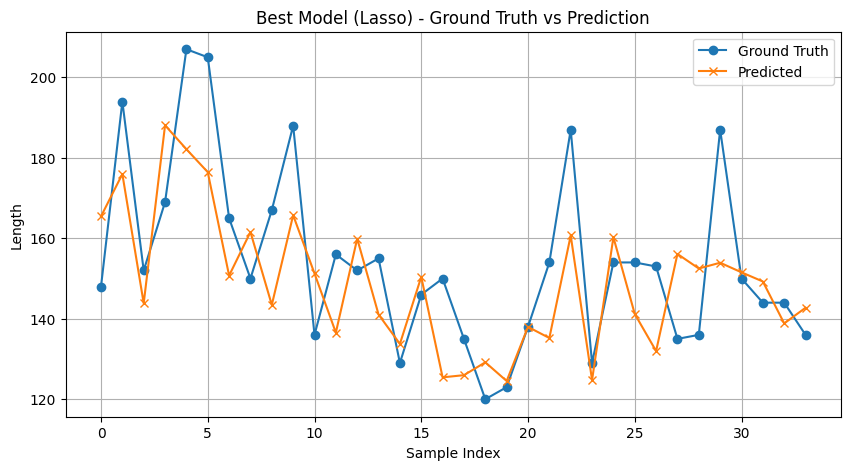

In [87]:
import os
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
import xgboost as xgb

# ==== 1. 定義 17 個關鍵點對應的名稱 (全部大寫 + 底線) ====
BODY_PARTS = [
    "NOSE", "LEFT_EYE", "RIGHT_EYE", "LEFT_EAR", "RIGHT_EAR",
    "LEFT_SHOULDER", "RIGHT_SHOULDER", "LEFT_ELBOW", "RIGHT_ELBOW",
    "LEFT_WRIST", "RIGHT_WRIST", "LEFT_HIP", "RIGHT_HIP",
    "LEFT_KNEE", "RIGHT_KNEE", "LEFT_ANKLE", "RIGHT_ANKLE"
]

def compute_rms_features(df_temp):
    """
    計算 17 個關鍵點的動作劇烈程度(RMS)，每個關節產生一個新特徵。
    注意此處我們假設 CSV 裏的欄位名稱與 BODY_PARTS 對應。
    e.g. NOSE_x, NOSE_y, NOSE_score, LEFT_EYE_x, LEFT_EYE_y, ...
    """
    rms_dict = {}

    for part in BODY_PARTS:
        x_col = f"{part}_x"
        y_col = f"{part}_y"
        # 如果 CSV 缺少某些欄位，就跳過
        if x_col not in df_temp.columns or y_col not in df_temp.columns:
            continue
        
        # 取得連續幀差分 (速度)
        dx = df_temp[x_col].diff().fillna(0)
        dy = df_temp[y_col].diff().fillna(0)
        speed = np.sqrt(dx**2 + dy**2)

        # 計算 RMS (Root Mean Square of speed)
        # RMS = sqrt( mean( speed^2 ) )
        rms_val = np.sqrt(np.mean(speed**2))
        # 新增一個特徵名稱，如 RMS_NOSE, RMS_LEFT_EYE, ...
        rms_dict[f"RMS_{part}"] = rms_val

    return rms_dict

# 2. 讀取單一 CSV，將整個影片時序聚合為一列
def read_time_series_csv_as_one_row(csv_path, agg_mode="mean"):
    df_temp = pd.read_csv(csv_path)
    if len(df_temp) == 0:
        return pd.Series(dtype=float)

    # 如有 file_name 欄，就刪除
    if "file_name" in df_temp.columns:
        df_temp.drop("file_name", axis=1, inplace=True)

    # === (1) 做原本聚合：mean / max / min / last / median ===
    agg_func_dict = {
        "mean": df_temp.mean(axis=0),
        "median": df_temp.median(axis=0),
        "max": df_temp.max(axis=0),
        "min": df_temp.min(axis=0),
        "last": df_temp.iloc[-1]
    }
    # 假設預設用 mean
    row_series = agg_func_dict.get(agg_mode, df_temp.mean(axis=0))

    # === (2) 計算 17 個關鍵點的 RMS 特徵 ===
    rms_dict = compute_rms_features(df_temp)

    # === (3) 將 RMS 特徵一起放到回傳的 row_series 中 ===
    for k, v in rms_dict.items():
        row_series[k] = v

    return row_series

# 3. 讀取 CSV + Excel 數據，並合併
def read_csv_and_excel(csv_folder, excel_path,
                       name_col="NAME", length_col="length",
                       height_col="height", weight_col="weight",
                       source_name="flat_pull",
                       agg_mode="mean"):

    # (A) 讀取 Excel
    df_excel = pd.read_excel(excel_path)
    s_name   = df_excel[name_col]   # e.g. Person's Name
    s_length = df_excel[length_col] # e.g. "length"
    s_height = df_excel[height_col]
    s_weight = df_excel[weight_col]

    # (B) 讀取並排序 CSV 名稱
    csv_files = sorted([f for f in os.listdir(csv_folder) if f.lower().endswith(".csv")])
    if len(csv_files) != len(df_excel):
        print(f"[警告] CSV 檔數 ({len(csv_files)}) 與 {excel_path} 筆數 ({len(df_excel)}) 不相符！")

    rows_list   = []
    all_columns = set()

    # (C) 每支 CSV -> 單列
    for i, filename in enumerate(csv_files):
        file_path = os.path.join(csv_folder, filename)
        row_series = read_time_series_csv_as_one_row(file_path, agg_mode=agg_mode)

        # 把 height, weight 也加進來
        row_series["height"] = s_height.iloc[i]
        row_series["weight"] = s_weight.iloc[i]

        # 更新總欄位集合
        all_columns.update(row_series.index)

        rows_list.append(row_series)

    # (D) 統一所有列的欄位 (若沒有的補 0)
    all_columns = sorted(all_columns)
    df_X = pd.DataFrame([{col: row.get(col, 0) for col in all_columns} for row in rows_list])

    # 這裡做個簡單來源資訊 (optional)
    s_source = pd.Series([source_name] * len(df_X), index=df_X.index)

    print(f"\n=== 已讀取: {csv_folder}, Excel: {excel_path}, source={source_name} ===")
    print(f"df_X.shape = {df_X.shape}; s_length.shape = {s_length.shape}")

    return df_X, s_name, s_length, s_source


# === (A) 讀取三組資料 (範例) ===
dfX_flat, name_flat, length_flat, source_flat = read_csv_and_excel(
    "flat_pull_output_csvs", "flat_pull.xlsx", 
    name_col="NAME", 
    length_col="length", 
    height_col="height", 
    weight_col="weight",
    source_name="flat_pull"
)
dfX_back, name_back, length_back, source_back = read_csv_and_excel(
    "pull_back_output_csvs", "pull_back.xlsx", 
    name_col="NAME", 
    length_col="length", 
    height_col="height", 
    weight_col="weight",
    source_name="pull_back"
)
dfX_up, name_up, length_up, source_up = read_csv_and_excel(
    "pull_up_output_csvs", "pull_up.xlsx", 
    name_col="NAME", 
    length_col="length", 
    height_col="height", 
    weight_col="weight",
    source_name="pull_up"
)

# === (B) 統一三組資料的欄位 ===
all_cols_3 = sorted(set(dfX_flat.columns).union(dfX_back.columns).union(dfX_up.columns))

def align_columns(df, all_cols):
    return pd.DataFrame([{c: df.iloc[i][c] if c in df.columns else 0 for c in all_cols} 
                         for i in range(len(df))])

dfX_all = pd.concat([
    align_columns(dfX_flat, all_cols_3),
    align_columns(dfX_back, all_cols_3),
    align_columns(dfX_up, all_cols_3)
], axis=0, ignore_index=True)

s_length_all = pd.concat([length_flat, length_back, length_up], axis=0, ignore_index=True)

# 看看最終欄位是否含有 "RMS_NOSE" 等等
print("\n==== 最終 dfX_all 的欄位 ====")
print(f"dfX_all.shape = {dfX_all.shape}")
print("前幾個欄位：", dfX_all.columns.tolist()[:30])

# === (C) 標準化 ===
scaler = StandardScaler()
dfX_all_scaled = pd.DataFrame(scaler.fit_transform(dfX_all), columns=dfX_all.columns)

# === (D) 分割訓練 / 測試集 ===
X_train, X_test, y_train, y_test = train_test_split(
    dfX_all_scaled, s_length_all, test_size=0.2, random_state=42
)

print("\nTrain size:", len(X_train))
print("Test size:", len(X_test))

# === (E) 多種回歸模型 ===
models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.01),
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
    "GradientBoosting": GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42),
    "SVR": SVR(kernel='rbf', C=1.0, epsilon=0.1),
    "XGBoost": xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, objective="reg:squarederror", random_state=42)
}

best_model, best_rmse = None, float("inf")
best_model_name = None
model_results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = model.score(X_test, y_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    model_results[name] = (r2, rmse)
    
    print(f"{name} - R^2: {r2:.4f}, RMSE: {rmse:.4f}")

    if rmse < best_rmse:
        best_model, best_rmse = model, rmse
        best_model_name = name

# 儲存最佳模型
joblib.dump((best_model, scaler), "best_trained_model.joblib")
print(f"✅ 儲存最佳模型: {best_model_name}")

# === (F) 可視化 ===
def visualize_predictions(y_true, y_pred, title):
    plt.figure(figsize=(10, 5))
    plt.plot(y_true, label='Ground Truth', marker='o')
    plt.plot(y_pred, label='Predicted', marker='x')
    plt.title(f'{title} - Ground Truth vs Prediction')
    plt.xlabel('Sample Index')
    plt.ylabel('Length')
    plt.legend()
    plt.grid(True)
    plt.show()

y_pred_best = best_model.predict(X_test)
visualize_predictions(y_test.values, y_pred_best, f"Best Model ({best_model_name})")


# 目前最最最好基因演算法特徵選擇

=== 已讀取: flat_pull_output_csvs, Excel: flat_pull.xlsx, source=flat_pull ===
df_X.shape = (56, 172); s_length.shape=(56,)
=== 已讀取: pull_back_output_csvs, Excel: pull_back.xlsx, source=pull_back ===
df_X.shape = (56, 172); s_length.shape=(56,)
=== 已讀取: pull_up_output_csvs, Excel: pull_up.xlsx, source=pull_up ===
df_X.shape = (56, 172); s_length.shape=(56,)

Train size=134, Test size=34

[模型: LinearRegression]
  - 5-Fold CV RMSE: [np.float64(24.169246993867603), np.float64(24.910115441363654), np.float64(43.05949407269266), np.float64(34.45428448172939), np.float64(44.31081960292877)]
  - 5-Fold CV 平均 RMSE = 34.1808
  - 集成(5模型平均)在測試集RMSE = 51.1097
  - 單一子模型最佳RMSE = 35.4456 (fold=1)
  => 該模型在測試集的最優分數 = 35.4456

[模型: Ridge]
  - 5-Fold CV RMSE: [np.float64(17.102386079762184), np.float64(18.172421602784215), np.float64(23.112813929102806), np.float64(22.208581650127964), np.float64(22.054018455781993)]
  - 5-Fold CV 平均 RMSE = 20.5300
  - 集成(5模型平均)在測試集RMSE = 30.0436
  - 單一子模型最佳RMSE = 19.9217 

d:\anaconda3\envs\movenet\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.448e+03, tolerance: 4.661e+00
  model = cd_fast.enet_coordinate_descent(
d:\anaconda3\envs\movenet\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.318e+03, tolerance: 6.266e+00
  model = cd_fast.enet_coordinate_descent(
d:\anaconda3\envs\movenet\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.482e+03, toler


[模型: RandomForest]
  - 5-Fold CV RMSE: [np.float64(20.04765239789105), np.float64(15.782189093804213), np.float64(14.787443998203338), np.float64(19.800074541573114), np.float64(15.000828823255581)]
  - 5-Fold CV 平均 RMSE = 17.0836
  - 集成(5模型平均)在測試集RMSE = 16.7072
  - 單一子模型最佳RMSE = 16.3219 (fold=2)
  => 該模型在測試集的最優分數 = 16.3219

[模型: GradientBoosting]
  - 5-Fold CV RMSE: [np.float64(18.73400671134119), np.float64(16.251807377755004), np.float64(14.805023666669324), np.float64(17.118817329447513), np.float64(14.196993916017396)]
  - 5-Fold CV 平均 RMSE = 16.2213
  - 集成(5模型平均)在測試集RMSE = 15.6749
  - 單一子模型最佳RMSE = 15.0035 (fold=2)
  => 該模型在測試集的最優分數 = 15.0035

[模型: SVR]
  - 5-Fold CV RMSE: [np.float64(27.20948979099606), np.float64(15.733715773320741), np.float64(21.86390273591191), np.float64(16.534252735024314), np.float64(19.567012800366935)]
  - 5-Fold CV 平均 RMSE = 20.1817
  - 集成(5模型平均)在測試集RMSE = 20.4561
  - 單一子模型最佳RMSE = 20.3443 (fold=3)
  => 該模型在測試集的最優分數 = 20.3443

[模型: XGBoost]
  - 5-Fold

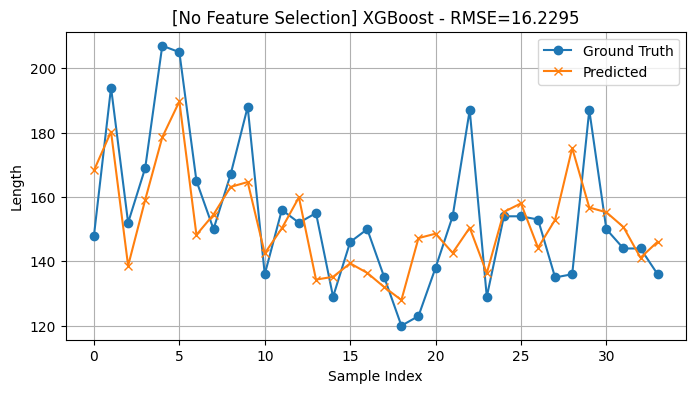

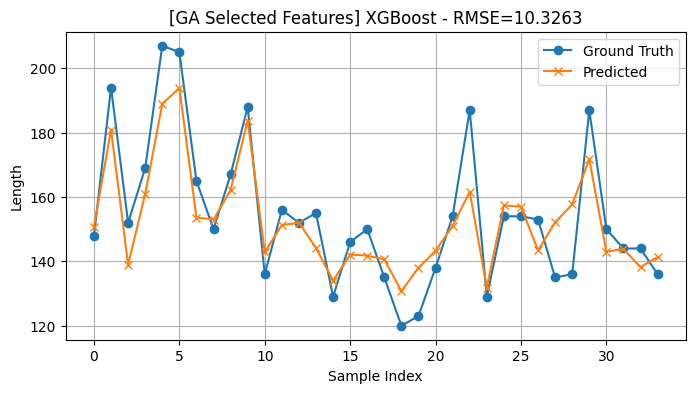

In [141]:
import os
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
import xgboost as xgb

import random

# ---------------------------------------
# 1. 讀取數據 (示範：包含簡單的 RMS 特徵)
# ---------------------------------------
# BODY_PARTS = [
#     "NOSE", "LEFT_EYE", "RIGHT_EYE", "LEFT_EAR", "RIGHT_EAR",
#     "LEFT_SHOULDER", "RIGHT_SHOULDER", "LEFT_ELBOW", "RIGHT_ELBOW",
#     "LEFT_WRIST", "RIGHT_WRIST", "LEFT_HIP", "RIGHT_HIP",
#     "LEFT_KNEE", "RIGHT_KNEE", "LEFT_ANKLE", "RIGHT_ANKLE"
# ]

# def compute_rms_features(df_temp):
#     # 只示範 RMS
#     rms_dict = {}
#     for part in BODY_PARTS:
#         x_col = f"{part}_x"
#         y_col = f"{part}_y"
#         if x_col not in df_temp.columns or y_col not in df_temp.columns:
#             continue
#         dx = df_temp[x_col].diff().fillna(0)
#         dy = df_temp[y_col].diff().fillna(0)
#         speed = np.sqrt(dx**2 + dy**2)
#         rms_val = np.sqrt(np.mean(speed**2))
#         rms_dict[f"RMS_{part}"] = rms_val
#     return rms_dict


BODY_PARTS = [
    "NOSE", "LEFT_EYE", "RIGHT_EYE", "LEFT_EAR", "RIGHT_EAR",
    "LEFT_SHOULDER", "RIGHT_SHOULDER", "LEFT_ELBOW", "RIGHT_ELBOW",
    "LEFT_WRIST", "RIGHT_WRIST", "LEFT_HIP", "RIGHT_HIP",
    "LEFT_KNEE", "RIGHT_KNEE", "LEFT_ANKLE", "RIGHT_ANKLE"
]

def compute_rms_features(df_temp):
    """
    針對每個關節 (part)，計算:
      1) (x_score, y_score) 的平均值
      2) 速度 (speed[t]) = sqrt( dx^2 + dy^2 ), 衍生：
         - 最大值 (max)
         - 最小值 (min)
         - 平均值 (mean)
         - 標準差 (std)
         - 變化率 (roc): 平均( (speed[t+1] - speed[t]) / speed[t] )
    回傳一個 dict，key 例如:
      NOSE_x_score_mean, NOSE_y_score_mean
      RMS_NOSE_max, RMS_NOSE_min, RMS_NOSE_mean, RMS_NOSE_std, RMS_NOSE_roc
    """
    features_dict = {}

    for part in BODY_PARTS:
        x_col = f"{part}_x"
        y_col = f"{part}_y"
        s_col = f"{part}_score"

        # 如果 CSV 缺少某些欄位，就跳過
        if x_col not in df_temp.columns or y_col not in df_temp.columns or s_col not in df_temp.columns:
            continue

        # === (A) part_x_score, part_y_score ===
        # 先計算整段影片的 time-series
        x_score_series = df_temp[x_col] * df_temp[s_col]
        y_score_series = df_temp[y_col] * df_temp[s_col]

        # 取平均值 (你也可改成 max/min/etc.)
        features_dict[f"{part}_x_score_mean"] = x_score_series.mean()
        features_dict[f"{part}_y_score_mean"] = y_score_series.mean()

        # === (B) 計算速度 -> 衍生出 RMS max, min, mean, std, 變化率 ===
        dx = df_temp[x_col].diff().fillna(0)
        dy = df_temp[y_col].diff().fillna(0)
        speed = np.sqrt(dx**2 + dy**2)

        # 速度序列的 max / min / mean / std
        features_dict[f"RMS_{part}_max"] = speed.max()
        features_dict[f"RMS_{part}_min"] = speed.min()
        features_dict[f"RMS_{part}_mean"] = speed.mean()
        features_dict[f"RMS_{part}_std"] = speed.std()

        # 速度變化率 (Rate of Change)，簡單定義為平均( (speed[t+1]-speed[t]) / speed[t] )
        # 注意要防止 speed[t]=0 的情況
        speed_shifted = speed.shift(1)
        valid_mask = (speed_shifted != 0)
        if valid_mask.sum() > 1:
            speed_diff_ratio = (speed - speed_shifted) / (speed_shifted + 1e-8)
            # 只對有效幀做平均
            roc_val = speed_diff_ratio[valid_mask].mean()
        else:
            roc_val = 0.0

        features_dict[f"RMS_{part}_roc"] = roc_val

    return features_dict



def read_time_series_csv_as_one_row(csv_path, agg_mode="mean"):
    df_temp = pd.read_csv(csv_path)
    if len(df_temp) == 0:
        return pd.Series(dtype=float)

    if "file_name" in df_temp.columns:
        df_temp.drop("file_name", axis=1, inplace=True)

    # 基本聚合
    if agg_mode == "mean":
        row_series = df_temp.mean(axis=0)
    elif agg_mode == "median":
        row_series = df_temp.median(axis=0)
    elif agg_mode == "max":
        row_series = df_temp.max(axis=0)
    elif agg_mode == "min":
        row_series = df_temp.min(axis=0)
    elif agg_mode == "last":
        row_series = df_temp.iloc[-1]
    else:
        row_series = df_temp.mean(axis=0)

    # 額外加 RMS 特徵
    rms_dict = compute_rms_features(df_temp)
    for k, v in rms_dict.items():
        row_series[k] = v

    return row_series

def read_csv_and_excel(csv_folder, excel_path,
                       name_col="NAME", length_col="length",
                       height_col="height", weight_col="weight",
                       source_name="flat_pull",
                       agg_mode="mean"):

    df_excel = pd.read_excel(excel_path)
    s_name   = df_excel[name_col]
    s_length = df_excel[length_col]
    s_height = df_excel[height_col]
    s_weight = df_excel[weight_col]

    csv_files = sorted([f for f in os.listdir(csv_folder) if f.lower().endswith(".csv")])
    if len(csv_files) != len(df_excel):
        print(f"[警告] CSV 檔數 ({len(csv_files)}) 與 {excel_path} 筆數 ({len(df_excel)}) 不相符！")

    rows_list   = []
    all_columns = set()

    for i, filename in enumerate(csv_files):
        file_path = os.path.join(csv_folder, filename)
        row_series = read_time_series_csv_as_one_row(file_path, agg_mode=agg_mode)
        # 加入身高、體重
        row_series["height"] = s_height.iloc[i]
        row_series["weight"] = s_weight.iloc[i]
        all_columns.update(row_series.index)
        rows_list.append(row_series)

    all_columns = sorted(all_columns)
    df_X = pd.DataFrame([{col: row.get(col, 0) for col in all_columns} for row in rows_list])
    s_source = pd.Series([source_name]*len(df_X), index=df_X.index)

    print(f"=== 已讀取: {csv_folder}, Excel: {excel_path}, source={source_name} ===")
    print(f"df_X.shape = {df_X.shape}; s_length.shape={s_length.shape}")

    return df_X, s_name, s_length, s_source


# (A) 讀取資料 (範例) ---
dfX_flat, name_flat, length_flat, source_flat = read_csv_and_excel(
    "flat_pull_output_csvs", "flat_pull.xlsx", 
    "NAME", "length", "height", "weight", "flat_pull"
)
dfX_back, name_back, length_back, source_back = read_csv_and_excel(
    "pull_back_output_csvs", "pull_back.xlsx", 
    "NAME", "length", "height", "weight", "pull_back"
)
dfX_up, name_up, length_up, source_up = read_csv_and_excel(
    "pull_up_output_csvs", "pull_up.xlsx", 
    "NAME", "length", "height", "weight", "pull_up"
)

# (B) 統一欄位
all_cols_3 = sorted(set(dfX_flat.columns).union(dfX_back.columns).union(dfX_up.columns))
def align_columns(df, all_cols):
    return pd.DataFrame([{c: df.iloc[i][c] if c in df.columns else 0 for c in all_cols} 
                         for i in range(len(df))])

dfX_all = pd.concat([
    align_columns(dfX_flat, all_cols_3),
    align_columns(dfX_back, all_cols_3),
    align_columns(dfX_up, all_cols_3)
], axis=0, ignore_index=True)

s_length_all = pd.concat([length_flat, length_back, length_up], axis=0, ignore_index=True)

# (C) 標準化
scaler = StandardScaler()
dfX_all_scaled = pd.DataFrame(scaler.fit_transform(dfX_all), columns=dfX_all.columns)

# (D) Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    dfX_all_scaled, s_length_all, test_size=0.2, random_state=42
)

print(f"\nTrain size={len(X_train)}, Test size={len(X_test)}")

# =============================================
# 2. 進行 "5 折交叉驗證" + "集成子模型" 來預測測試集
# =============================================
from sklearn.base import clone

models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.01),
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
    "GradientBoosting": GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42),
    "SVR": SVR(kernel='rbf', C=1.0, epsilon=0.1),
    "XGBoost": xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, objective="reg:squarederror", random_state=42)
}

kf = KFold(n_splits=5, shuffle=True, random_state=42)

best_model_name = None
best_model = None
best_test_rmse = float('inf')

model_cv_info = {}  # 紀錄每個模型的交叉驗證 & 測試資訊

for name, base_model in models.items():
    fold_rmses = []
    fold_models = []  # 放置5個子模型
    # -------------- (A) 5折交叉驗證 --------------
    for train_idx, valid_idx in kf.split(X_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[valid_idx]

        # 複製一份 model
        sub_model = clone(base_model)
        sub_model.fit(X_tr, y_tr)

        # 計算驗證集 RMSE
        y_val_pred = sub_model.predict(X_val)
        val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
        fold_rmses.append(val_rmse)

        fold_models.append(sub_model)

    avg_cv_rmse = np.mean(fold_rmses)

    # -------------- (B) 用 5 個子模型"集成"來預測測試集 --------------
    #    (最簡單做法:  5 個子模型對 X_test 預測，再平均)
    preds_ensemble_list = []
    sub_folds_rmse_list = []  # 紀錄每個子模型的測試 RMSE
    for i, fm in enumerate(fold_models):
        sub_pred_test = fm.predict(X_test)
        sub_rmse_test = np.sqrt(mean_squared_error(y_test, sub_pred_test))
        sub_folds_rmse_list.append(sub_rmse_test)
        preds_ensemble_list.append(sub_pred_test)

    # 簡單平均
    ensemble_preds = np.mean(preds_ensemble_list, axis=0)
    ensemble_rmse_test = np.sqrt(mean_squared_error(y_test, ensemble_preds))

    # 看看「單個子模型」中誰在測試集最好
    best_sub_model_rmse = min(sub_folds_rmse_list)
    best_sub_model_idx = sub_folds_rmse_list.index(best_sub_model_rmse)

    # 取「子模型最佳」 vs 「集成」兩者的最小 RMSE
    best_test_rmse_for_this_model = min(best_sub_model_rmse, ensemble_rmse_test)

    model_cv_info[name] = {
        "cv_rmse_list": fold_rmses,
        "avg_cv_rmse": avg_cv_rmse,
        "sub_models_test_rmse": sub_folds_rmse_list,
        "best_sub_model_rmse": best_sub_model_rmse,
        "best_sub_model_idx": best_sub_model_idx,
        "ensemble_test_rmse": ensemble_rmse_test,
        "best_test_rmse": best_test_rmse_for_this_model
    }

    print(f"\n[模型: {name}]")
    print(f"  - 5-Fold CV RMSE: {fold_rmses}")
    print(f"  - 5-Fold CV 平均 RMSE = {avg_cv_rmse:.4f}")
    print(f"  - 集成(5模型平均)在測試集RMSE = {ensemble_rmse_test:.4f}")
    print(f"  - 單一子模型最佳RMSE = {best_sub_model_rmse:.4f} (fold={best_sub_model_idx})")
    print(f"  => 該模型在測試集的最優分數 = {best_test_rmse_for_this_model:.4f}")

    # -------------- (C) 與全場最佳比較 --------------
    if best_test_rmse_for_this_model < best_test_rmse:
        best_test_rmse = best_test_rmse_for_this_model
        best_model_name = name
        best_model = base_model  # 這裡先記下 base_model (之後還要 GA)

print("\n========== 全部模型的交叉驗證 & 測試情況 ==========")
for m_name, info in model_cv_info.items():
    print(f"\n模型: {m_name}")
    print(f"  CV各fold RMSE: {info['cv_rmse_list']}")
    print(f"  => CV平均RMSE: {info['avg_cv_rmse']:.4f}")
    print(f"  => 集成測試集RMSE: {info['ensemble_test_rmse']:.4f}")
    print(f"  => 單一子模型最佳RMSE: {info['best_sub_model_rmse']:.4f} (fold={info['best_sub_model_idx']})")
    print(f"  => 測試集最優RMSE: {info['best_test_rmse']:.4f}")

print(f"\n[結論] 全部模型中，在測試集表現最好的模型: {best_model_name}, TestRMSE={best_test_rmse:.4f}")

# ===========================================
# 3. （保留原程式）基因演算法 (GA) 針對「最佳模型」做特徵選擇
#    (用 Test RMSE 做 fitness)  <-- 未改動
# ===========================================
def ga_feature_selection_testset(
    X_train, y_train,
    X_test,  y_test,
    model,
    population_size=30,
    n_generations=40,
    crossover_rate=0.8,
    mutation_rate=0.05,
    random_state=42
):
    """
    使用 GA 進行特徵選擇，直接以「測試集 RMSE」作為評估。
    染色體: binary vector (長度=特徵數量)
    適應度: -TestRMSE (越大越好)
    """
    np.random.seed(random_state)
    random.seed(random_state)

    n_features = X_train.shape[1]

    # 初始化族群
    population = []
    for _ in range(population_size):
        chromosome = [random.randint(0, 1) for _ in range(n_features)]
        if sum(chromosome) == 0:
            chromosome[random.randint(0, n_features-1)] = 1
        population.append(chromosome)

    def evaluate_fitness(chromosome):
        # 選出的特徵
        mask = np.array(chromosome, dtype=bool)
        if not np.any(mask):
            return -9999  # 全0是無效
        X_train_sub = X_train.iloc[:, mask]
        X_test_sub  = X_test.iloc[:, mask]

        model.fit(X_train_sub, y_train)
        y_pred_test = model.predict(X_test_sub)
        test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
        # fitness = -RMSE
        return -test_rmse

    best_chromosome = None
    best_fitness = float('-inf')




    # 迭代
    for gen in range(n_generations):
        # 評估族群
        fitness_list = [evaluate_fitness(ch) for ch in population]

        # 找到該代最佳
        gen_best_idx = np.argmax(fitness_list)
        gen_best_fit = fitness_list[gen_best_idx]
        if gen_best_fit > best_fitness:
            best_fitness = gen_best_fit
            best_chromosome = population[gen_best_idx][:]

        # 輸出該代最佳個體
        selected_idx = [i for i,v in enumerate(best_chromosome) if v==1]
        selected_features = X_train.columns[selected_idx]
        print(f"Generation {gen+1}/{n_generations}:")
        print(f"  - Best Fitness = {gen_best_fit:.4f}  (=-TestRMSE)")
        print(f"  - Best Chromosome => Index={selected_idx}")
        print(f"  - Features => {list(selected_features)}")

        # 建立下一代
        new_population = []
        sorted_pop = sorted(zip(population, fitness_list), key=lambda x:x[1], reverse=True)
        elites_num = 5  ##找前5好的菁英
        new_population.extend([chrom for chrom,_ in sorted_pop[:elites_num]])
        while len(new_population) < population_size:
            p1 = tournament_selection(sorted_pop)
            p2 = tournament_selection(sorted_pop)
            if random.random() < crossover_rate:
                c1, c2 = single_point_crossover(p1, p2)
            else:
                c1, c2 = p1[:], p2[:]
            c1 = mutation(c1, mutation_rate)
            c2 = mutation(c2, mutation_rate)
            new_population.append(c1)
            if len(new_population) < population_size:
                new_population.append(c2)
        population = new_population

    return best_chromosome, best_fitness

def tournament_selection(sorted_pop, k=5):
    pick = random.sample(sorted_pop, k)
    pick_sorted = sorted(pick, key=lambda x:x[1], reverse=True)
    return pick_sorted[0][0]

def single_point_crossover(p1, p2):
    point = random.randint(1, len(p1)-1)
    c1 = p1[:point] + p2[point:]
    c2 = p2[:point] + p1[point:]
    return c1, c2

def mutation(chromosome, mutation_rate):
    for i in range(len(chromosome)):
        if random.random() < mutation_rate:
            chromosome[i] = 1 - chromosome[i]
    if sum(chromosome) == 0:
        chromosome[random.randint(0, len(chromosome)-1)] = 1
    return chromosome


# 以「全場最佳模型」來跑 GA
print(f"\n[GA 特徵選擇] 在測試集RMSE最佳的模型: {best_model_name}")
best_chrom, best_fit = ga_feature_selection_testset(
    X_train, y_train,
    X_test, y_test,
    model=best_model,  # 注意：best_model 是該模型的實例
    population_size=100,
    n_generations=100,
    crossover_rate=0.8,
    mutation_rate=0.1,
    random_state=42
)

final_test_rmse = -best_fit
print(f"\nGA 最佳個體對應 test_RMSE = {final_test_rmse:.4f}")

# 重訓練 & 報告結果
best_mask = np.array(best_chrom, dtype=bool)
X_train_best = X_train.loc[:, best_mask]
X_test_best  = X_test.loc[:, best_mask]

best_model.fit(X_train_best, y_train)
y_pred_final = best_model.predict(X_test_best)
rmse_final = np.sqrt(mean_squared_error(y_test, y_pred_final))

print(f"[最終] GA特徵子集在測試集上RMSE = {rmse_final:.4f}")
print("選用的特徵Index =", [i for i,v in enumerate(best_chrom) if v==1])
print("對應特徵名稱 =", X_train.columns[best_mask].tolist())


# (可視化對照)
def visualize_predictions(y_true, y_pred, title):
    plt.figure(figsize=(8,4))
    plt.plot(y_true.values, label="Ground Truth", marker='o')
    plt.plot(y_pred, label="Predicted", marker='x')
    plt.title(title)
    plt.xlabel("Sample Index")
    plt.ylabel("Length")
    plt.legend()
    plt.grid(True)
    plt.show()

# 原始無做特徵選擇 (best_model)
best_model.fit(X_train, y_train)
y_pred_orig = best_model.predict(X_test)
rmse_orig = np.sqrt(mean_squared_error(y_test, y_pred_orig))
visualize_predictions(y_test, y_pred_orig, f"[No Feature Selection] {best_model_name} - RMSE={rmse_orig:.4f}")

# GA 選完特徵
visualize_predictions(y_test, y_pred_final, f"[GA Selected Features] {best_model_name} - RMSE={rmse_final:.4f}")


# 目前最最最好選到的特徵

=== 已讀取: flat_pull_output_csvs, Excel: flat_pull.xlsx, source=flat_pull ===
df_X.shape = (56, 172); s_length.shape=(56,)
=== 已讀取: pull_back_output_csvs, Excel: pull_back.xlsx, source=pull_back ===
df_X.shape = (56, 172); s_length.shape=(56,)
=== 已讀取: pull_up_output_csvs, Excel: pull_up.xlsx, source=pull_up ===
df_X.shape = (56, 172); s_length.shape=(56,)

Train size=134, Test size=34

[模型: LinearRegression]
  - 5-Fold CV RMSE: [np.float64(37.347770320423486), np.float64(27.88481010136292), np.float64(32.33339803821135), np.float64(25.174202422327387), np.float64(30.05974038614377)]
  - 5-Fold CV 平均 RMSE = 30.5600
  - 集成(5模型平均)在測試集 RMSE = 46.6743
  - 單一子模型最佳RMSE = 23.2239 (fold=0)
  => 該模型在測試集的最優分數 = 23.2239

[模型: Ridge]
  - 5-Fold CV RMSE: [np.float64(16.977782295191858), np.float64(14.70210795575747), np.float64(35.02396610134926), np.float64(19.476249392134395), np.float64(16.46454842012156)]
  - 5-Fold CV 平均 RMSE = 20.5289
  - 集成(5模型平均)在測試集 RMSE = 28.2971
  - 單一子模型最佳RMSE = 22.6428 (

d:\anaconda3\envs\movenet\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.061e+03, tolerance: 4.661e+00
  model = cd_fast.enet_coordinate_descent(
d:\anaconda3\envs\movenet\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.311e+03, tolerance: 6.266e+00
  model = cd_fast.enet_coordinate_descent(
d:\anaconda3\envs\movenet\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.613e+03, toler


[模型: RandomForest]
  - 5-Fold CV RMSE: [np.float64(19.722934572424766), np.float64(15.409920085355312), np.float64(15.080484813898467), np.float64(19.55236170257057), np.float64(15.540088604836006)]
  - 5-Fold CV 平均 RMSE = 17.0612
  - 集成(5模型平均)在測試集 RMSE = 16.2117
  - 單一子模型最佳RMSE = 16.0089 (fold=3)
  => 該模型在測試集的最優分數 = 16.0089

[模型: GradientBoosting]
  - 5-Fold CV RMSE: [np.float64(18.210929154944694), np.float64(16.077849574870545), np.float64(16.400948173883222), np.float64(17.484266390982853), np.float64(14.34546769482347)]
  - 5-Fold CV 平均 RMSE = 16.5039
  - 集成(5模型平均)在測試集 RMSE = 14.2127
  - 單一子模型最佳RMSE = 14.0976 (fold=3)
  => 該模型在測試集的最優分數 = 14.0976

[模型: SVR]
  - 5-Fold CV RMSE: [np.float64(27.15380431757465), np.float64(15.719686285798891), np.float64(21.699658771977045), np.float64(16.516064395306703), np.float64(19.501657513273447)]
  - 5-Fold CV 平均 RMSE = 20.1182
  - 集成(5模型平均)在測試集 RMSE = 20.3357
  - 單一子模型最佳RMSE = 20.2450 (fold=4)
  => 該模型在測試集的最優分數 = 20.2450

[模型: XGBoost]
  - 5-

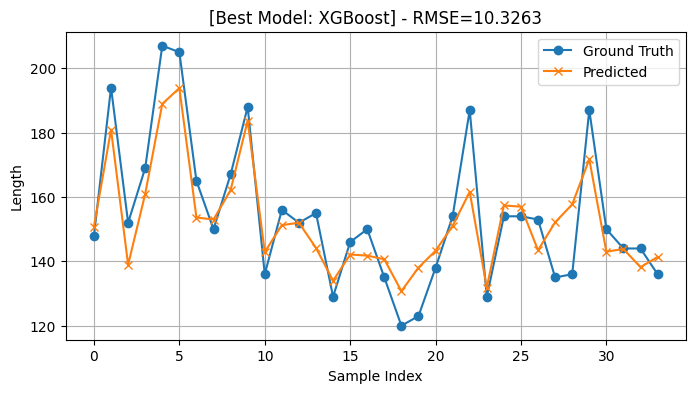

In [132]:
import os
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
import xgboost as xgb

import random

# ---------------------------------------
# 1. 讀取數據 (範例：包含簡單的 RMS 特徵)
# ---------------------------------------
BODY_PARTS = [
    "NOSE", "LEFT_EYE", "RIGHT_EYE", "LEFT_EAR", "RIGHT_EAR",
    "LEFT_SHOULDER", "RIGHT_SHOULDER", "LEFT_ELBOW", "RIGHT_ELBOW",
    "LEFT_WRIST", "RIGHT_WRIST", "LEFT_HIP", "RIGHT_HIP",
    "LEFT_KNEE", "RIGHT_KNEE", "LEFT_ANKLE", "RIGHT_ANKLE"
]

def compute_rms_features(df_temp):
    """
    針對每個關節 (part)，計算:
      1) (x_score, y_score) 的平均值
      2) 速度 (speed[t]) = sqrt( dx^2 + dy^2 ), 衍生：
         - 最大值 (max)
         - 最小值 (min)
         - 平均值 (mean)
         - 標準差 (std)
         - 變化率 (roc): 平均( (speed[t+1] - speed[t]) / speed[t] )
    回傳一個 dict
    """
    features_dict = {}

    for part in BODY_PARTS:
        x_col = f"{part}_x"
        y_col = f"{part}_y"
        s_col = f"{part}_score"

        # 如果 CSV 缺少某些欄位，就跳過
        if x_col not in df_temp.columns or y_col not in df_temp.columns or s_col not in df_temp.columns:
            continue

        # (A) 計算 x_score, y_score 平均值
        x_score_series = df_temp[x_col] * df_temp[s_col]
        y_score_series = df_temp[y_col] * df_temp[s_col]
        features_dict[f"{part}_x_score_mean"] = x_score_series.mean()
        features_dict[f"{part}_y_score_mean"] = y_score_series.mean()

        # (B) 速度 -> 衍生 RMS max, min, mean, std, 變化率
        dx = df_temp[x_col].diff().fillna(0)
        dy = df_temp[y_col].diff().fillna(0)
        speed = np.sqrt(dx**2 + dy**2)

        features_dict[f"RMS_{part}_max"] = speed.max()
        features_dict[f"RMS_{part}_min"] = speed.min()
        features_dict[f"RMS_{part}_mean"] = speed.mean()
        features_dict[f"RMS_{part}_std"] = speed.std()

        speed_shifted = speed.shift(1)
        valid_mask = (speed_shifted != 0)
        if valid_mask.sum() > 1:
            speed_diff_ratio = (speed - speed_shifted) / (speed_shifted + 1e-8)
            roc_val = speed_diff_ratio[valid_mask].mean()
        else:
            roc_val = 0.0

        features_dict[f"RMS_{part}_roc"] = roc_val

    return features_dict

def read_time_series_csv_as_one_row(csv_path, agg_mode="mean"):
    df_temp = pd.read_csv(csv_path)
    if len(df_temp) == 0:
        return pd.Series(dtype=float)

    if "file_name" in df_temp.columns:
        df_temp.drop("file_name", axis=1, inplace=True)

    if agg_mode == "mean":
        row_series = df_temp.mean(axis=0)
    elif agg_mode == "median":
        row_series = df_temp.median(axis=0)
    elif agg_mode == "max":
        row_series = df_temp.max(axis=0)
    elif agg_mode == "min":
        row_series = df_temp.min(axis=0)
    elif agg_mode == "last":
        row_series = df_temp.iloc[-1]
    else:
        row_series = df_temp.mean(axis=0)

    # 額外計算 RMS 特徵
    rms_dict = compute_rms_features(df_temp)
    for k, v in rms_dict.items():
        row_series[k] = v

    return row_series

def read_csv_and_excel(csv_folder, excel_path,
                       name_col="NAME", length_col="length",
                       height_col="height", weight_col="weight",
                       source_name="flat_pull",
                       agg_mode="mean"):

    df_excel = pd.read_excel(excel_path)
    s_name   = df_excel[name_col]
    s_length = df_excel[length_col]
    s_height = df_excel[height_col]
    s_weight = df_excel[weight_col]

    csv_files = sorted([f for f in os.listdir(csv_folder) if f.lower().endswith(".csv")])
    if len(csv_files) != len(df_excel):
        print(f"[警告] CSV 檔數 ({len(csv_files)}) 與 {excel_path} 筆數 ({len(df_excel)}) 不相符！")

    rows_list   = []
    all_columns = set()

    for i, filename in enumerate(csv_files):
        file_path = os.path.join(csv_folder, filename)
        row_series = read_time_series_csv_as_one_row(file_path, agg_mode=agg_mode)
        row_series["height"] = s_height.iloc[i]
        row_series["weight"] = s_weight.iloc[i]
        all_columns.update(row_series.index)
        rows_list.append(row_series)

    all_columns = sorted(all_columns)
    df_X = pd.DataFrame([{col: row.get(col, 0) for col in all_columns} for row in rows_list])
    s_source = pd.Series([source_name]*len(df_X), index=df_X.index)

    print(f"=== 已讀取: {csv_folder}, Excel: {excel_path}, source={source_name} ===")
    print(f"df_X.shape = {df_X.shape}; s_length.shape={s_length.shape}")

    return df_X, s_name, s_length, s_source

# (A) 讀取資料
dfX_flat, name_flat, length_flat, source_flat = read_csv_and_excel(
    "flat_pull_output_csvs", "flat_pull.xlsx",
    "NAME", "length", "height", "weight", "flat_pull"
)
dfX_back, name_back, length_back, source_back = read_csv_and_excel(
    "pull_back_output_csvs", "pull_back.xlsx",
    "NAME", "length", "height", "weight", "pull_back"
)
dfX_up, name_up, length_up, source_up = read_csv_and_excel(
    "pull_up_output_csvs", "pull_up.xlsx",
    "NAME", "length", "height", "weight", "pull_up"
)

# (B) 統一欄位
all_cols_3 = sorted(set(dfX_flat.columns).union(dfX_back.columns).union(dfX_up.columns))

def align_columns(df, all_cols):
    return pd.DataFrame([{c: df.iloc[i][c] if c in df.columns else 0 for c in all_cols}
                         for i in range(len(df))])

dfX_all = pd.concat([
    align_columns(dfX_flat, all_cols_3),
    align_columns(dfX_back, all_cols_3),
    align_columns(dfX_up, all_cols_3)
], axis=0, ignore_index=True)

s_length_all = pd.concat([length_flat, length_back, length_up], axis=0, ignore_index=True)
# selected_features=['LEFT_ANKLE_y', 'LEFT_EAR_score', 'LEFT_EAR_y', 'LEFT_EAR_y_score_mean', 'LEFT_ELBOW_y', 'LEFT_EYE_score', 'LEFT_EYE_x', 'LEFT_EYE_y', 'LEFT_HIP_x', 'LEFT_HIP_x_score_mean', 'LEFT_KNEE_x_score_mean', 'LEFT_SHOULDER_x_score_mean', 'LEFT_WRIST_score', 'LEFT_WRIST_y_score_mean', 'NOSE_score', 'NOSE_x', 'NOSE_x_score_mean', 'NOSE_y', 'RIGHT_ANKLE_x', 'RIGHT_ANKLE_x_score_mean', 'RIGHT_ANKLE_y', 'RIGHT_ANKLE_y_score_mean', 'RIGHT_EAR_y_score_mean', 'RIGHT_ELBOW_score', 'RIGHT_ELBOW_x_score_mean', 'RIGHT_EYE_score', 'RIGHT_HIP_y_score_mean', 'RIGHT_KNEE_x_score_mean', 'RIGHT_KNEE_y', 'RIGHT_KNEE_y_score_mean', 'RIGHT_SHOULDER_score', 'RIGHT_SHOULDER_y_score_mean', 'RIGHT_WRIST_score', 'RIGHT_WRIST_y_score_mean', 'RMS_LEFT_ANKLE_mean', 'RMS_LEFT_ANKLE_min', 'RMS_LEFT_ANKLE_std', 'RMS_LEFT_EAR_max', 'RMS_LEFT_EAR_mean', 'RMS_LEFT_EAR_min', 'RMS_LEFT_EAR_roc', 'RMS_LEFT_EAR_std', 'RMS_LEFT_ELBOW_max', 'RMS_LEFT_EYE_max', 'RMS_LEFT_EYE_mean', 'RMS_LEFT_EYE_std', 'RMS_LEFT_HIP_min', 'RMS_LEFT_KNEE_mean', 'RMS_LEFT_KNEE_min', 'RMS_LEFT_KNEE_std', 'RMS_LEFT_SHOULDER_mean', 'RMS_LEFT_SHOULDER_min', 'RMS_LEFT_WRIST_max', 'RMS_LEFT_WRIST_mean', 'RMS_LEFT_WRIST_roc', 'RMS_LEFT_WRIST_std', 'RMS_NOSE_mean', 'RMS_RIGHT_ANKLE_max', 'RMS_RIGHT_ANKLE_mean', 'RMS_RIGHT_ANKLE_min', 'RMS_RIGHT_ANKLE_std', 'RMS_RIGHT_EAR_mean', 'RMS_RIGHT_EAR_roc', 'RMS_RIGHT_EYE_std', 'RMS_RIGHT_HIP_max', 'RMS_RIGHT_HIP_mean', 'RMS_RIGHT_HIP_roc', 'RMS_RIGHT_HIP_std', 'RMS_RIGHT_KNEE_mean', 'RMS_RIGHT_KNEE_roc', 'RMS_RIGHT_SHOULDER_max', 'RMS_RIGHT_SHOULDER_roc', 'RMS_RIGHT_SHOULDER_std', 'RMS_RIGHT_WRIST_max', 'RMS_RIGHT_WRIST_mean', 'RMS_RIGHT_WRIST_roc', 'height', 'weight']
# selected_features=['LEFT_ANKLE_y', 'LEFT_EAR_score', 'LEFT_EAR_y', 'LEFT_EAR_y_score_mean', 'LEFT_ELBOW_y', 'LEFT_EYE_x', 'LEFT_EYE_y_score_mean', 'LEFT_HIP_x', 'LEFT_HIP_y', 'LEFT_KNEE_x_score_mean', 'LEFT_SHOULDER_score', 'LEFT_SHOULDER_x_score_mean', 'LEFT_WRIST_score', 'LEFT_WRIST_y_score_mean', 'NOSE_score', 'NOSE_y', 'RIGHT_ANKLE_x', 'RIGHT_ANKLE_x_score_mean', 'RIGHT_EAR_score', 'RIGHT_EAR_x_score_mean', 'RIGHT_ELBOW_score', 'RIGHT_ELBOW_x_score_mean', 'RIGHT_EYE_score', 'RIGHT_EYE_y_score_mean', 'RIGHT_HIP_score', 'RIGHT_HIP_y_score_mean', 'RIGHT_KNEE_x_score_mean', 'RIGHT_KNEE_y', 'RIGHT_KNEE_y_score_mean', 'RIGHT_SHOULDER_score', 'RIGHT_SHOULDER_x', 'RIGHT_SHOULDER_y_score_mean', 'RIGHT_WRIST_score', 'RIGHT_WRIST_x', 'RIGHT_WRIST_y_score_mean', 'RMS_LEFT_ANKLE_mean', 'RMS_LEFT_ANKLE_min', 'RMS_LEFT_EAR_mean', 'RMS_LEFT_EAR_roc', 'RMS_LEFT_EAR_std', 'RMS_LEFT_ELBOW_max', 'RMS_LEFT_ELBOW_std', 'RMS_LEFT_EYE_max', 'RMS_LEFT_EYE_mean', 'RMS_LEFT_EYE_std', 'RMS_LEFT_HIP_min', 'RMS_LEFT_KNEE_min', 'RMS_LEFT_KNEE_std', 'RMS_LEFT_SHOULDER_mean', 'RMS_LEFT_SHOULDER_min', 'RMS_LEFT_SHOULDER_std', 'RMS_LEFT_WRIST_max', 'RMS_LEFT_WRIST_mean', 'RMS_LEFT_WRIST_std', 'RMS_NOSE_mean', 'RMS_RIGHT_ANKLE_max', 'RMS_RIGHT_ANKLE_mean', 'RMS_RIGHT_ANKLE_std', 'RMS_RIGHT_EAR_mean', 'RMS_RIGHT_EAR_roc', 'RMS_RIGHT_ELBOW_min', 'RMS_RIGHT_EYE_std', 'RMS_RIGHT_HIP_max', 'RMS_RIGHT_HIP_mean', 'RMS_RIGHT_HIP_roc', 'RMS_RIGHT_HIP_std', 'RMS_RIGHT_KNEE_mean', 'RMS_RIGHT_SHOULDER_roc', 'RMS_RIGHT_SHOULDER_std', 'RMS_RIGHT_WRIST_max', 'RMS_RIGHT_WRIST_roc', 'height', 'weight']
# selected_features=['LEFT_ANKLE_score', 'LEFT_ANKLE_y', 'LEFT_EAR_x', 'LEFT_EAR_x_score_mean', 'LEFT_EAR_y_score_mean', 'LEFT_ELBOW_score', 'LEFT_ELBOW_x', 'LEFT_ELBOW_x_score_mean', 'LEFT_EYE_y', 'LEFT_EYE_y_score_mean', 'LEFT_HIP_x_score_mean', 'LEFT_HIP_y', 'LEFT_HIP_y_score_mean', 'LEFT_KNEE_x_score_mean', 'LEFT_KNEE_y', 'LEFT_SHOULDER_score', 'LEFT_SHOULDER_x_score_mean', 'LEFT_SHOULDER_y', 'LEFT_SHOULDER_y_score_mean', 'LEFT_WRIST_x', 'LEFT_WRIST_x_score_mean', 'NOSE_score', 'NOSE_x_score_mean', 'RIGHT_ANKLE_x', 'RIGHT_ANKLE_x_score_mean', 'RIGHT_EAR_score', 'RIGHT_EAR_x_score_mean', 'RIGHT_ELBOW_score', 'RIGHT_ELBOW_y', 'RIGHT_ELBOW_y_score_mean', 'RIGHT_EYE_x', 'RIGHT_EYE_x_score_mean', 'RIGHT_EYE_y_score_mean', 'RIGHT_HIP_score', 'RIGHT_HIP_y', 'RIGHT_HIP_y_score_mean', 'RIGHT_KNEE_x_score_mean', 'RIGHT_KNEE_y_score_mean', 'RIGHT_SHOULDER_score', 'RIGHT_SHOULDER_x', 'RIGHT_SHOULDER_x_score_mean', 'RIGHT_SHOULDER_y_score_mean', 'RIGHT_WRIST_score', 'RIGHT_WRIST_y', 'RMS_LEFT_ANKLE_max', 'RMS_LEFT_ANKLE_mean', 'RMS_LEFT_EAR_max', 'RMS_LEFT_EAR_roc', 'RMS_LEFT_EAR_std', 'RMS_LEFT_ELBOW_max', 'RMS_LEFT_ELBOW_std', 'RMS_LEFT_EYE_max', 'RMS_LEFT_EYE_std', 'RMS_LEFT_HIP_max', 'RMS_LEFT_HIP_min', 'RMS_LEFT_HIP_roc', 'RMS_LEFT_HIP_std', 'RMS_LEFT_KNEE_roc', 'RMS_LEFT_SHOULDER_mean', 'RMS_LEFT_SHOULDER_min', 'RMS_LEFT_SHOULDER_std', 'RMS_LEFT_WRIST_std', 'RMS_RIGHT_ANKLE_mean', 'RMS_RIGHT_ANKLE_roc', 'RMS_RIGHT_ANKLE_std', 'RMS_RIGHT_EAR_max', 'RMS_RIGHT_EAR_mean', 'RMS_RIGHT_EAR_min', 'RMS_RIGHT_EAR_roc', 'RMS_RIGHT_EAR_std', 'RMS_RIGHT_ELBOW_max', 'RMS_RIGHT_ELBOW_min', 'RMS_RIGHT_EYE_max', 'RMS_RIGHT_EYE_mean', 'RMS_RIGHT_EYE_roc', 'RMS_RIGHT_HIP_min', 'RMS_RIGHT_HIP_roc', 'RMS_RIGHT_KNEE_mean', 'RMS_RIGHT_KNEE_std', 'RMS_RIGHT_SHOULDER_max', 'RMS_RIGHT_SHOULDER_mean', 'RMS_RIGHT_SHOULDER_roc', 'RMS_RIGHT_SHOULDER_std', 'RMS_RIGHT_WRIST_max', 'RMS_RIGHT_WRIST_std', 'height']
# selected_features=['LEFT_ANKLE_x_score_mean', 'LEFT_ANKLE_y', 'LEFT_ANKLE_y_score_mean', 'LEFT_EAR_x', 'LEFT_EAR_x_score_mean', 'LEFT_EAR_y_score_mean', 'LEFT_ELBOW_score', 'LEFT_ELBOW_x_score_mean', 'LEFT_ELBOW_y', 'LEFT_ELBOW_y_score_mean', 'LEFT_EYE_score', 'LEFT_EYE_x_score_mean', 'LEFT_EYE_y', 'LEFT_HIP_x', 'LEFT_HIP_y', 'LEFT_KNEE_score', 'LEFT_KNEE_x', 'LEFT_KNEE_x_score_mean', 'LEFT_KNEE_y_score_mean', 'LEFT_SHOULDER_score', 'LEFT_WRIST_x', 'LEFT_WRIST_x_score_mean', 'LEFT_WRIST_y_score_mean', 'NOSE_score', 'NOSE_x', 'NOSE_x_score_mean', 'NOSE_y', 'NOSE_y_score_mean', 'RIGHT_ANKLE_x', 'RIGHT_ANKLE_x_score_mean', 'RIGHT_ANKLE_y', 'RIGHT_EAR_x', 'RIGHT_ELBOW_x', 'RIGHT_ELBOW_y', 'RIGHT_EYE_x', 'RIGHT_EYE_x_score_mean', 'RIGHT_EYE_y_score_mean', 'RIGHT_HIP_y', 'RIGHT_HIP_y_score_mean', 'RIGHT_KNEE_score', 'RIGHT_KNEE_y', 'RIGHT_KNEE_y_score_mean', 'RIGHT_SHOULDER_score', 'RIGHT_SHOULDER_x_score_mean', 'RIGHT_SHOULDER_y_score_mean', 'RIGHT_WRIST_score', 'RMS_LEFT_ANKLE_max', 'RMS_LEFT_ANKLE_mean', 'RMS_LEFT_ANKLE_roc', 'RMS_LEFT_EAR_roc', 'RMS_LEFT_EAR_std', 'RMS_LEFT_ELBOW_min', 'RMS_LEFT_ELBOW_std', 'RMS_LEFT_EYE_mean', 'RMS_LEFT_HIP_mean', 'RMS_LEFT_HIP_roc', 'RMS_LEFT_HIP_std', 'RMS_LEFT_KNEE_max', 'RMS_LEFT_KNEE_mean', 'RMS_LEFT_KNEE_min', 'RMS_LEFT_KNEE_roc', 'RMS_LEFT_KNEE_std', 'RMS_LEFT_SHOULDER_mean', 'RMS_LEFT_SHOULDER_roc', 'RMS_LEFT_WRIST_max', 'RMS_LEFT_WRIST_min', 'RMS_LEFT_WRIST_std', 'RMS_NOSE_max', 'RMS_NOSE_mean', 'RMS_NOSE_roc', 'RMS_RIGHT_ANKLE_max', 'RMS_RIGHT_ANKLE_min', 'RMS_RIGHT_EAR_mean', 'RMS_RIGHT_EAR_roc', 'RMS_RIGHT_ELBOW_mean', 'RMS_RIGHT_ELBOW_min', 'RMS_RIGHT_ELBOW_std', 'RMS_RIGHT_EYE_max', 'RMS_RIGHT_EYE_std', 'RMS_RIGHT_HIP_max', 'RMS_RIGHT_HIP_mean', 'RMS_RIGHT_HIP_std', 'RMS_RIGHT_KNEE_min', 'RMS_RIGHT_SHOULDER_max', 'RMS_RIGHT_SHOULDER_mean', 'RMS_RIGHT_WRIST_max', 'RMS_RIGHT_WRIST_mean', 'height', 'weight']
selected_features=['LEFT_ANKLE_x', 'LEFT_ANKLE_y_score_mean', 'LEFT_EAR_score', 'LEFT_EAR_x', 'LEFT_EAR_x_score_mean', 'LEFT_ELBOW_score', 'LEFT_ELBOW_x', 'LEFT_ELBOW_y_score_mean', 'LEFT_EYE_score', 'LEFT_EYE_x_score_mean', 'LEFT_EYE_y_score_mean', 'LEFT_HIP_x_score_mean', 'LEFT_KNEE_x', 'LEFT_KNEE_x_score_mean', 'LEFT_SHOULDER_score', 'LEFT_SHOULDER_x', 'LEFT_SHOULDER_x_score_mean', 'LEFT_SHOULDER_y', 'LEFT_SHOULDER_y_score_mean', 'LEFT_WRIST_x', 'LEFT_WRIST_y', 'LEFT_WRIST_y_score_mean', 'NOSE_score', 'NOSE_x', 'RIGHT_ANKLE_x', 'RIGHT_ANKLE_x_score_mean', 'RIGHT_ANKLE_y_score_mean', 'RIGHT_EAR_score', 'RIGHT_EAR_x', 'RIGHT_EAR_x_score_mean', 'RIGHT_EAR_y', 'RIGHT_ELBOW_x_score_mean', 'RIGHT_ELBOW_y_score_mean', 'RIGHT_EYE_y_score_mean', 'RIGHT_HIP_y_score_mean', 'RIGHT_KNEE_score', 'RIGHT_KNEE_x_score_mean', 'RIGHT_KNEE_y', 'RIGHT_SHOULDER_score', 'RIGHT_SHOULDER_x', 'RIGHT_SHOULDER_y_score_mean', 'RIGHT_WRIST_score', 'RIGHT_WRIST_x', 'RIGHT_WRIST_y', 'RMS_LEFT_ANKLE_max', 'RMS_LEFT_ANKLE_mean', 'RMS_LEFT_ANKLE_roc', 'RMS_LEFT_EAR_max', 'RMS_LEFT_EAR_mean', 'RMS_LEFT_EAR_min', 'RMS_LEFT_EAR_std', 'RMS_LEFT_ELBOW_max', 'RMS_LEFT_ELBOW_min', 'RMS_LEFT_EYE_max', 'RMS_LEFT_HIP_mean', 'RMS_LEFT_HIP_std', 'RMS_LEFT_KNEE_mean', 'RMS_LEFT_KNEE_min', 'RMS_LEFT_KNEE_roc', 'RMS_LEFT_SHOULDER_max', 'RMS_LEFT_SHOULDER_roc', 'RMS_LEFT_WRIST_roc', 'RMS_LEFT_WRIST_std', 'RMS_NOSE_max', 'RMS_NOSE_mean', 'RMS_RIGHT_ANKLE_max', 'RMS_RIGHT_EAR_max', 'RMS_RIGHT_EAR_min', 'RMS_RIGHT_EAR_roc', 'RMS_RIGHT_ELBOW_mean', 'RMS_RIGHT_ELBOW_min', 'RMS_RIGHT_ELBOW_roc', 'RMS_RIGHT_ELBOW_std', 'RMS_RIGHT_EYE_mean', 'RMS_RIGHT_EYE_roc', 'RMS_RIGHT_HIP_min', 'RMS_RIGHT_HIP_roc', 'RMS_RIGHT_HIP_std', 'RMS_RIGHT_KNEE_mean', 'RMS_RIGHT_KNEE_min', 'RMS_RIGHT_SHOULDER_max', 'RMS_RIGHT_SHOULDER_min', 'RMS_RIGHT_SHOULDER_roc', 'RMS_RIGHT_WRIST_max', 'RMS_RIGHT_WRIST_roc', 'RMS_RIGHT_WRIST_std', 'height']

dfX_all = dfX_all[selected_features]
# y_all = s_length_all
# (C) 標準化
scaler = StandardScaler()
dfX_all_scaled = pd.DataFrame(scaler.fit_transform(dfX_all), columns=dfX_all.columns)

# (D) Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    dfX_all_scaled, s_length_all, test_size=0.2, random_state=42
)

print(f"\nTrain size={len(X_train)}, Test size={len(X_test)}")

# =============================================
# 進行 "5 折交叉驗證" + "集成子模型" 來預測測試集
# =============================================
from sklearn.base import clone

models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.01),
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
    "GradientBoosting": GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42),
    "SVR": SVR(kernel='rbf', C=1.0, epsilon=0.1),
    "XGBoost": xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, objective="reg:squarederror", random_state=42)
}

kf = KFold(n_splits=5, shuffle=True, random_state=42)

best_model_name = None
best_model = None
best_test_rmse = float('inf')

model_cv_info = {}  # 紀錄每個模型的交叉驗證 & 測試資訊

for name, base_model in models.items():
    fold_rmses = []
    fold_models = []  # 放置5個子模型

    # ========== 5折交叉驗證 ==========
    for train_idx, valid_idx in kf.split(X_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[valid_idx]

        sub_model = clone(base_model)
        sub_model.fit(X_tr, y_tr)

        y_val_pred = sub_model.predict(X_val)
        val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
        fold_rmses.append(val_rmse)

        fold_models.append(sub_model)

    avg_cv_rmse = np.mean(fold_rmses)

    # ========== 用5個子模型集成，預測測試集 ==========
    preds_ensemble_list = []
    sub_folds_rmse_list = []
    for i, fm in enumerate(fold_models):
        sub_pred_test = fm.predict(X_test)
        sub_rmse_test = np.sqrt(mean_squared_error(y_test, sub_pred_test))
        sub_folds_rmse_list.append(sub_rmse_test)
        preds_ensemble_list.append(sub_pred_test)

    ensemble_preds = np.mean(preds_ensemble_list, axis=0)
    ensemble_rmse_test = np.sqrt(mean_squared_error(y_test, ensemble_preds))

    best_sub_model_rmse = min(sub_folds_rmse_list)
    best_sub_model_idx = sub_folds_rmse_list.index(best_sub_model_rmse)

    best_test_rmse_for_this_model = min(best_sub_model_rmse, ensemble_rmse_test)

    model_cv_info[name] = {
        "cv_rmse_list": fold_rmses,
        "avg_cv_rmse": avg_cv_rmse,
        "sub_models_test_rmse": sub_folds_rmse_list,
        "best_sub_model_rmse": best_sub_model_rmse,
        "best_sub_model_idx": best_sub_model_idx,
        "ensemble_test_rmse": ensemble_rmse_test,
        "best_test_rmse": best_test_rmse_for_this_model
    }

    print(f"\n[模型: {name}]")
    print(f"  - 5-Fold CV RMSE: {fold_rmses}")
    print(f"  - 5-Fold CV 平均 RMSE = {avg_cv_rmse:.4f}")
    print(f"  - 集成(5模型平均)在測試集 RMSE = {ensemble_rmse_test:.4f}")
    print(f"  - 單一子模型最佳RMSE = {best_sub_model_rmse:.4f} (fold={best_sub_model_idx})")
    print(f"  => 該模型在測試集的最優分數 = {best_test_rmse_for_this_model:.4f}")

    if best_test_rmse_for_this_model < best_test_rmse:
        best_test_rmse = best_test_rmse_for_this_model
        best_model_name = name
        best_model = base_model

print("\n========== 全部模型的交叉驗證 & 測試情況 ==========")
for m_name, info in model_cv_info.items():
    print(f"\n模型: {m_name}")
    print(f"  CV各fold RMSE: {info['cv_rmse_list']}")
    print(f"  => CV平均RMSE: {info['avg_cv_rmse']:.4f}")
    print(f"  => 集成測試集RMSE: {info['ensemble_test_rmse']:.4f}")
    print(f"  => 單一子模型最佳RMSE: {info['best_sub_model_rmse']:.4f} (fold={info['best_sub_model_idx']})")
    print(f"  => 測試集最優RMSE: {info['best_test_rmse']:.4f}")

print(f"\n[結論] 全部模型中，在測試集表現最好的模型: {best_model_name}, TestRMSE={best_test_rmse:.4f}")

# === 重新在整個 X_train 上訓練 best_model 並保存 ===
print(f"\n=== 重新在整個 X_train 上訓練最優模型: {best_model_name} ===")
best_model.fit(X_train, y_train)
y_pred_best = best_model.predict(X_test)
final_rmse = np.sqrt(mean_squared_error(y_test, y_pred_best))
print(f"[最終] {best_model_name} 在測試集上 RMSE = {final_rmse:.4f}")

# 儲存模型
model_save_path = "best_model.joblib"
joblib.dump(best_model, model_save_path)
print(f"✅ 已儲存最佳模型到: {model_save_path}")


# (可視化)    
def visualize_predictions(y_true, y_pred, title):
    plt.figure(figsize=(8,4))
    plt.plot(y_true.values, label="Ground Truth", marker='o')
    plt.plot(y_pred, label="Predicted", marker='x')
    plt.title(title)
    plt.xlabel("Sample Index")
    plt.ylabel("Length")
    plt.legend()
    plt.grid(True)
    plt.show()

visualize_predictions(y_test, y_pred_best, f"[Best Model: {best_model_name}] - RMSE={final_rmse:.4f}")


# 目前最好xgboost +特徵選擇

=== 已讀取: flat_pull_output_csvs, Excel: flat_pull.xlsx, source=flat_pull ===
df_X.shape = (56, 172); s_length.shape=(56,)
=== 已讀取: pull_back_output_csvs, Excel: pull_back.xlsx, source=pull_back ===
df_X.shape = (56, 172); s_length.shape=(56,)
=== 已讀取: pull_up_output_csvs, Excel: pull_up.xlsx, source=pull_up ===
df_X.shape = (56, 172); s_length.shape=(56,)

Train size=134, Test size=34

Train size=(134, 87), Test size=34

[模型: XGBoost]
  - 5-Fold CV RMSE: [np.float64(22.808186664139917), np.float64(19.066923635036066), np.float64(17.658681732432456), np.float64(20.00002136229328), np.float64(16.198213191451185)]
  - 5-Fold CV 平均 RMSE = 19.1464
  - 集成(5模型平均)在測試集 RMSE = 13.8907
  - 單一子模型最佳RMSE = 14.2639 (fold=3)
  => 該模型在測試集的最優分數 = 13.8907

========== 全部模型的交叉驗證 & 測試情況 ==========

模型: XGBoost
  CV各fold RMSE: [np.float64(22.808186664139917), np.float64(19.066923635036066), np.float64(17.658681732432456), np.float64(20.00002136229328), np.float64(16.198213191451185)]
  => CV平均RMSE: 19.1464
  

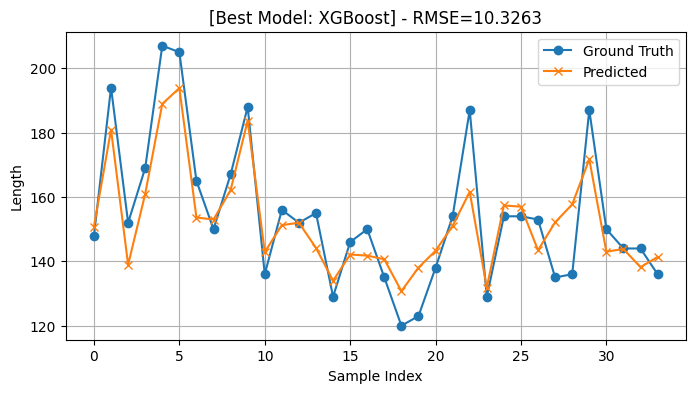

In [3]:
import os
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error,r2_score

from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
import xgboost as xgb

import random

# ---------------------------------------
# 1. 讀取數據 (範例：包含簡單的 RMS 特徵)
# ---------------------------------------
BODY_PARTS = [
    "NOSE", "LEFT_EYE", "RIGHT_EYE", "LEFT_EAR", "RIGHT_EAR",
    "LEFT_SHOULDER", "RIGHT_SHOULDER", "LEFT_ELBOW", "RIGHT_ELBOW",
    "LEFT_WRIST", "RIGHT_WRIST", "LEFT_HIP", "RIGHT_HIP",
    "LEFT_KNEE", "RIGHT_KNEE", "LEFT_ANKLE", "RIGHT_ANKLE"
]

def compute_rms_features(df_temp):
    """
    針對每個關節 (part)，計算:
      1) (x_score, y_score) 的平均值
      2) 速度 (speed[t]) = sqrt( dx^2 + dy^2 ), 衍生：
         - 最大值 (max)
         - 最小值 (min)
         - 平均值 (mean)
         - 標準差 (std)
         - 變化率 (roc): 平均( (speed[t+1] - speed[t]) / speed[t] )
    回傳一個 dict
    """
    features_dict = {}

    for part in BODY_PARTS:
        x_col = f"{part}_x"
        y_col = f"{part}_y"
        s_col = f"{part}_score"

        # 如果 CSV 缺少某些欄位，就跳過
        if x_col not in df_temp.columns or y_col not in df_temp.columns or s_col not in df_temp.columns:
            continue

        # (A) 計算 x_score, y_score 平均值
        x_score_series = df_temp[x_col] * df_temp[s_col]
        y_score_series = df_temp[y_col] * df_temp[s_col]
        features_dict[f"{part}_x_score_mean"] = x_score_series.mean()
        features_dict[f"{part}_y_score_mean"] = y_score_series.mean()

        # (B) 速度 -> 衍生 RMS max, min, mean, std, 變化率
        dx = df_temp[x_col].diff().fillna(0)
        dy = df_temp[y_col].diff().fillna(0)
        speed = np.sqrt(dx**2 + dy**2)

        features_dict[f"RMS_{part}_max"] = speed.max()
        features_dict[f"RMS_{part}_min"] = speed.min()
        features_dict[f"RMS_{part}_mean"] = speed.mean()
        features_dict[f"RMS_{part}_std"] = speed.std()

        speed_shifted = speed.shift(1)
        valid_mask = (speed_shifted != 0)
        if valid_mask.sum() > 1:
            speed_diff_ratio = (speed - speed_shifted) / (speed_shifted + 1e-8)
            roc_val = speed_diff_ratio[valid_mask].mean()
        else:
            roc_val = 0.0

        features_dict[f"RMS_{part}_roc"] = roc_val

    return features_dict

def read_time_series_csv_as_one_row(csv_path, agg_mode="mean"):
    df_temp = pd.read_csv(csv_path)
    if len(df_temp) == 0:
        return pd.Series(dtype=float)

    if "file_name" in df_temp.columns:
        df_temp.drop("file_name", axis=1, inplace=True)

    if agg_mode == "mean":
        row_series = df_temp.mean(axis=0)
    elif agg_mode == "median":
        row_series = df_temp.median(axis=0)
    elif agg_mode == "max":
        row_series = df_temp.max(axis=0)
    elif agg_mode == "min":
        row_series = df_temp.min(axis=0)
    elif agg_mode == "last":
        row_series = df_temp.iloc[-1]
    else:
        row_series = df_temp.mean(axis=0)

    # 額外計算 RMS 特徵
    rms_dict = compute_rms_features(df_temp)
    for k, v in rms_dict.items():
        row_series[k] = v

    return row_series

def read_csv_and_excel(csv_folder, excel_path,
                       name_col="NAME", length_col="length",
                       height_col="height", weight_col="weight",
                       source_name="flat_pull",
                       agg_mode="mean"):

    df_excel = pd.read_excel(excel_path)
    s_name   = df_excel[name_col]
    s_length = df_excel[length_col]
    s_height = df_excel[height_col]
    s_weight = df_excel[weight_col]

    csv_files = sorted([f for f in os.listdir(csv_folder) if f.lower().endswith(".csv")])
    if len(csv_files) != len(df_excel):
        print(f"[警告] CSV 檔數 ({len(csv_files)}) 與 {excel_path} 筆數 ({len(df_excel)}) 不相符！")

    rows_list   = []
    all_columns = set()

    for i, filename in enumerate(csv_files):
        file_path = os.path.join(csv_folder, filename)
        row_series = read_time_series_csv_as_one_row(file_path, agg_mode=agg_mode)
        row_series["height"] = s_height.iloc[i]
        row_series["weight"] = s_weight.iloc[i]
        all_columns.update(row_series.index)
        rows_list.append(row_series)

    all_columns = sorted(all_columns)
    df_X = pd.DataFrame([{col: row.get(col, 0) for col in all_columns} for row in rows_list])
    s_source = pd.Series([source_name]*len(df_X), index=df_X.index)

    print(f"=== 已讀取: {csv_folder}, Excel: {excel_path}, source={source_name} ===")
    print(f"df_X.shape = {df_X.shape}; s_length.shape={s_length.shape}")

    return df_X, s_name, s_length, s_source

# (A) 讀取資料
dfX_flat, name_flat, length_flat, source_flat = read_csv_and_excel(
    "flat_pull_output_csvs", "flat_pull.xlsx",
    "NAME", "length", "height", "weight", "flat_pull"
)
dfX_back, name_back, length_back, source_back = read_csv_and_excel(
    "pull_back_output_csvs", "pull_back.xlsx",
    "NAME", "length", "height", "weight", "pull_back"
)
dfX_up, name_up, length_up, source_up = read_csv_and_excel(
    "pull_up_output_csvs", "pull_up.xlsx",
    "NAME", "length", "height", "weight", "pull_up"
)

# (B) 統一欄位
all_cols_3 = sorted(set(dfX_flat.columns).union(dfX_back.columns).union(dfX_up.columns))

def align_columns(df, all_cols):
    return pd.DataFrame([{c: df.iloc[i][c] if c in df.columns else 0 for c in all_cols}
                         for i in range(len(df))])

dfX_all = pd.concat([
    align_columns(dfX_flat, all_cols_3),
    align_columns(dfX_back, all_cols_3),
    align_columns(dfX_up, all_cols_3)
], axis=0, ignore_index=True)

s_length_all = pd.concat([length_flat, length_back, length_up], axis=0, ignore_index=True)

selected_features=['LEFT_ANKLE_x', 'LEFT_ANKLE_y_score_mean', 'LEFT_EAR_score', 'LEFT_EAR_x', 'LEFT_EAR_x_score_mean', 'LEFT_ELBOW_score', 'LEFT_ELBOW_x', 'LEFT_ELBOW_y_score_mean', 'LEFT_EYE_score', 'LEFT_EYE_x_score_mean', 'LEFT_EYE_y_score_mean', 'LEFT_HIP_x_score_mean', 'LEFT_KNEE_x', 'LEFT_KNEE_x_score_mean', 'LEFT_SHOULDER_score', 'LEFT_SHOULDER_x', 'LEFT_SHOULDER_x_score_mean', 'LEFT_SHOULDER_y', 'LEFT_SHOULDER_y_score_mean', 'LEFT_WRIST_x', 'LEFT_WRIST_y', 'LEFT_WRIST_y_score_mean', 'NOSE_score', 'NOSE_x', 'RIGHT_ANKLE_x', 'RIGHT_ANKLE_x_score_mean', 'RIGHT_ANKLE_y_score_mean', 'RIGHT_EAR_score', 'RIGHT_EAR_x', 'RIGHT_EAR_x_score_mean', 'RIGHT_EAR_y', 'RIGHT_ELBOW_x_score_mean', 'RIGHT_ELBOW_y_score_mean', 'RIGHT_EYE_y_score_mean', 'RIGHT_HIP_y_score_mean', 'RIGHT_KNEE_score', 'RIGHT_KNEE_x_score_mean', 'RIGHT_KNEE_y', 'RIGHT_SHOULDER_score', 'RIGHT_SHOULDER_x', 'RIGHT_SHOULDER_y_score_mean', 'RIGHT_WRIST_score', 'RIGHT_WRIST_x', 'RIGHT_WRIST_y', 'RMS_LEFT_ANKLE_max', 'RMS_LEFT_ANKLE_mean', 'RMS_LEFT_ANKLE_roc', 'RMS_LEFT_EAR_max', 'RMS_LEFT_EAR_mean', 'RMS_LEFT_EAR_min', 'RMS_LEFT_EAR_std', 'RMS_LEFT_ELBOW_max', 'RMS_LEFT_ELBOW_min', 'RMS_LEFT_EYE_max', 'RMS_LEFT_HIP_mean', 'RMS_LEFT_HIP_std', 'RMS_LEFT_KNEE_mean', 'RMS_LEFT_KNEE_min', 'RMS_LEFT_KNEE_roc', 'RMS_LEFT_SHOULDER_max', 'RMS_LEFT_SHOULDER_roc', 'RMS_LEFT_WRIST_roc', 'RMS_LEFT_WRIST_std', 'RMS_NOSE_max', 'RMS_NOSE_mean', 'RMS_RIGHT_ANKLE_max', 'RMS_RIGHT_EAR_max', 'RMS_RIGHT_EAR_min', 'RMS_RIGHT_EAR_roc', 'RMS_RIGHT_ELBOW_mean', 'RMS_RIGHT_ELBOW_min', 'RMS_RIGHT_ELBOW_roc', 'RMS_RIGHT_ELBOW_std', 'RMS_RIGHT_EYE_mean', 'RMS_RIGHT_EYE_roc', 'RMS_RIGHT_HIP_min', 'RMS_RIGHT_HIP_roc', 'RMS_RIGHT_HIP_std', 'RMS_RIGHT_KNEE_mean', 'RMS_RIGHT_KNEE_min', 'RMS_RIGHT_SHOULDER_max', 'RMS_RIGHT_SHOULDER_min', 'RMS_RIGHT_SHOULDER_roc', 'RMS_RIGHT_WRIST_max', 'RMS_RIGHT_WRIST_roc', 'RMS_RIGHT_WRIST_std', 'height']
                #   ['LEFT_ANKLE_score', 'LEFT_EAR_score', 'LEFT_ELBOW_score', 'LEFT_EYE_score', 'LEFT_HIP_score', 'LEFT_KNEE_score', 'LEFT_SHOULDER_score', 'LEFT_WRIST_score', 'NOSE_score', 'RIGHT_ANKLE_score', 'RIGHT_EAR_score', 'RIGHT_ELBOW_score', 'RIGHT_EYE_score', 'RIGHT_HIP_score', 'RIGHT_KNEE_score', 'RIGHT_SHOULDER_score', 'RIGHT_WRIST_score', 'RMS_LEFT_ANKLE_mean', 'RMS_LEFT_ANKLE_std', 'RMS_LEFT_EAR_mean', 'RMS_LEFT_EAR_std', 'RMS_LEFT_ELBOW_mean', 'RMS_LEFT_ELBOW_std', 'RMS_LEFT_EYE_mean', 'RMS_LEFT_EYE_std', 'RMS_LEFT_HIP_mean', 'RMS_LEFT_HIP_std', 'RMS_LEFT_KNEE_mean', 'RMS_LEFT_KNEE_std', 'RMS_LEFT_SHOULDER_mean', 'RMS_LEFT_SHOULDER_std', 'RMS_LEFT_WRIST_mean', 'RMS_LEFT_WRIST_std', 'RMS_NOSE_mean', 'RMS_NOSE_std', 'RMS_RIGHT_ANKLE_mean', 'RMS_RIGHT_ANKLE_std', 'RMS_RIGHT_EAR_mean', 'RMS_RIGHT_EAR_std', 'RMS_RIGHT_ELBOW_mean', 'RMS_RIGHT_ELBOW_std', 'RMS_RIGHT_EYE_mean', 'RMS_RIGHT_EYE_std', 'RMS_RIGHT_HIP_mean', 'RMS_RIGHT_HIP_std', 'RMS_RIGHT_KNEE_mean', 'RMS_RIGHT_KNEE_std', 'RMS_RIGHT_SHOULDER_mean', 'RMS_RIGHT_SHOULDER_std', 'RMS_RIGHT_WRIST_mean', 'RMS_RIGHT_WRIST_std', 'height', 'weight']

dfX_all = dfX_all[selected_features]

# (C) 標準化
scaler = StandardScaler()
dfX_all_scaled = pd.DataFrame(scaler.fit_transform(dfX_all), columns=dfX_all.columns)

# (D) Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    dfX_all_scaled, s_length_all, test_size=0.2, random_state=42
)

print(f"\nTrain size={len(X_train)}, Test size={len(X_test)}")
print(f"\nTrain size={X_train.shape}, Test size={len(X_test)}")
# =============================================
# 進行 "5 折交叉驗證" + "集成子模型" 來預測測試集
# =============================================
from sklearn.base import clone

# param_grid = {
#     "n_estimators": [50, 100, 200],
#     "learning_rate": [0.01, 0.1, 0.2],
#     "max_depth": [3, 5, 7],
#     "subsample": [0.8, 1.0],
#     "colsample_bytree": [0.8, 1.0]
# }
models = {

    "XGBoost": xgb.XGBRegressor(n_estimators=100, learning_rate=0.1,subsample=1.0,colsample_bytree=1.0, objective="reg:squarederror", random_state=42)
}

kf = KFold(n_splits=5, shuffle=True, random_state=42)

best_model_name = None
best_model = None
best_test_rmse = float('inf')

model_cv_info = {}  # 紀錄每個模型的交叉驗證 & 測試資訊

for name, base_model in models.items():
    fold_rmses = []
    fold_models = []  # 放置5個子模型

    # ========== 5折交叉驗證 ==========
    for train_idx, valid_idx in kf.split(X_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[valid_idx]

        sub_model = clone(base_model)
        sub_model.fit(X_tr, y_tr)

        y_val_pred = sub_model.predict(X_val)
        val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
        fold_rmses.append(val_rmse)

        fold_models.append(sub_model)

    avg_cv_rmse = np.mean(fold_rmses)

    # ========== 用5個子模型集成，預測測試集 ==========
    preds_ensemble_list = []
    sub_folds_rmse_list = []
    for i, fm in enumerate(fold_models):
        sub_pred_test = fm.predict(X_test)
        sub_rmse_test = np.sqrt(mean_squared_error(y_test, sub_pred_test))
        sub_folds_rmse_list.append(sub_rmse_test)
        preds_ensemble_list.append(sub_pred_test)

    ensemble_preds = np.mean(preds_ensemble_list, axis=0)
    ensemble_rmse_test = np.sqrt(mean_squared_error(y_test, ensemble_preds))

    best_sub_model_rmse = min(sub_folds_rmse_list)
    best_sub_model_idx = sub_folds_rmse_list.index(best_sub_model_rmse)

    best_test_rmse_for_this_model = min(best_sub_model_rmse, ensemble_rmse_test)

    model_cv_info[name] = {
        "cv_rmse_list": fold_rmses,
        "avg_cv_rmse": avg_cv_rmse,
        "sub_models_test_rmse": sub_folds_rmse_list,
        "best_sub_model_rmse": best_sub_model_rmse,
        "best_sub_model_idx": best_sub_model_idx,
        "ensemble_test_rmse": ensemble_rmse_test,
        "best_test_rmse": best_test_rmse_for_this_model
    }

    print(f"\n[模型: {name}]")
    print(f"  - 5-Fold CV RMSE: {fold_rmses}")
    print(f"  - 5-Fold CV 平均 RMSE = {avg_cv_rmse:.4f}")
    print(f"  - 集成(5模型平均)在測試集 RMSE = {ensemble_rmse_test:.4f}")
    print(f"  - 單一子模型最佳RMSE = {best_sub_model_rmse:.4f} (fold={best_sub_model_idx})")
    print(f"  => 該模型在測試集的最優分數 = {best_test_rmse_for_this_model:.4f}")

    if best_test_rmse_for_this_model < best_test_rmse:
        best_test_rmse = best_test_rmse_for_this_model
        best_model_name = name
        best_model = base_model

print("\n========== 全部模型的交叉驗證 & 測試情況 ==========")
for m_name, info in model_cv_info.items():
    print(f"\n模型: {m_name}")
    print(f"  CV各fold RMSE: {info['cv_rmse_list']}")
    print(f"  => CV平均RMSE: {info['avg_cv_rmse']:.4f}")
    print(f"  => 集成測試集RMSE: {info['ensemble_test_rmse']:.4f}")
    print(f"  => 單一子模型最佳RMSE: {info['best_sub_model_rmse']:.4f} (fold={info['best_sub_model_idx']})")
    print(f"  => 測試集最優RMSE: {info['best_test_rmse']:.4f}")

print(f"\n[結論] 全部模型中，在測試集表現最好的模型: {best_model_name}, TestRMSE={best_test_rmse:.4f}")

# === 重新在整個 X_train 上訓練 best_model 並保存 ===
print(f"\n=== 重新在整個 X_train 上訓練最優模型: {best_model_name} ===")
print(X_train.shape)
best_model.fit(X_train, y_train)
y_pred_best = best_model.predict(X_test)
final_rmse = np.sqrt(mean_squared_error(y_test, y_pred_best))
final_r2 = r2_score(y_test, y_pred_best)  # 計算 R²
print(f"[最終] {best_model_name} 在測試集上 RMSE = {final_rmse:.4f}, R² = {final_r2:.4f}")

# 儲存模型
model_save_path = "best_model.joblib"
# joblib.dump(best_model, model_save_path)
joblib.dump((best_model, scaler, list(X_train.columns)), "best_model.joblib")

print(f"✅ 已儲存最佳模型到: {model_save_path}")


# (可視化)    
def visualize_predictions(y_true, y_pred, title):
    plt.figure(figsize=(8,4))
    plt.plot(y_true.values, label="Ground Truth", marker='o')
    plt.plot(y_pred, label="Predicted", marker='x')
    plt.title(title)
    
    plt.xlabel("Sample Index")
    plt.ylabel("Length")
    plt.legend()
    plt.grid(True)
    plt.show()

visualize_predictions(y_test, y_pred_best, f"[Best Model: {best_model_name}] - RMSE={final_rmse:.4f}")



[模型: XGBoost]
  - 5-Fold CV RMSE: [np.float64(22.808186664139917), np.float64(19.066923635036066), np.float64(17.658681732432456), np.float64(20.00002136229328), np.float64(16.198213191451185)]
  - 5-Fold CV 平均 RMSE = 19.1464
  - 集成(5模型平均)在測試集 RMSE = 13.8907
  - 單一子模型最佳RMSE = 14.2639 (fold=3)
  => 該模型在測試集的最優分數 = 13.8907

[結論] 全部模型中，在測試集表現最好的模型: XGBoost, TestRMSE=13.8907

=== 重新在整個 X_train 上訓練最優模型: XGBoost ===
[最終] XGBoost 在測試集上 RMSE = 10.3263, R² = 0.7807
✅ 已儲存最佳模型到: best_model.joblib


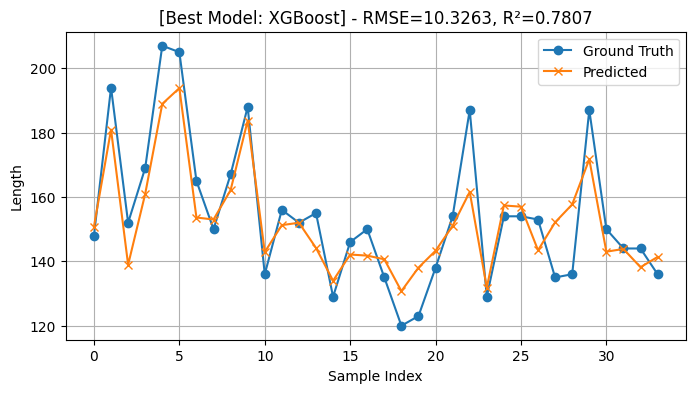

In [2]:
import os
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.base import clone

# 進行 "5 折交叉驗證" + "集成子模型" 來預測測試集
models = {
    "XGBoost": xgb.XGBRegressor(
        n_estimators=100, 
        learning_rate=0.1,
        subsample=1.0,
        colsample_bytree=1.0,
        objective="reg:squarederror", 
        random_state=42
    )
}

kf = KFold(n_splits=5, shuffle=True, random_state=42)

best_model_name = None
best_model = None
best_test_rmse = float('inf')

model_cv_info = {}  # 紀錄每個模型的交叉驗證 & 測試資訊

for name, base_model in models.items():
    fold_rmses = []
    fold_models = []  # 放置5個子模型

    # ========== 5折交叉驗證 ==========
    for train_idx, valid_idx in kf.split(X_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[valid_idx]

        sub_model = clone(base_model)
        sub_model.fit(X_tr, y_tr)

        y_val_pred = sub_model.predict(X_val)
        val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
        fold_rmses.append(val_rmse)

        fold_models.append(sub_model)

    avg_cv_rmse = np.mean(fold_rmses)

    # ========== 用5個子模型集成，預測測試集 ==========
    preds_ensemble_list = []
    sub_folds_rmse_list = []
    for i, fm in enumerate(fold_models):
        sub_pred_test = fm.predict(X_test)
        sub_rmse_test = np.sqrt(mean_squared_error(y_test, sub_pred_test))
        sub_folds_rmse_list.append(sub_rmse_test)
        preds_ensemble_list.append(sub_pred_test)

    ensemble_preds = np.mean(preds_ensemble_list, axis=0)
    ensemble_rmse_test = np.sqrt(mean_squared_error(y_test, ensemble_preds))

    best_sub_model_rmse = min(sub_folds_rmse_list)
    best_sub_model_idx = sub_folds_rmse_list.index(best_sub_model_rmse)

    best_test_rmse_for_this_model = min(best_sub_model_rmse, ensemble_rmse_test)

    model_cv_info[name] = {
        "cv_rmse_list": fold_rmses,
        "avg_cv_rmse": avg_cv_rmse,
        "sub_models_test_rmse": sub_folds_rmse_list,
        "best_sub_model_rmse": best_sub_model_rmse,
        "best_sub_model_idx": best_sub_model_idx,
        "ensemble_test_rmse": ensemble_rmse_test,
        "best_test_rmse": best_test_rmse_for_this_model
    }

    print(f"\n[模型: {name}]")
    print(f"  - 5-Fold CV RMSE: {fold_rmses}")
    print(f"  - 5-Fold CV 平均 RMSE = {avg_cv_rmse:.4f}")
    print(f"  - 集成(5模型平均)在測試集 RMSE = {ensemble_rmse_test:.4f}")
    print(f"  - 單一子模型最佳RMSE = {best_sub_model_rmse:.4f} (fold={best_sub_model_idx})")
    print(f"  => 該模型在測試集的最優分數 = {best_test_rmse_for_this_model:.4f}")

    if best_test_rmse_for_this_model < best_test_rmse:
        best_test_rmse = best_test_rmse_for_this_model
        best_model_name = name
        best_model = base_model

print(f"\n[結論] 全部模型中，在測試集表現最好的模型: {best_model_name}, TestRMSE={best_test_rmse:.4f}")

# === 重新在整個 X_train 上訓練 best_model 並保存 ===
print(f"\n=== 重新在整個 X_train 上訓練最優模型: {best_model_name} ===")
best_model.fit(X_train, y_train)

# 預測測試集
y_pred_best = best_model.predict(X_test)

# 計算 RMSE 和 R²
final_rmse = np.sqrt(mean_squared_error(y_test, y_pred_best))
final_r2 = r2_score(y_test, y_pred_best)  # 計算 R²

# 印出最終結果
print(f"[最終] {best_model_name} 在測試集上 RMSE = {final_rmse:.4f}, R² = {final_r2:.4f}")

# 儲存模型
model_save_path = "best_model.joblib"
joblib.dump((best_model, scaler, list(X_train.columns)), "best_model.joblib")
print(f"✅ 已儲存最佳模型到: {model_save_path}")

# (可視化)    
def visualize_predictions(y_true, y_pred, title):
    plt.figure(figsize=(8,4))
    plt.plot(y_true.values, label="Ground Truth", marker='o')
    plt.plot(y_pred, label="Predicted", marker='x')
    plt.title(title)
    plt.xlabel("Sample Index")
    plt.ylabel("Length")
    plt.legend()
    plt.grid(True)
    plt.show()

visualize_predictions(y_test, y_pred_best, f"[Best Model: {best_model_name}] - RMSE={final_rmse:.4f}, R²={final_r2:.4f}")


# 測試集單筆測試(做特徵選擇過後)

In [222]:
# import os
import joblib
import pandas as pd
import numpy as np
# from sklearn.preprocessing import StandardScaler

# 1️⃣ 載入已訓練的模型 & 標準化工具
# model_save_path = "best_model.joblib"
# loaded_model, scaler = joblib.load(model_save_path)
# print("✅ 模型已成功載入")

loaded_model, scaler, TRAIN_FEATURES = joblib.load("best_model.joblib")


# 確保 SELECTED_FEATURES 與訓練時一致
SELECTED_FEATURES = TRAIN_FEATURES


# 2️⃣ 定義身體部位與 RMS 特徵計算
BODY_PARTS = [
    "NOSE", "LEFT_EYE", "RIGHT_EYE", "LEFT_EAR", "RIGHT_EAR",
    "LEFT_SHOULDER", "RIGHT_SHOULDER", "LEFT_ELBOW", "RIGHT_ELBOW",
    "LEFT_WRIST", "RIGHT_WRIST", "LEFT_HIP", "RIGHT_HIP",
    "LEFT_KNEE", "RIGHT_KNEE", "LEFT_ANKLE", "RIGHT_ANKLE"
]

def compute_rms_features(df_temp):
    """
    針對每個關節 (part)，計算:
      1) (x_score, y_score) 的加權平均
      2) 速度 (speed[t]) = sqrt( dx^2 + dy^2 ), 衍生：
         - 最大值 (max)
         - 最小值 (min)
         - 平均值 (mean)
         - 標準差 (std)
         - 變化率 (roc): 平均( (speed[t+1] - speed[t]) / speed[t] )
    回傳一個 dict
    """
    features_dict = {}

    for part in BODY_PARTS:
        x_col = f"{part}_x"
        y_col = f"{part}_y"
        s_col = f"{part}_score"

        if x_col not in df_temp.columns or y_col not in df_temp.columns or s_col not in df_temp.columns:
            continue

        # (A) 加權平均
        x_score_series = df_temp[x_col] * df_temp[s_col]
        y_score_series = df_temp[y_col] * df_temp[s_col]
        features_dict[f"{part}_x_score_mean"] = x_score_series.mean()
        features_dict[f"{part}_y_score_mean"] = y_score_series.mean()

        # (B) 速度衍生 RMS 特徵
        dx = df_temp[x_col].diff().fillna(0)
        dy = df_temp[y_col].diff().fillna(0)
        speed = np.sqrt(dx**2 + dy**2)

        features_dict[f"RMS_{part}_max"] = speed.max()
        features_dict[f"RMS_{part}_min"] = speed.min()
        features_dict[f"RMS_{part}_mean"] = speed.mean()
        features_dict[f"RMS_{part}_std"] = speed.std()

        speed_shifted = speed.shift(1)
        valid_mask = (speed_shifted != 0)
        if valid_mask.sum() > 1:
            speed_diff_ratio = (speed - speed_shifted) / (speed_shifted + 1e-8)
            roc_val = speed_diff_ratio[valid_mask].mean()
        else:
            roc_val = 0.0

        features_dict[f"RMS_{part}_roc"] = roc_val

    return features_dict

# 3️⃣ 讀取 CSV 並計算特徵
def read_time_series_csv_as_one_row(csv_path, agg_mode="mean"):
    df_temp = pd.read_csv(csv_path)
    if len(df_temp) == 0:
        return pd.Series(dtype=float)

    if "file_name" in df_temp.columns:
        df_temp.drop("file_name", axis=1, inplace=True)

    agg_func = {
        "mean": df_temp.mean(axis=0),
        "median": df_temp.median(axis=0),
        "max": df_temp.max(axis=0),
        "min": df_temp.min(axis=0),
        "last": df_temp.iloc[-1]
    }
    row_series = agg_func.get(agg_mode, df_temp.mean(axis=0))

    # 計算 RMS 特徵
    rms_dict = compute_rms_features(df_temp)
    for k, v in rms_dict.items():
        row_series[k] = v

    return row_series

def read_csv(csv_path, height, weight, agg_mode="mean"):
    """
    讀取 CSV 並計算特徵，包含 RMS，並加入身高與體重。

    Args:
        csv_path (str): CSV 檔案路徑
        height (float): 使用者的身高
        weight (float): 使用者的體重
        agg_mode (str): 聚合模式 ("mean", "max", "min"等)

    Returns:
        pandas.Series: 計算後的特徵
    """
    row_series = read_time_series_csv_as_one_row(csv_path, agg_mode)
    row_series["height"] = height
    row_series["weight"] = weight
    return row_series

# 4️⃣ 選擇與訓練時相同的特徵

# SELECTED_FEATURES=['LEFT_ANKLE_x', 'LEFT_ANKLE_y_score_mean', 'LEFT_EAR_score', 'LEFT_EAR_x', 'LEFT_EAR_x_score_mean', 'LEFT_ELBOW_score', 'LEFT_ELBOW_x', 'LEFT_ELBOW_y_score_mean', 'LEFT_EYE_score', 'LEFT_EYE_x_score_mean', 'LEFT_EYE_y_score_mean', 'LEFT_HIP_x_score_mean', 'LEFT_KNEE_x', 'LEFT_KNEE_x_score_mean', 'LEFT_SHOULDER_score', 'LEFT_SHOULDER_x', 'LEFT_SHOULDER_x_score_mean', 'LEFT_SHOULDER_y', 'LEFT_SHOULDER_y_score_mean', 'LEFT_WRIST_x', 'LEFT_WRIST_y', 'LEFT_WRIST_y_score_mean', 'NOSE_score', 'NOSE_x', 'RIGHT_ANKLE_x', 'RIGHT_ANKLE_x_score_mean', 'RIGHT_ANKLE_y_score_mean', 'RIGHT_EAR_score', 'RIGHT_EAR_x', 'RIGHT_EAR_x_score_mean', 'RIGHT_EAR_y', 'RIGHT_ELBOW_x_score_mean', 'RIGHT_ELBOW_y_score_mean', 'RIGHT_EYE_y_score_mean', 'RIGHT_HIP_y_score_mean', 'RIGHT_KNEE_score', 'RIGHT_KNEE_x_score_mean', 'RIGHT_KNEE_y', 'RIGHT_SHOULDER_score', 'RIGHT_SHOULDER_x', 'RIGHT_SHOULDER_y_score_mean', 'RIGHT_WRIST_score', 'RIGHT_WRIST_x', 'RIGHT_WRIST_y', 'RMS_LEFT_ANKLE_max', 'RMS_LEFT_ANKLE_mean', 'RMS_LEFT_ANKLE_roc', 'RMS_LEFT_EAR_max', 'RMS_LEFT_EAR_mean', 'RMS_LEFT_EAR_min', 'RMS_LEFT_EAR_std', 'RMS_LEFT_ELBOW_max', 'RMS_LEFT_ELBOW_min', 'RMS_LEFT_EYE_max', 'RMS_LEFT_HIP_mean', 'RMS_LEFT_HIP_std', 'RMS_LEFT_KNEE_mean', 'RMS_LEFT_KNEE_min', 'RMS_LEFT_KNEE_roc', 'RMS_LEFT_SHOULDER_max', 'RMS_LEFT_SHOULDER_roc', 'RMS_LEFT_WRIST_roc', 'RMS_LEFT_WRIST_std', 'RMS_NOSE_max', 'RMS_NOSE_mean', 'RMS_RIGHT_ANKLE_max', 'RMS_RIGHT_EAR_max', 'RMS_RIGHT_EAR_min', 'RMS_RIGHT_EAR_roc', 'RMS_RIGHT_ELBOW_mean', 'RMS_RIGHT_ELBOW_min', 'RMS_RIGHT_ELBOW_roc', 'RMS_RIGHT_ELBOW_std', 'RMS_RIGHT_EYE_mean', 'RMS_RIGHT_EYE_roc', 'RMS_RIGHT_HIP_min', 'RMS_RIGHT_HIP_roc', 'RMS_RIGHT_HIP_std', 'RMS_RIGHT_KNEE_mean', 'RMS_RIGHT_KNEE_min', 'RMS_RIGHT_SHOULDER_max', 'RMS_RIGHT_SHOULDER_min', 'RMS_RIGHT_SHOULDER_roc', 'RMS_RIGHT_WRIST_max', 'RMS_RIGHT_WRIST_roc', 'RMS_RIGHT_WRIST_std', 'height']

def ensure_features_match(row_series, expected_features):
    """
    確保 row_series 包含所有模型訓練時的特徵。
    若有缺少的特徵，補 0。
    """
    missing_features = set(expected_features) - set(row_series.index)
    for feature in missing_features:
        row_series[feature] = 0  # 填補缺失特徵
    
    return row_series[expected_features]  # 確保順序一致


# 5️⃣ 預測函數
def predict_from_csv(csv_path, model, scaler, height, weight):
    """
    讀取 CSV，計算特徵，並手動加入身高/體重後做預測。

    Args:
        csv_path (str): CSV 檔案路徑
        model: 機器學習模型
        scaler: 標準化工具
        height (float): 身高
        weight (float): 體重

    Returns:
        float: 預測結果
    """
    row_series = read_csv(csv_path, height, weight)

    # ✅ 確保特徵完整
    row_series = ensure_features_match(row_series, SELECTED_FEATURES)

    # ✅ 標準化處理
    feature_vector = scaler.transform([row_series.values])

    # ✅ 預測
    prediction = model.predict(feature_vector)[0]

    return max(0, prediction)  # 避免負數預測


# 6️⃣ CSV 測試
csv_input_path = "output_data.csv"

# csv_input_path = "CAO,RUEI-LIAN(1).csv"


user_height = 139.0  # cm
user_weight = 30.0   # kg

predicted_value = predict_from_csv(csv_input_path, loaded_model, scaler, user_height, user_weight)
print(f"📌 CSV 測試 - 預測結果: {predicted_value}")

# # 7️⃣ 手動輸入特徵測試
# test_feature_vector = np.random.rand(len(SELECTED_FEATURES) - 2)  # 除去 height, weight
# test_height = 160.0
# test_weight = 55.0

# test_feature_vector = np.append(test_feature_vector, [test_height, test_weight]).reshape(1, -1)
# test_feature_vector_scaled = scaler.transform(test_feature_vector)

# predicted_value_manual = loaded_model.predict(test_feature_vector_scaled)[0]
# print(f"📌 單筆特徵測試 - 預測結果: {predicted_value_manual}")


📌 CSV 測試 - 預測結果: 138.7987060546875


d:\anaconda3\envs\movenet\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


# 測試集單筆測試

In [70]:
import joblib
import pandas as pd
import numpy as np

# 1️⃣ 載入已訓練的模型 & 標準化工具
model_save_path = "best_trained_model.joblib"
loaded_model, scaler = joblib.load(model_save_path)
print("✅ 模型已成功載入")

# 2️⃣ 定義預測函式（加入 height & weight）
def predict_from_csv(csv_path, model, scaler, height, weight):
    """
    從 MoveNet 產出的 CSV 讀取特徵，並手動加入身高/體重後做預測。
    
    Args:
        csv_path (str): CSV 檔案路徑 (已經經過 MoveNet 處理)
        model: 讀取的機器學習模型
        scaler: 標準化工具
        height (float): 使用者的身高
        weight (float): 使用者的體重
    
    Returns:
        float: 預測結果
    """
    # 讀取 CSV 並處理資料
    df = pd.read_csv(csv_path)
    
    if "file_name" in df.columns:
        df.drop("file_name", axis=1, inplace=True)

    # **防止資料不完整，缺失值填 0**
    df.fillna(0, inplace=True)

    # 聚合多行數據（取最大值）
    feature_vector = df.max(axis=0).values.reshape(1, -1)

    # 3️⃣ 確保 height 和 weight 作為新特徵加入
    feature_vector = np.append(feature_vector, [height, weight]).reshape(1, -1)

    # 4️⃣ 限制 height 和 weight 的範圍（避免超出訓練數據）
    feature_vector = np.clip(feature_vector, scaler.mean_ - 3*np.sqrt(scaler.var_), scaler.mean_ + 3*np.sqrt(scaler.var_))

    # 5️⃣ 使用標準化處理
    feature_vector_scaled = scaler.transform(feature_vector)

    # 6️⃣ 進行預測
    prediction = model.predict(feature_vector_scaled)[0]

    # **避免預測結果為負數**
    prediction = max(0, prediction)
    
    return prediction

# 5️⃣ 範例使用
csv_input_path = "output_data.csv"  # 影片轉換後的 CSV
user_height = 139.0  # 例如輸入身高 (cm)(預設148)
user_weight = 30.0   # 例如輸入體重 (kg)(預設38)

predicted_value = predict_from_csv(csv_input_path, loaded_model, scaler, user_height, user_weight)
print(f"📌 預測結果: {predicted_value}")


✅ 模型已成功載入
📌 預測結果: 174.63418103386422


d:\anaconda3\envs\movenet\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
d:\anaconda3\envs\movenet\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(


In [ ]:
import joblib

# 假設已訓練好的 model
model = LinearRegression()
model.fit(X_train, length_train)

# 儲存模型
model_save_path = "trained_model.joblib"
joblib.dump(model, model_save_path)
print(f"模型已儲存至 {model_save_path}")

# 載入儲存的模型
loaded_model = joblib.load(model_save_path)
print("模型已成功載入")

# 假設有影片的 csv 檔案 (經過 MoveNet 處理後)
def predict_from_csv(csv_path, model):
    import pandas as pd

    # 讀取 CSV 並處理資料
    df = pd.read_csv(csv_path)
    
    if "file_name" in df.columns:
        df.drop("file_name", axis=1, inplace=True)

    # 聚合多行數據 (取平均)
    feature_vector = df.min(axis=0).values.reshape(1, -1)
    # row_series = df_temp.max(axis=0)

    # 預測
    prediction = model.predict(feature_vector)
    return prediction[0]

# 範例使用
csv_input_path = "output_data.csv"  # 假設這是影片轉換後的 CSV
predicted_value = predict_from_csv(csv_input_path, loaded_model)
print(f"預測結果: {predicted_value}")


# 讀取影片與模型來預測跳遠結果


In [198]:
import cv2
import os
import pandas as pd
from sklearn.linear_model import LinearRegression


class MoveNetPreprocessor(object):
    """Simplified MoveNet Preprocessor without subfolders."""

    def __init__(self, images_in_folder, images_out_folder, csvs_out_path):
        """
        Args:
            images_in_folder: 存放輸入圖片的資料夾。
            images_out_folder: 存放偵測後圖片的資料夾。
            csvs_out_path: 存放關節點資料的 CSV 檔案路徑。
        """
        if not os.path.exists(images_in_folder):
            os.makedirs(images_in_folder)

        self._images_in_folder = images_in_folder
        self._images_out_folder = images_out_folder
        self._csvs_out_path = csvs_out_path
        self._messages = []

        os.makedirs(self._images_out_folder, exist_ok=True)
        os.makedirs(os.path.dirname(self._csvs_out_path), exist_ok=True)

        # 取得所有圖片檔案名稱 (.jpg, .png)


    def process(self, detection_threshold=0.1):
        """處理所有圖片，進行姿勢偵測並輸出結果到圖片和 CSV。"""
        print("🚀 開始處理圖片...")

        self._image_names = sorted([
            f for f in os.listdir(self._images_in_folder)
            if f.lower().endswith(('.jpg', '.jpeg', '.png')) and not f.startswith('.')
        ])
        # 建立 CSV 檔案，寫入表頭
        with open(self._csvs_out_path, 'w', newline='') as csv_out_file:
            csv_out_writer = csv.writer(csv_out_file, delimiter=',', quoting=csv.QUOTE_MINIMAL)

            # 表頭：file_name + 每個 keypoint 的 (x, y, score)
            header = ["file_name"]
            for bodypart in BodyPart:
                header += [f"{bodypart.name}_x", f"{bodypart.name}_y", f"{bodypart.name}_score"]
            csv_out_writer.writerow(header)

            valid_image_count = 0

            # 逐張圖片進行姿勢偵測
            for image_name in tqdm.tqdm(self._image_names):
                image_path = os.path.join(self._images_in_folder, image_name)

                # 嘗試讀取圖片
                try:
                    image = tf.io.read_file(image_path)
                    image = tf.io.decode_jpeg(image)
                except Exception as e:
                    self._messages.append(f"❌ Skipped {image_path}. Error: {e}")
                    continue

                # 檢查是否為 RGB 圖片
                if image.shape[-1] != 3:
                    self._messages.append(f"⚠️ Skipped {image_path}. Not RGB.")
                    continue

                # 呼叫偵測函數
                person = detect(image)

                # 檢查信心分數
                min_landmark_score = min([k.score for k in person.keypoints])
                if min_landmark_score < detection_threshold:
                    self._messages.append(f"⚠️ Skipped {image_path}. Low confidence.")
                    continue

                valid_image_count += 1

                # 繪製關節點
                output_overlay = draw_prediction_on_image(
                    image.numpy().astype(np.uint8),
                    person,
                    close_figure=True,
                    keep_input_size=True
                )
                output_frame = cv2.cvtColor(output_overlay, cv2.COLOR_RGB2BGR)

                # 儲存繪製後的圖片
                output_image_path = os.path.join(self._images_out_folder, image_name)
                cv2.imwrite(output_image_path, output_frame)

                # 取出 keypoint 座標與分數，並寫入 CSV
                pose_landmarks = np.array(
                    [[kp.coordinate.x, kp.coordinate.y, kp.score] for kp in person.keypoints],
                    dtype=np.float32
                )
                coordinates = pose_landmarks.flatten().astype(str).tolist()
                csv_out_writer.writerow([image_name] + coordinates)
            # 4️⃣ 自動刪除 temp_frames
        if os.path.exists(self._images_in_folder):
            shutil.rmtree(self._images_in_folder)
            print(f"✅ 已自動刪除暫存資料夾: {self._images_in_folder}")

        # 結束訊息
        if valid_image_count == 0:
            raise RuntimeError("❌ 沒有找到有效的圖片進行姿勢偵測。")
        else:
            print(f"✅ 處理完成，共處理 {valid_image_count} 張有效圖片。")

        if self._messages:
            print("\n".join(self._messages))



# 假設有影片的 csv 檔案 (經過 MoveNet 處理後)
def predict_from_csv(csv_path, model):
    import pandas as pd

    # 讀取 CSV 並處理資料
    df = pd.read_csv(csv_path)
    
    if "file_name" in df.columns:
        df.drop("file_name", axis=1, inplace=True)

    # 聚合多行數據 (取平均)
    feature_vector = df.min(axis=0).values.reshape(1, -1)
    # row_series = df_temp.max(axis=0)

    # 預測
    prediction = model.predict(feature_vector)
    return prediction[0]
def process_video_and_predict(video_path, model, temp_folder='temp_frames', fps_extract=2):
    # 1. 轉影片為影格
    if not os.path.exists(temp_folder):
        os.makedirs(temp_folder)

    cap = cv2.VideoCapture(video_path)
    video_fps = cap.get(cv2.CAP_PROP_FPS)
    frame_interval = int(video_fps / fps_extract)
    frame_count, extracted_count = 0, 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        if frame_count % frame_interval == 0:
            frame_name = f"{extracted_count:06d}.jpg"
            cv2.imwrite(os.path.join(temp_folder, frame_name), frame)
            extracted_count += 1

        frame_count += 1

    cap.release()
    print(f"已擷取 {extracted_count} 張影格")

    # 2. 使用 MoveNet 處理影格並輸出 CSV
    # 假設此步驟已經完成，並生成了 `movenet_output.csv`
    preprocessor = MoveNetPreprocessor(
    images_in_folder='temp_frames',        # 輸入圖片資料夾
    images_out_folder='poses_images_out',   # 偵測後圖片輸出
    csvs_out_path='output_csvs/output_data.csv'  # CSV 輸出
        )
    print("🚀 開始執行 MoveNetPreprocessor.process() ...")
    preprocessor.process()

    # 3. 使用已訓練好的模型進行預測
    csv_output_path = "output_csvs/output_data.csv"  # 假設 MoveNet 的結果
    predicted_value = predict_from_csv(csv_output_path, model)
    print(f"影片預測結果: {predicted_value}")

#讀取影片
# video_path = "CAO,RUEI-LIAN(1).MOV"
video_path = "YANG,YI-RU(4).MOV"  

preprocessor = MoveNetPreprocessor(
    images_in_folder='temp_frames',        # 輸入圖片資料夾
    images_out_folder='poses_images_out',   # 偵測後圖片輸出
    csvs_out_path='output_csvs/output_data.csv'  # CSV 輸出
)

import joblib

# 假設已訓練好的 model
model = LinearRegression()
# model.fit(X_train, length_train)

# 儲存模型
model_save_path = "trained_model.joblib"

# 載入儲存的模型
loaded_model = joblib.load(model_save_path)
print("模型已成功載入")
process_video_and_predict(video_path, loaded_model)


模型已成功載入
已擷取 16 張影格
🚀 開始執行 MoveNetPreprocessor.process() ...
🚀 開始處理圖片...


100%|███████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 18.80it/s]

✅ 已自動刪除暫存資料夾: temp_frames
✅ 處理完成，共處理 15 張有效圖片。
⚠️ Skipped temp_frames\000012.jpg. Low confidence.
影片預測結果: 5476.95770075153



D:\anaconda3\envs\movenet\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


# BILSTM模型訓練

In [77]:
import os
import numpy as np
import pandas as pd

def load_variable_length_data(csv_folder, excel_path):
    """
    範例：讀取某資料夾下的多個 CSV(時序資料) + Excel標籤(length)，
    回傳 X_list, y_list。
    假設：csv_folder 裏的檔案數量 與 excel_path 行數相同 & 按排序對應。
    """

    # 讀取 Excel，抓 "NAME", "length" 欄位 (可自由擴充)
    df_excel = pd.read_excel(excel_path)
    # 假設每一列對應 csv_files[i]
    length_series = df_excel["length"]  # shape (N,)
    # name_series = df_excel["NAME"]    # 如果還需 NAME

    # 取得 CSV 檔案列表
    csv_files = sorted([
        f for f in os.listdir(csv_folder)
        if f.lower().endswith(".csv")
    ])

    X_list = []
    y_list = []

    for i, csv_file in enumerate(csv_files):
        csv_path = os.path.join(csv_folder, csv_file)

        # 讀取多行
        df_temp = pd.read_csv(csv_path)
        # shape = (T_i, D)
        # 如果 CSV 有一些無效行要先處理(略) ...
        if "file_name" in df_temp.columns:
            df_temp.drop("file_name", axis=1, inplace=True)

        # 轉成 float32 numpy array
        arr = df_temp.values.astype(np.float32)  # shape (T_i, D)

        X_list.append(arr)
        y_list.append(float(length_series.iloc[i]))  # 第i列標籤

    return X_list, y_list


import tensorflow as tf

def timeseries_generator(X_list, y_list):
    """
    產生 (x, y) pair，其中 x.shape=[T_i, D], y.shape=[] (scalar)
    """
    for x, y in zip(X_list, y_list):
        yield x, y


def build_dataset(X_list, y_list, batch_size=4, shuffle=True, buffer_size=100):
    # 1) 先用 from_generator
    output_signature = (
        tf.TensorSpec(shape=(None, None), dtype=tf.float32),  # (T_i, D) → D等下會動態補
        tf.TensorSpec(shape=(), dtype=tf.float32)             # 單一標量
    )
    ds = tf.data.Dataset.from_generator(
        lambda: timeseries_generator(X_list, y_list),
        output_signature=output_signature
    )

    # 2) Shuffle (選擇性)
    if shuffle:
        ds = ds.shuffle(buffer_size)

    # 3) padded_batch
    #   - padded_shapes=((None, D_max), ()), D_max 可以用 "None" 代表動態?
    #   - 但我們要固定特徵數(=df_temp.shape[1])。假設你知道 D=51
    D = X_list[0].shape[1] if len(X_list) > 0 else 0
    # 讓時間維度用 None 表示可變，特徵數固定 D
    padded_shapes = ((None, D), ())  # x=(T, D), y=()

    ds = ds.padded_batch(
        batch_size=batch_size,
        padded_shapes=padded_shapes,
        padding_values=(0.0, 0.0)  # 預設填 0
    )
    return ds


from tensorflow import keras

# def build_lstm_model(num_features):
#     """
#     num_features = D
#     回傳一個簡易 LSTM -> Dense 回歸模型
#     """
#     inputs = keras.Input(shape=(None, num_features))
#     # 使用 Masking (將全0向量視為padding)
#     x = keras.layers.Masking(mask_value=0.0)(inputs)
#     # LSTM 輸出最後一個 time_step 的向量 (return_sequences=False)
#     x = keras.layers.LSTM(64)(x)
#     # Dense 回歸輸出
#     outputs = keras.layers.Dense(1)(x)

#     model = keras.Model(inputs, outputs)
#     return model
def build_lstm_model(num_features):
    inputs = keras.Input(shape=(None, num_features))
    x = keras.layers.Masking(mask_value=0.0)(inputs)
    x = keras.layers.Bidirectional(
        keras.layers.LSTM(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.3)
    )(x)
    x = keras.layers.Bidirectional(
        keras.layers.LSTM(64, dropout=0.3, recurrent_dropout=0.3)
    )(x)
    x = keras.layers.Dense(32, activation='relu')(x)
    outputs = keras.layers.Dense(1)(x)
    
    model = keras.Model(inputs, outputs)
    return model

model = build_lstm_model(num_features=51)  # 假設每行CSV 51個欄位
model.compile(
    loss='mse',
    optimizer='adam'
)

print(model.summary())


# === flat_pull ===
X_flat, y_flat = load_variable_length_data(
    csv_folder="flat_pull_output_csvs",
    excel_path="flat_pull.xlsx"
)

# === pull_back ===
X_back, y_back = load_variable_length_data(
    csv_folder="pull_back_output_csvs",
    excel_path="pull_back.xlsx"
)

# === pull_up ===
X_up, y_up = load_variable_length_data(
    csv_folder="pull_up_output_csvs",
    excel_path="pull_up.xlsx"
)

# 合併三組資料
X_list = X_flat + X_back + X_up  # 合併所有 X (list 合併)
y_list = y_flat + y_back + y_up  # 合併所有 y (list 合併)

print("總樣本數:",  X_train_list[1].shape[0])


from sklearn.preprocessing import StandardScaler

# 標準化每筆 CSV 的資料
def normalize_X_list(X_list):
    normalized_X = []
    for x in X_list:
        scaler = StandardScaler()
        x_scaled = scaler.fit_transform(x)
        normalized_X.append(x_scaled)
    return normalized_X

# 應用標準化
X_list = normalize_X_list(X_list)
# 若有多組(pull_back, pull_up) 可把它們的X_list, y_list 合併

# 切train/test (簡單八二分)
from sklearn.model_selection import train_test_split
X_train_list, X_test_list, y_train_list, y_test_list = train_test_split(
    X_list, y_list, test_size=0.2, random_state=42
)

# 建立tf.data.Dataset
train_ds = build_dataset(X_train_list, y_train_list, batch_size=4, shuffle=True)
test_ds = build_dataset(X_test_list, y_test_list, batch_size=4, shuffle=False)

# 建模
num_features = X_train_list[0].shape[1]  # CSV的欄位數 (如51)
model = build_lstm_model(num_features)
model.compile(loss='mse', optimizer='adamW')
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=200, min_lr=1e-6, verbose=1)

# === 1️⃣ 早停機制設定 ===
early_stop = EarlyStopping(
    monitor='val_loss',        # 監控驗證集的損失
    patience=500,                # 如果連續5個epoch沒有改善則停止
    restore_best_weights=True, # 回復到最佳權重
    verbose=1
)



# === 2️⃣ 自定義 Callback：每 20 個 Epoch 印一次 ===
print_every_n_epochs = 20

def on_epoch_end(epoch, logs):
    if (epoch + 1) % print_every_n_epochs == 0:
        print(f"Epoch {epoch + 1}: Loss = {logs['loss']:.4f}, Val_Loss = {logs.get('val_loss', 0):.4f}")

print_callback = LambdaCallback(on_epoch_end=on_epoch_end)
# === 2️⃣ 模型訓練 ===
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=50000,               # 最大訓練輪數
    callbacks=[early_stop, print_callback,reduce_lr],    # 加入 EarlyStopping
    verbose=0
)

# === 3️⃣ 繪製訓練與驗證損失曲線 ===
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training and Validation Loss with EarlyStopping')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# === 4️⃣ 預測 (Predict) ===
# 把 test_ds 整理成可迭代
preds = model.predict(test_ds)
preds = preds.flatten()  # shape (N,)

# === 5️⃣ 與 Ground Truth 比對 ===
# 假設 y_test 是對應的 ground truth
# for i in range(len(preds)):
#     print(f"Sample {i}: Ground Truth = {y_test[i]:.2f}, Predicted = {preds[i]:.2f}")
# 與 Ground Truth 比對 (修正 KeyError)
for i in range(len(preds)):
    print(f"Sample {i}: Ground Truth = {y_test_list[i]:.2f}, Predicted = {preds[i]:.2f}")


# === 6️⃣ 繪製預測 vs 真實值 ===
plt.figure(figsize=(8, 5))
plt.plot(y_test_list, label='Ground Truth', marker='o')
plt.plot(preds, label='Predicted', marker='x')
plt.title('Ground Truth vs Prediction')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.legend()
plt.show()

Model: "functional_46"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_46 (InputLayer)   │ (None, None, 51)          │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ not_equal_46 (NotEqual)       │ (None, None, 51)          │               0 │ input_layer_46[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ masking_46 (Masking)          │ (None, None, 51)          │               0 │ input_layer_46[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ any_46 (Any)                  │ (None, None)              │               0 │ not_equal_46[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bidirectional_4               │ (None, None, 256)         │         184,320 │ masking_46[0][0],          │
│ (Bidirectional)               │                           │                 │ any_46[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bidirectional_5               │ (None, 128)               │         164,352 │ bidirectional_4[0][0],     │
│ (Bidirectional)               │                           │                 │ any_46[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_48 (Dense)              │ (None, 32)                │           4,128 │ bidirectional_5[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_49 (Dense)              │ (None, 1)                 │              33 │ dense_48[0][0]             │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 352,833 (1.35 MB)

 Trainable params: 352,833 (1.35 MB)

 Non-trainable params: 0 (0.00 B)

None
總樣本數: 31


D:\anaconda3\envs\movenet\lib\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Epoch 20: Loss = 435.4255, Val_Loss = 475.4698
Epoch 40: Loss = 173.0795, Val_Loss = 238.9159
Epoch 60: Loss = 76.6243, Val_Loss = 182.1205
Epoch 80: Loss = 40.6295, Val_Loss = 224.1180
Epoch 100: Loss = 33.8093, Val_Loss = 220.2065
Epoch 120: Loss = 31.5505, Val_Loss = 184.7367
Epoch 140: Loss = 15.2615, Val_Loss = 222.8451
Epoch 160: Loss = 16.0982, Val_Loss = 270.1914
Epoch 180: Loss = 12.8097, Val_Loss = 328.1380
Epoch 200: Loss = 10.0935, Val_Loss = 276.5995
Epoch 220: Loss = 9.8320, Val_Loss = 271.7751
Epoch 240: Loss = 9.3135, Val_Loss = 256.9310


KeyboardInterrupt: 

In [64]:
train_ds = build_dataset(X_train_list, y_train_list, batch_size=4, shuffle=True)
test_ds = build_dataset(X_test_list, y_test_list, batch_size=4, shuffle=False)
print(len(X_test_list))
print("Predictions length:", len(preds))
print("Ground Truth length:", len(y_test))

print("總樣本數:",  X_train_list[3].shape[0])
print(train_ds)

34
Predictions length: 34
Ground Truth length: 12
總樣本數: 34
<_PaddedBatchDataset element_spec=(TensorSpec(shape=(None, None, 51), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>


### Preprocess the `TEST` dataset

In [39]:
if not is_skip_step_1:
  images_in_test_folder = os.path.join(IMAGES_ROOT, 'test')
  images_out_test_folder = 'poses_images_out_test'
  csvs_out_test_path = 'test_data.csv'

  preprocessor = MoveNetPreprocessor(
      images_in_folder=images_in_test_folder,
      images_out_folder=images_out_test_folder,
      csvs_out_path=csvs_out_test_path,
  )

preprocessor.process(per_pose_class_limit=None)   #如果不要重新標記就不用這一行

Preprocessing cpr
  0%|                                                           | 0/160 [00:00<?, ?it/s]C:\Users\lab519\AppData\Local\Temp\ipykernel_10060\1291585794.py:128: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  coordinates = pose_landmarks.flatten().astype(np.str).tolist()
100%|█████████████████████████████████████████████████| 160/160 [00:23<00:00,  6.91it/s]
Preprocessing uncpr
100%|█████████████████████████████████████████████████| 200/200 [00:36<00:00,  5.53it/s]

Skipped pose_data\test\cpr\VID20230519132701_067.jpg. No pose was confidentlly detected.
Skipped pose_data\test\cpr\VID20230519133929_175.jpg. No pose was confidentlly detected.
Skipped pose_data\test\cpr\VID20230519133929_222.jpg. No pose was confidentlly detected.
Skipped pose_data\test\cpr\VID20230519133929_236.jpg. No pose was confidentlly detected.
Skipped pose_data\test\cpr\VID20230519133929_294.jpg. No pose was confidentlly detected.
Skipped pose_data\test\cpr\VID20230519133929_296.jpg. No pose was confidentlly detected.
Skipped pose_data\test\uncpr\VID20230519132255_077.jpg. No pose was confidentlly detected.
Skipped pose_data\test\uncpr\VID20230519132255_278.jpg. No pose was confidentlly detected.
Skipped pose_data\test\uncpr\VID20230519132701_177.jpg. No pose was confidentlly detected.
Skipped pose_data\test\uncpr\VID20230519133514_026.jpg. No pose was confidentlly detected.
Skipped pose_data\test\uncpr\VID20230519133514_034.jpg. No pose was confidentlly detected.
Skipped pos

## Part 2: Train a pose classification model that takes the landmark coordinates as input, and output the predicted labels.

You'll build a TensorFlow model that takes the landmark coordinates and predicts the pose class that the person in the input image performs. The model consists of two submodels:

* Submodel 1 calculates a pose embedding (a.k.a feature vector) from the detected landmark coordinates.
* Submodel 2 feeds pose embedding through several `Dense` layer to predict the pose class.

You'll then train the model based on the dataset that were preprocessed in part 1.

### (Optional) Download the preprocessed dataset if you didn't run part 1

In [40]:
# Download the preprocessed CSV files which are the same as the output of step 1
if is_skip_step_1:
  #!wget -O train_data.csv http://download.tensorflow.org/data/pose_classification/yoga_train_data.csv
  #!wget -O test_data.csv http://download.tensorflow.org/data/pose_classification/yoga_test_data.csv

  csvs_out_train_path = 'train_data.csv'
  # csvs_out_test_path = 'test_data.csv'
  is_skipped_step_1 = True

### Load the preprocessed CSVs into `TRAIN` and `TEST` datasets.

In [41]:
def load_pose_landmarks(csv_path):
  """Loads a CSV created by MoveNetPreprocessor.
  
  Returns:
    X: Detected landmark coordinates and scores of shape (N, 17 * 3)
    y: Ground truth labels of shape (N, label_count)
    classes: The list of all class names found in the dataset
    dataframe: The CSV loaded as a Pandas dataframe features (X) and ground
      truth labels (y) to use later to train a pose classification model.
  """

  # Load the CSV file
  dataframe = pd.read_csv(csv_path)
  df_to_process = dataframe.copy()

  # Drop the file_name columns as you don't need it during training.
  df_to_process.drop(columns=['file_name'], inplace=True)

  # Extract the list of class names
  classes = df_to_process.pop('class_name').unique()

  # Extract the labels
  y = df_to_process.pop('class_no')

  # Convert the input features and labels into the correct format for training.
  X = df_to_process.astype('float64')
  y = keras.utils.to_categorical(y)

  return X, y, classes, dataframe

Load and split the original `TRAIN` dataset into `TRAIN` (85% of the data) and `VALIDATE` (the remaining 15%).

In [42]:
# Load the train data
X_train, y_train, class_names, _ = load_pose_landmarks(csvs_out_train_path)

# 不分區訓練數據了，直接用 test 来做 validation
# Split training data (X, y) into (X_train, y_train) and (X_val, y_val)
# X_train, X_val, y_train, y_val = train_test_split(X, y,
#                                                   test_size=0.15)

In [43]:
# Load the test data
X_test, y_test, _, df_test = load_pose_landmarks(csvs_out_test_path)

### Define functions to convert the pose landmarks to a pose embedding (a.k.a. feature vector) for pose classification

Next, convert the landmark coordinates to a feature vector by:
1. Moving the pose center to the origin.
2. Scaling the pose so that the pose size becomes 1
3. Flattening these coordinates into a feature vector

Then use this feature vector to train a neural-network based pose classifier.

In [44]:
def get_center_point(landmarks, left_bodypart, right_bodypart):
  """Calculates the center point of the two given landmarks."""

  left = tf.gather(landmarks, left_bodypart.value, axis=1)
  right = tf.gather(landmarks, right_bodypart.value, axis=1)
  center = left * 0.5 + right * 0.5
  return center


def get_pose_size(landmarks, torso_size_multiplier=2.5):
  """Calculates pose size.

  It is the maximum of two values:
    * Torso size multiplied by `torso_size_multiplier`
    * Maximum distance from pose center to any pose landmark
  """
  # Hips center
  hips_center = get_center_point(landmarks, BodyPart.LEFT_HIP, 
                                 BodyPart.RIGHT_HIP)

  # Shoulders center
  shoulders_center = get_center_point(landmarks, BodyPart.LEFT_SHOULDER,
                                      BodyPart.RIGHT_SHOULDER)

  # Torso size as the minimum body size
  torso_size = tf.linalg.norm(shoulders_center - hips_center)

  # Pose center
  pose_center_new = get_center_point(landmarks, BodyPart.LEFT_HIP, 
                                     BodyPart.RIGHT_HIP)
  pose_center_new = tf.expand_dims(pose_center_new, axis=1)
  # Broadcast the pose center to the same size as the landmark vector to
  # perform substraction
  pose_center_new = tf.broadcast_to(pose_center_new,
                                    [tf.size(landmarks) // (17*2), 17, 2])

  # Dist to pose center
  d = tf.gather(landmarks - pose_center_new, 0, axis=0,
                name="dist_to_pose_center")
  # Max dist to pose center
  max_dist = tf.reduce_max(tf.linalg.norm(d, axis=0))

  # Normalize scale
  pose_size = tf.maximum(torso_size * torso_size_multiplier, max_dist)

  return pose_size


def normalize_pose_landmarks(landmarks):
  """Normalizes the landmarks translation by moving the pose center to (0,0) and
  scaling it to a constant pose size.
  """
  # Move landmarks so that the pose center becomes (0,0)
  pose_center = get_center_point(landmarks, BodyPart.LEFT_HIP, 
                                 BodyPart.RIGHT_HIP)
  pose_center = tf.expand_dims(pose_center, axis=1)
  # Broadcast the pose center to the same size as the landmark vector to perform
  # substraction
  pose_center = tf.broadcast_to(pose_center, 
                                [tf.size(landmarks) // (17*2), 17, 2])
  landmarks = landmarks - pose_center

  # Scale the landmarks to a constant pose size
  pose_size = get_pose_size(landmarks)
  landmarks /= pose_size

  return landmarks


def landmarks_to_embedding(landmarks_and_scores):
  """Converts the input landmarks into a pose embedding."""
  # Reshape the flat input into a matrix with shape=(17, 3)
  reshaped_inputs = keras.layers.Reshape((17, 3))(landmarks_and_scores)

  # Normalize landmarks 2D
  landmarks = normalize_pose_landmarks(reshaped_inputs[:, :, :2])

  # Flatten the normalized landmark coordinates into a vector
  embedding = keras.layers.Flatten()(landmarks)

  return embedding

### Define a Keras model for pose classification

Our Keras model takes the detected pose landmarks, then calculates the pose embedding and predicts the pose class.

In [45]:
# # Define the model
# inputs = tf.keras.Input(shape=(51))
# embedding = landmarks_to_embedding(inputs)

# layer = keras.layers.Dense(128, activation=tf.nn.relu6)(embedding)
# layer = keras.layers.Dropout(0.5)(layer)
# layer = keras.layers.Dense(64, activation=tf.nn.relu6)(layer)
# layer = keras.layers.Dropout(0.5)(layer)
# outputs = keras.layers.Dense(len(class_names), activation="softmax")(layer)

# model = keras.Model(inputs, outputs)
# model.summary()

# Define the model
inputs = tf.keras.Input(shape=(51))
embedding = landmarks_to_embedding(inputs)

layer = keras.layers.Dense(128, activation=tf.nn.relu6)(embedding)

layer = keras.layers.Dropout(0.5)(layer)
layer = keras.layers.Dense(64, kernel_regularizer=tf.keras.regularizers.L2(0.01),activation=tf.nn.relu6)(layer)
layer = keras.layers.Dropout(0.5)(layer)
# layer = keras.layers.Dropout(0.1)(layer)

# layer = keras.layers.Dense(57, kernel_regularizer=tf.keras.regularizers.L2(0.01),activation=tf.nn.relu6)(layer)
# layer = keras.layers.Dense(57, activation=tf.nn.relu6)(layer)
# layer = keras.layers.Dropout(0.1)(layer)



# layer = keras.layers.Dense(41,kernel_regularizer=tf.keras.regularizers.L2(0.01), activation=tf.nn.relu6)(layer)
# layer = keras.layers.Dense(41, activation=tf.nn.relu6)(layer)
# layer = keras.layers.Dropout(0.2)(layer)

# layer = keras.layers.Dense(32, activation=tf.nn.relu6)(layer)

# layer = keras.layers.Dense(32, kernel_regularizer=tf.keras.regularizers.L2(0.01),activation=tf.nn.relu6)(layer)


outputs = keras.layers.Dense(len(class_names), activation="softmax")(layer)

model = keras.Model(inputs, outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 51)]         0           []                               
                                                                                                  
 reshape_1 (Reshape)            (None, 17, 3)        0           ['input_2[0][0]']                
                                                                                                  
 tf.__operators__.getitem_1 (Sl  (None, 17, 2)       0           ['reshape_1[0][0]']              
 icingOpLambda)                                                                                   
                                                                                                  
 tf.compat.v1.gather_9 (TFOpLam  (None, 2)           0           ['tf.__operators__.getitem_

In [46]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Add a checkpoint callback to store the checkpoint that has the highest
# validation accuracy.
checkpoint_path = "weights.best.hdf5"
checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')
earlystopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                              patience=700)

# Start training
history = model.fit(X_train, y_train,
                    epochs=1000,
                    batch_size=16,
                    validation_data=(X_test, y_test),
                    callbacks=[checkpoint, earlystopping])
                  #  callbacks=[checkpoint])

Epoch 1/1000
161/189 [========================>.....] - ETA: 0s - loss: 0.7578 - accuracy: 0.8727
Epoch 1: val_accuracy improved from -inf to 0.96707, saving model to weights.best.hdf5
189/189 [==============================] - 1s 4ms/step - loss: 0.6905 - accuracy: 0.8839 - val_loss: 0.2230 - val_accuracy: 0.9671
Epoch 2/1000
164/189 [=========================>....] - ETA: 0s - loss: 0.2229 - accuracy: 0.9604
Epoch 2: val_accuracy improved from 0.96707 to 0.97006, saving model to weights.best.hdf5
189/189 [==============================] - 0s 2ms/step - loss: 0.2160 - accuracy: 0.9619 - val_loss: 0.1352 - val_accuracy: 0.9701
Epoch 3/1000
163/189 [========================>.....] - ETA: 0s - loss: 0.1617 - accuracy: 0.9686
Epoch 3: val_accuracy improved from 0.97006 to 0.98204, saving model to weights.best.hdf5
189/189 [==============================] - 0s 2ms/step - loss: 0.1646 - accuracy: 0.9682 - val_loss: 0.1103 - val_accuracy: 0.9820
Epoch 4/1000
164/189 [========================

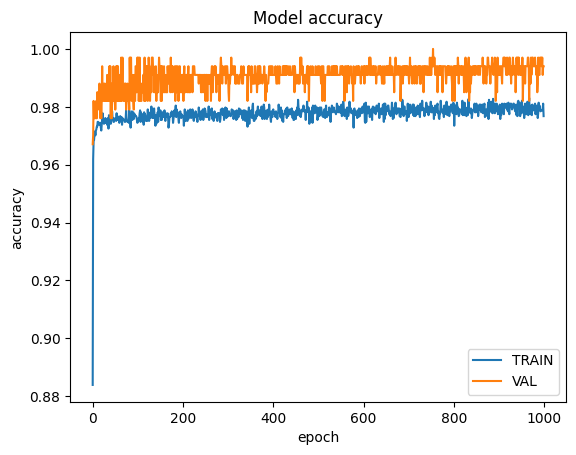

In [47]:
# Visualize the training history to see whether you're overfitting.
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['TRAIN', 'VAL'], loc='lower right')
plt.show()

In [48]:
# Evaluate the model using the TEST dataset
loss, accuracy = model.evaluate(X_test, y_test)

11/11 [==============================] - 0s 1ms/step - loss: 0.0420 - accuracy: 0.9790


### Draw the confusion matrix to better understand the model performance

11/11 [==============================] - 0s 1ms/step
Confusion matrix, without normalization

Classification Report:
               precision    recall  f1-score   support

         cpr       0.96      1.00      0.98       154
       uncpr       1.00      0.96      0.98       180

    accuracy                           0.98       334
   macro avg       0.98      0.98      0.98       334
weighted avg       0.98      0.98      0.98       334



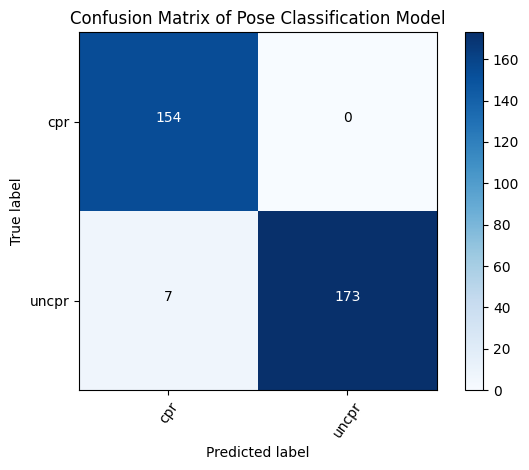

In [49]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """Plots the confusion matrix."""
  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
  else:
    print('Confusion matrix, without normalization')

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=55)
  plt.yticks(tick_marks, classes)
  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
              horizontalalignment="center",
              color="white" if cm[i, j] > thresh else "black")

  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.tight_layout()

# Classify pose in the TEST dataset using the trained model
y_pred = model.predict(X_test)

# Convert the prediction result to class name
y_pred_label = [class_names[i] for i in np.argmax(y_pred, axis=1)]
y_true_label = [class_names[i] for i in np.argmax(y_test, axis=1)]

# Plot the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
plot_confusion_matrix(cm,
                      class_names,
                      title ='Confusion Matrix of Pose Classification Model')

# Print the classification report
print('\nClassification Report:\n', classification_report(y_true_label,
                                                          y_pred_label))

### (Optional) Investigate incorrect predictions

You can look at the poses from the `TEST` dataset that were incorrectly predicted to see whether the model accuracy can be improved.

Note: This only works if you have run step 1 because you need the pose image files on your local machine to display them.

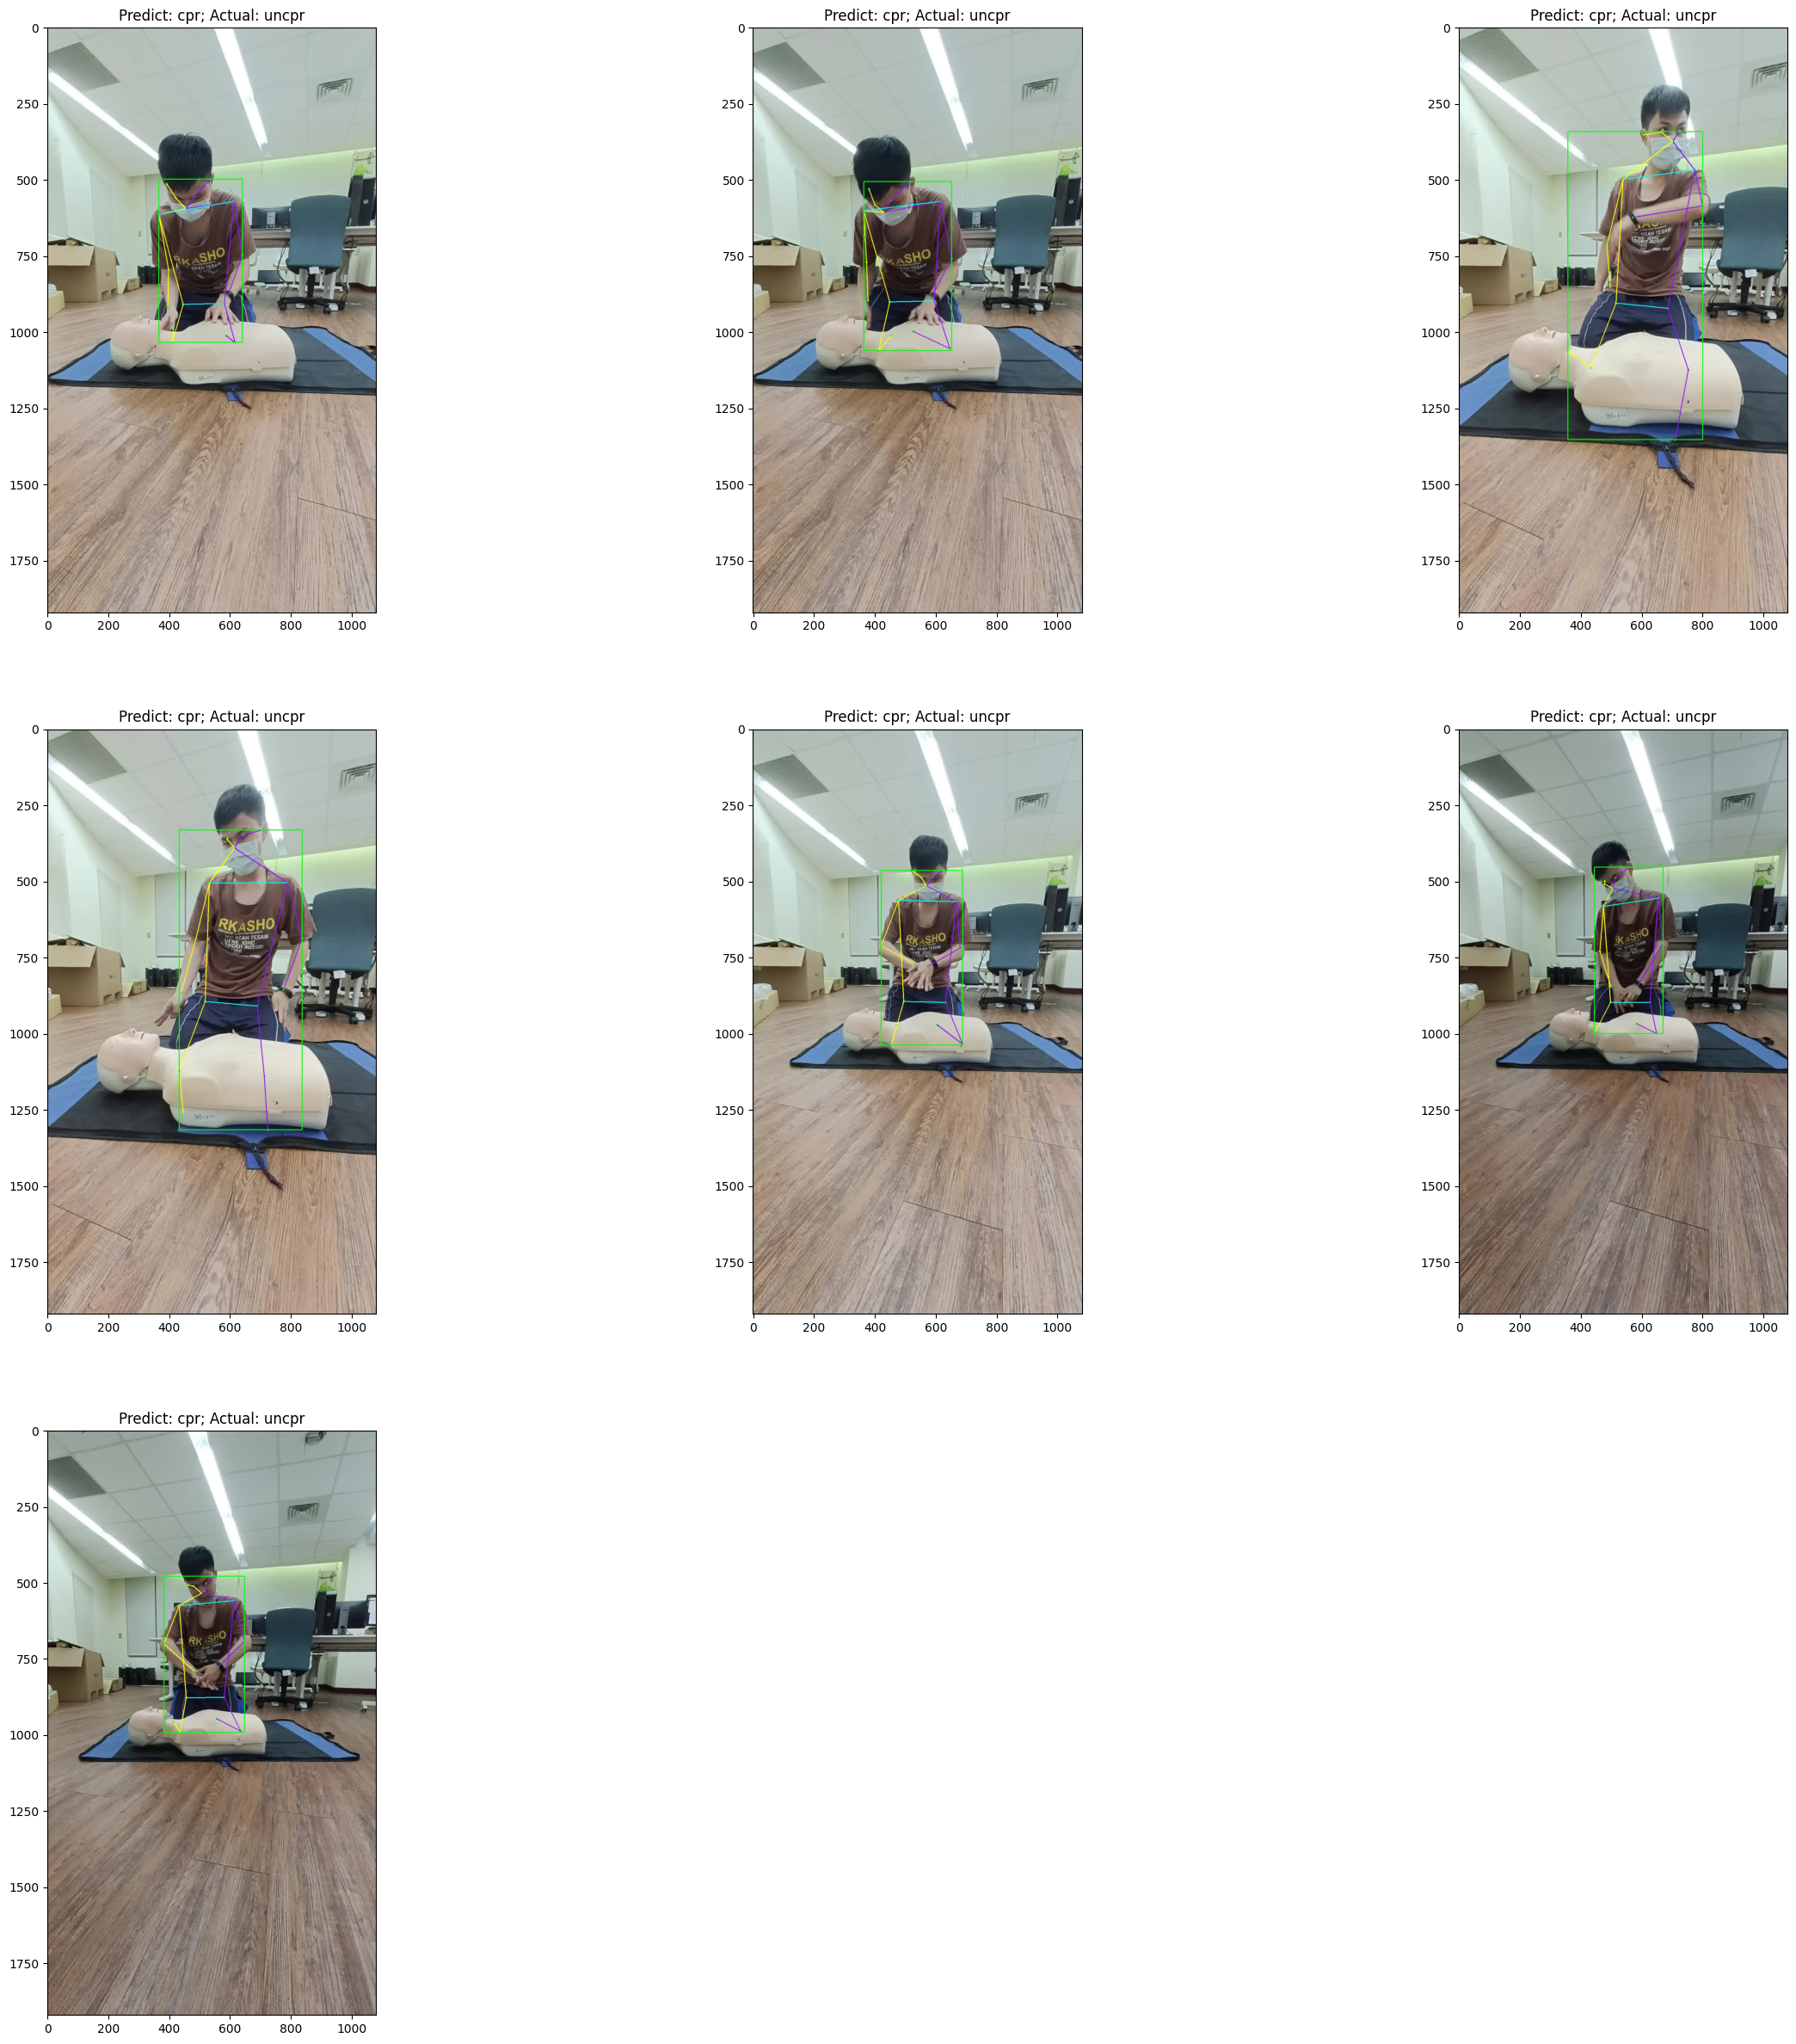

In [50]:
if is_skip_step_1:
  raise RuntimeError('You must have run step 1 to run this cell.')

# If step 1 was skipped, skip this step.
IMAGE_PER_ROW = 3
MAX_NO_OF_IMAGE_TO_PLOT = 30

# Extract the list of incorrectly predicted poses
false_predict = [id_in_df for id_in_df in range(len(y_test)) \
                if y_pred_label[id_in_df] != y_true_label[id_in_df]]
if len(false_predict) > MAX_NO_OF_IMAGE_TO_PLOT:
  false_predict = false_predict[:MAX_NO_OF_IMAGE_TO_PLOT]

# Plot the incorrectly predicted images
row_count = len(false_predict) // IMAGE_PER_ROW + 1
fig = plt.figure(figsize=(10 * IMAGE_PER_ROW, 10 * row_count))
for i, id_in_df in enumerate(false_predict):
  ax = fig.add_subplot(row_count, IMAGE_PER_ROW, i + 1)
  image_path = os.path.join(images_out_test_folder,
                            df_test.iloc[id_in_df]['file_name'])

  image = cv2.imread(image_path)
  plt.title("Predict: %s; Actual: %s"
            % (y_pred_label[id_in_df], y_true_label[id_in_df]))
  plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

## Part 3: Convert the pose classification model to TensorFlow Lite

You'll convert the Keras pose classification model to the TensorFlow Lite format so that you can deploy it to mobile apps, web browsers and edge devices. When converting the model, you'll apply [dynamic range quantization](https://www.tensorflow.org/lite/performance/post_training_quant) to reduce the pose classification TensorFlow Lite model size by about 4 times with insignificant accuracy loss.

Note: TensorFlow Lite supports multiple quantization schemes. See the [documentation](https://www.tensorflow.org/lite/performance/model_optimization) if you are interested to learn more.

In [51]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

print('Model size: %dKB' % (len(tflite_model) / 1024))

with open('pose_classifier.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\lab519\AppData\Local\Temp\tmpowrzzop2\assets
Model size: 26KB


Then you'll write the label file which contains mapping from the class indexes to the human readable class names.

In [52]:
with open('pose_labels.txt', 'w') as f:
  f.write('\n'.join(class_names))

As you've applied quantization to reduce the model size, let's evaluate the quantized TFLite model to check whether the accuracy drop is acceptable.

In [53]:
def evaluate_model(interpreter, X, y_true):
  """Evaluates the given TFLite model and return its accuracy."""
  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]

  # Run predictions on all given poses.
  y_pred = []
  for i in range(len(y_true)):
    # Pre-processing: add batch dimension and convert to float32 to match with
    # the model's input data format.
    test_image = X[i: i + 1].astype('float32')
    interpreter.set_tensor(input_index, test_image)

    # Run inference.
    interpreter.invoke()

    # Post-processing: remove batch dimension and find the class with highest
    # probability.
    output = interpreter.tensor(output_index)
    predicted_label = np.argmax(output()[0])
    y_pred.append(predicted_label)

  # Compare prediction results with ground truth labels to calculate accuracy.
  y_pred = keras.utils.to_categorical(y_pred)
  return accuracy_score(y_true, y_pred)

# Evaluate the accuracy of the converted TFLite model
classifier_interpreter = tf.lite.Interpreter(model_content=tflite_model)
classifier_interpreter.allocate_tensors()
print('Accuracy of TFLite model: %s' %
      evaluate_model(classifier_interpreter, X_test, y_test))

Accuracy of TFLite model: 0.9940119760479041


Now you can download the TFLite model (`pose_classifier.tflite`) and the label file (`pose_labels.txt`) to classify custom poses. See the [Android](https://github.com/tensorflow/examples/tree/master/lite/examples/pose_estimation/android) and [Python/Raspberry Pi](https://github.com/tensorflow/examples/tree/master/lite/examples/pose_estimation/raspberry_pi) sample app for an end-to-end example of how to use the TFLite pose classification model.

In [ ]:
# Windows 不支持 zip 命令，手動把 pose_labels.txt、pose_classifier.tflite 這兩個文件壓縮成一個包 pose_classifier.zip
# 不過這裡壓縮是為了方便下載，我們在本地跑不需要這一步
# !zip pose_classifier.zip pose_labels.txt pose_classifier.tflite

In [ ]:
# 這裡不需要下載了，正在本地運行的
# Download the zip archive if running on Colab.
# try:
#   from google.colab import files
#   files.download('pose_classifier.zip')
# except:
#   pass